In [72]:
# Imports
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import networkx as nx
from scipy import spatial
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy
import scipy.sparse
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
# replace nans in angle with 0s

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD FILE W WEIBEL

In [2]:
# Load the e5 csv and add weibel gen (if uncommented)
# orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5lungairwaysvida_20140211.csv"))
orig_df = pd.read_csv(os.path.abspath('/home/sneha/e5lungairwaysvida_20140211_weibel.csv')) # original + weibel gen added

/tmp/ipykernel_24346/2955888588.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  orig_df = pd.read_csv(os.path.abspath('/home/sneha/e5lungairwaysvida_20140211_weibel.csv')) # original + weibel gen added


## Remove scan problems

In [3]:
# REMOVE SCAN PROBLEM
ids_w_scan_problem = orig_df.loc[orig_df.scan_problem != 0].idno.unique()
print(f"There are {len(ids_w_scan_problem)} ids with san problems --> remove them")
orig_df = orig_df.loc[~(orig_df.idno.isin(ids_w_scan_problem))]
print(f"There are {orig_df.idno.nunique()} remaining participants")




There are 92 ids with san problems --> remove them
There are 3102 remaining participants


## Remove nans in startbpid / endbpid

In [8]:
# REMOVE NANS in START + ENDBPID
orig_df.dropna(subset=['startbpid', 'endbpid'], inplace=True)
print(f"There are {orig_df.idno.nunique()} remaining participants after dropping NaNs in start/endbpid")
# print null
orig_df.isnull().sum()

There are 2911 remaining participants after dropping NaNs in start/endbpid


Unnamed: 0                         0
idno                               0
subject_name                       0
subject_id                         0
session_id                         0
                                  ..
innerperimeter_70                  0
outerperimeter_70                  0
innerequivalentcirclediameter_7    0
scan_problem                       0
weibel_generation                  0
Length: 149, dtype: int64

## Remove unneccesary cols

In [9]:
# drop unneccesary cols

useful_cols = ['idno',
 'anatomicalname',
 'centerlinelength','avginnerarea','lobe',
 'sublobe',
 'endbpid',
 'startbpid',
 'angle',
 'dircosx',
 'dircosy',
 'dircosz', 'weibel_generation']

orig_df = orig_df[useful_cols]
print(len(orig_df))



964751


# DEFINING FUNCTIONS FOR CLEANING

## QC paths only



In [10]:
def get_nodes_leq_segmental(df, visualise=False):
    segmental= ['RB1','RB2', 'RB3', 'RB4', 'RB5', 'RB6', 'RB7','RB8', 'RB9', 'RB10', 
            'LB1','LB2','LB1+2','LB3', 'LB4', 'LB5','LB6','LB8','LB9','LB10']

    # find endbpids for segmental
    segmental_endbpid = df.loc[df.anatomicalname.isin(segmental)]['endbpid'].unique()
    print("Len segmental", len(segmental_endbpid))
    # earlier_endbpids
    # make graph for participant
    g = nx.DiGraph()
    nodes = [-1.0] +df.endbpid.to_list()
    edges = list(zip(df.startbpid, df.endbpid))
    edges_with_features = dict(zip(edges,df[['anatomicalname']].to_dict(orient='records')))
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    nx.set_edge_attributes(g,edges_with_features)
    nodes_on_path = list(segmental_endbpid)
    errors = []
    for node in segmental_endbpid:
        try:
            nodes_on_path.extend(nx.shortest_path(g, -1, node))
        except:
            print('Exception for node', node)
            visualise=True
            row = df.loc[df.endbpid == node]
            print(f'Node: {row.anatomicalname.item()},gen: {row.weibel_generation.item()},{node} in graph? {node in g.nodes()}, has path? {nx.has_path(g, -1, node)}')
    nodes_on_path = list(set(nodes_on_path))
    
    
    if visualise:

        colours = dict.fromkeys(df.endbpid.to_list())
        for key in colours:
            if key in nodes_on_path:
                colours[key] = '#428bca'
            elif key in errors:
                colours[key] = '#d9534f'
            else:
                colours[key] = '#d896ff'

        cmap = [colours.get(node,  '#d9534f')  for node in g.nodes()]
#         labels = {node:g.nodes[node]['anatomicalname'] for node in g.nodes() if (not len(g.nodes[node])==0) & (len(g.nodes[node]['anatomicalname']) > 1)}
        edge_labels = {edge:g.edges[edge]['anatomicalname'] for edge in g.edges() if (len(g.edges[edge]['anatomicalname']) > 1) & ('unnamed' not in g.edges[edge]['anatomicalname'])}
        # print('edge', edge_labels)

        edge_cmap = [colours.get(edge[1],  '#d9534f') for edge in g.edges()]
        pos = nx.planar_layout(g, scale=1,  dim=2)
        f, ax = plt.subplots(figsize=(20,20))

        nx.draw(g,pos=pos, with_labels=False,node_color=cmap, edge_color=edge_cmap, ax=ax)
        nx.draw_networkx_edge_labels(g, pos,
                                  edge_labels,
                                     font_color='k',
                                     font_size='10',
                                  label_pos=0.5,
                                  )
        plt.show()

    
    return nodes_on_path




def _travel_two(df, extend_names=['LB1', 'LB10', 'RB1', 'RB4', 'RB10'], extend_gen=2):
#     print('start',df.QC.sum())
    startbpids = df.loc[df.anatomicalname.isin(extend_names)]['endbpid'].to_list()
#     print(f"Extending {extend_gen} generations from {extend_names} which have segment ids = {startbpids}")
    qc_children = startbpids
    for i in range(extend_gen):
        new_children = df.loc[df.startbpid.isin(qc_children)]['endbpid'].to_list()
        qc_children+=new_children
#         print('Adding a generation', qc_children)
#     print('end', len(qc_children))
    return qc_children
    
          


## Remove all orphans

In [11]:
def _remove_orphans(df):
    orphan_check = np.zeros_like(df.endbpid.values, dtype=bool)
    groups = df.groupby('idno')
    i = 0
    for name, group in tqdm(groups, desc='Iterating ids'):
        orphan_check[i:i+len(group)] =\
        np.isin(group.startbpid.values, group.endbpid.values) | \
        (group.startbpid == -1)
        i = i+len(group)
    return orphan_check


# orpha_check = _remove_orphans(orig_df)
# orig_df.loc[(orig_df.idno ==3010007)]

In [12]:
def remove_all_orphans(orig_df):
    there_are_orphans = True
    i = 0
    while there_are_orphans:
        i+=1
        
        orphan_check = _remove_orphans(orig_df)
        num_orphan = (orphan_check==0).sum()
        
        if num_orphan ==0:
            print(f"Iter {i}: THERE ARE NO ORPHANS. Final df length {len(orig_df)}")
            there_are_orphans = False
            break
        else:
            print(f"Iter {i}:There are {num_orphan} orphans, REMOVING THEM")
            orig_df = orig_df.loc[orphan_check]
            print(f"Df length {len(orig_df)}")
    return orig_df




## Add coords of tree and SCALE

In [18]:

def _scale_tree_rmb(test):
    rmb = test.loc[test.anatomicalname.str.lower() =='rmb', ['centerlinelength', 'avginnerarea']].values.squeeze()
    assert rmb.shape[0] > 0, f'{rmb}'
    length_sf, area_sf = 1/rmb
    test['centerlinelength'] = test.centerlinelength.apply(lambda x:x*length_sf)
    test['avginnerarea'] = test.avginnerarea.apply(lambda x:x*area_sf)
    return test

# ADD COorodinates

def _get_coords(single_test, start_x=0, start_y=0,start_z=0, start_loc=-1, x_sf=1, y_sf=1, z_sf=1):
    '''
    single_test: single participant tree dataframe
    startx/y/z: coords of carina to start
    start_loc: 1 = endbpid corresponding to startx,y,z 1=carina, -1 = top of trachea  
    x/y/z_sf: scale factors based on voxel dimensions mm    
    
    '''
    assert single_test.startbpid.min() == start_loc, 'The dataframe entered has rows before start_loc'
    # gets coords of ENDBPID
    # THIS HAS -1 on the Y!
    # delta x, delta y, delta z for each of the segments --> scaled by pixel scale factor to get to 1:1:1 visualisation
    x_diff= (single_test.centerlinelength*single_test.dircosx/x_sf).values
    # running without minus
    y_diff = (single_test.centerlinelength*single_test.dircosy/y_sf).values
    z_diff = (single_test.centerlinelength*single_test.dircosz/z_sf).values
    endbpid = single_test.endbpid.values
    idno = single_test.idno.values
    startbpid = single_test.startbpid.values
#     print(list(zip(endbpid, x_diff, y_diff, z_diff)))
    
    x = np.zeros_like(x_diff)
    y = np.zeros_like(x_diff)
    z = np.zeros_like(x_diff)
    # for each segment, if we're at the start location, add start location to delta x,y,z
    # otherwise, find the parent x,y,z value (done sequentially) and add on parent location
    for i in range(len(endbpid)):
        if startbpid[i] == start_loc:
#             print("adding start loc", start_x, start_y, start_z)
            x[i] = x_diff[i] + start_x
            y[i] = y_diff[i] + start_y
            z[i] = z_diff[i] + start_z
#             print(i, x[i], y[i], z[i])
        else:
            # find parent endbpid and get the corresponding x,y,z
            try:
                parent = np.where(endbpid == startbpid[i])
            
                x[i] = x_diff[i] + x[parent] 
                y[i] = y_diff[i] + y[parent] 
                z[i] = z_diff[i] + z[parent] 
            except:
                print('parent',parent)
                print("parent", parent, "i", i, x[i], y[i], z[i])
    # put into dataframe
    coords_df = pd.DataFrame({ "endbpid": endbpid, "x": x, "y": y, "z":z})
    tree_w_coords= single_test.merge(coords_df, how="left", on='endbpid')
    
    
    
    def get_parent_coords(x, col='x'):
        '''
        IMP: the df must be called tree_w_coords
        x: row in df.apply function
        col: str x,y,z to tell which parent coord to get
        It will not fill in start loc - do manually after
        '''
        # x to the df titled **tree_w_coords** get all the endbpids/ segment labels 

        v = np.array(tree_w_coords['endbpid'].to_list()) 
        # np.isin - check T/F for the location of the parent segment for the row x will be an array (F, T,F,F..)
        if np.any(np.isin(v,x.startbpid)):
            # provided we can find the parent, get the index of that parent (the first True in the isin array)
            index = np.argmax(np.isin(v,x.startbpid)) # find row that contains the parent branch (prev bpid)
            try:
                # try to get the parent row from the df
                row_parent = tree_w_coords.iloc[index] 
            except:
                print("Help", index, len(x))
            # return x,y,z loc of parent
            return row_parent[col]
        else:
#             print(f"No parent {col} coord", x.to_list())
            return np.nan
    
    
    tree_w_coords["parent_loc_x"]=tree_w_coords.apply(lambda x: get_parent_coords(x,'x'), axis=1)
    tree_w_coords["parent_loc_y"]=tree_w_coords.apply(lambda x: get_parent_coords(x,'y'), axis=1)
    tree_w_coords["parent_loc_z"]=tree_w_coords.apply(lambda x: get_parent_coords(x,'z'), axis=1)

    # fill parent loc for start posn with start loc (Nan from the df.apply func)
    tree_w_coords.loc[tree_w_coords.startbpid == start_loc, 'parent_loc_x']= start_x
    tree_w_coords.loc[tree_w_coords.startbpid ==  start_loc,'parent_loc_y']= start_y
    tree_w_coords.loc[tree_w_coords.startbpid ==  start_loc, 'parent_loc_z']= start_z
    
    
    
    return tree_w_coords


# carina_locs
def _shift_df(orig_df):
    carina_locs = orig_df.loc[orig_df.endbpid==1, ['idno', 'x','y','z']]
    carina_locs = carina_locs.rename(columns={'x':'shift_x','y':'shift_y','z':'shift_z'})
    shifted_df = orig_df.merge(carina_locs, on='idno', how='left')
    # apply shift
    shifted_df[['x','y','z']] = shifted_df[['x','y','z']].values.squeeze() - shifted_df[['shift_x','shift_y','shift_z']].values.squeeze()
    shifted_df[["parent_loc_x","parent_loc_y","parent_loc_z"]] = shifted_df[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze() - shifted_df[['shift_x','shift_y','shift_z']].values.squeeze()
    # check all caaina are now 0
#     display(shifted_df.loc[shifted_df.endbpid==1, ['idno', 'x','y','z']])
    return shifted_df

# ROTATE TREES TO ALIGN RMB

def _get_rot_mat(test):
    carina = test.loc[test.anatomicalname.str.lower() =='trachea', ['x', 'y', 'z']].values.squeeze()
    trachea = test.loc[test.anatomicalname.str.lower() =='trachea', ["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze()
    if len(carina) < 3:
        # maybe labelling not right - try another way
        carina = test.loc[test.startbpid==-1, ['x', 'y', 'z']].values.squeeze()
        assert len(carina) > 2, f'cannot find carina for {test.idno.unique()}, {carina}'
    lmb = test.loc[test.anatomicalname.str.lower() =='lmb', ['x', 'y', 'z']].values.squeeze()
    if len(lmb) < 3:
        # maybe labelling not right - try another way
        lmb = test.loc[((test.startbpid==1)& (test.anatomicalname.str.lower() != 'rmb')), ['x', 'y', 'z']].values.squeeze()
        assert len(lmb) > 2, f'cannot find lmb for {test.idno.unique()}, {lmb}'
    rmb = test.loc[test.anatomicalname.str.lower() =='rmb', ['x', 'y', 'z']].values.squeeze()
    if len(rmb) < 3:
        # maybe labelling not right - try another way
        rmb = test.loc[((test.startbpid==1)& (test.anatomicalname.str.lower() != 'lmb')), ['x', 'y', 'z']].values.squeeze()
        assert len(rmb) > 2, f'cannot find rmb for {test.idno.unique()}, {rmb}'
        
    print(carina, lmb, rmb)
    v1 = rmb - carina
    # trachea
#     v1 = carina - trachea 
    v2 = lmb - carina
    # normal to the plane containing v1 and v2 make this the z axis
    n3 = np.cross(v1, v2)
    n3 /= scipy.linalg.norm(n3)

    n2 = v1/scipy.linalg.norm(v1) # make v1 (rmb) this y axis

    #x axis is perpendicular to n3 and n2
    n1 = np.cross(n2, n3)
    n1 /= scipy.linalg.norm(n1)
    n1, n2, n3 = n1.squeeze(), n2.squeeze(), n3.squeeze()
    e1, e2, e3 = np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])
    new_coord_sys = [n1.squeeze(), n2.squeeze(), n3.squeeze()]
    print(new_coord_sys)
    old_coord_sys = [e1, e2, e3]
#     print('new', new_coord_sys)
#     print('old', old_coord_sys)
    rot_mat = np.inner(new_coord_sys,old_coord_sys)
    return rot_mat


def _rotate_trees(df):
    
    for i, (name, participant_df) in tqdm(list(enumerate(df.groupby('idno')))):
        rot_mat = _get_rot_mat(participant_df)
        print('Rot mat', rot_mat)
        
        def _apply_transform(v):
            transformed_v =np.matmul(rot_mat, v)
            return transformed_v

        participant_df[['nx', 'ny', 'nz']] = np.apply_along_axis(_apply_transform,1, participant_df[["x","y","z"]].values.squeeze())
        participant_df[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]] = np.apply_along_axis(_apply_transform,1, participant_df[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze())

        if i ==0:
            df_rotated = participant_df.copy()
        else:
            df_rotated = pd.concat([df_rotated, participant_df], axis=0)
        
        print(len(df_rotated))
    return df_rotated



# RUN + APPLY CLEANING FUNCTIONS

/tmp/ipykernel_24346/927824887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_df['QC'] = False


964751


  0%|          | 0/2911 [00:00<?, ?it/s]

Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Exception for node 161.0
Node: RB8,gen: 1,161.0 in graph? True, has path? False
Exception for node 244.0
Node: RB9,gen: 2,244.0 in graph? True, has path? False
Exception for node 245.0
Node: RB10,gen: 2,245.0 in graph? True, has path? False


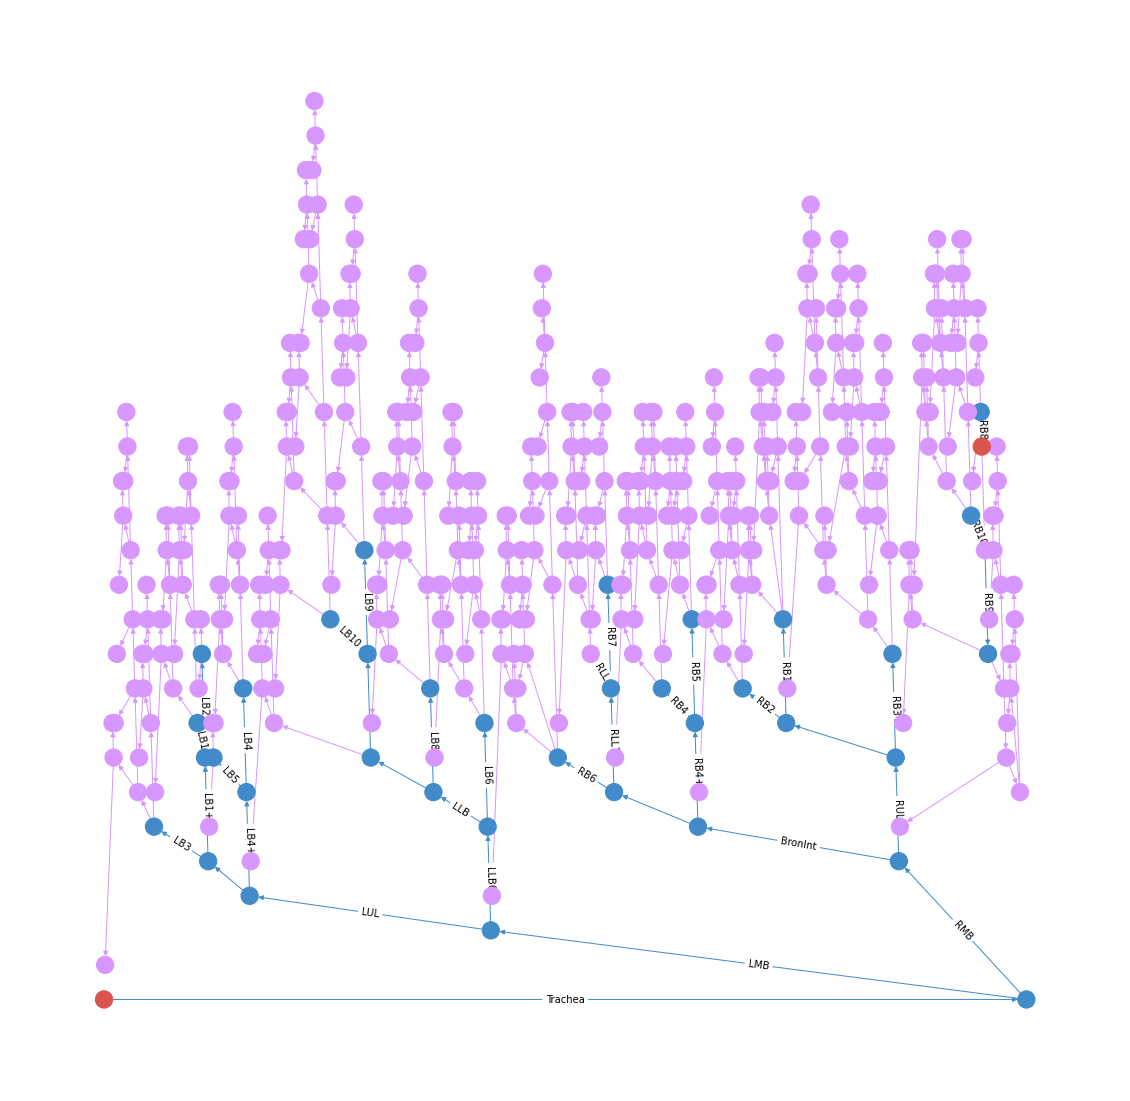

Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 

Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 16
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 

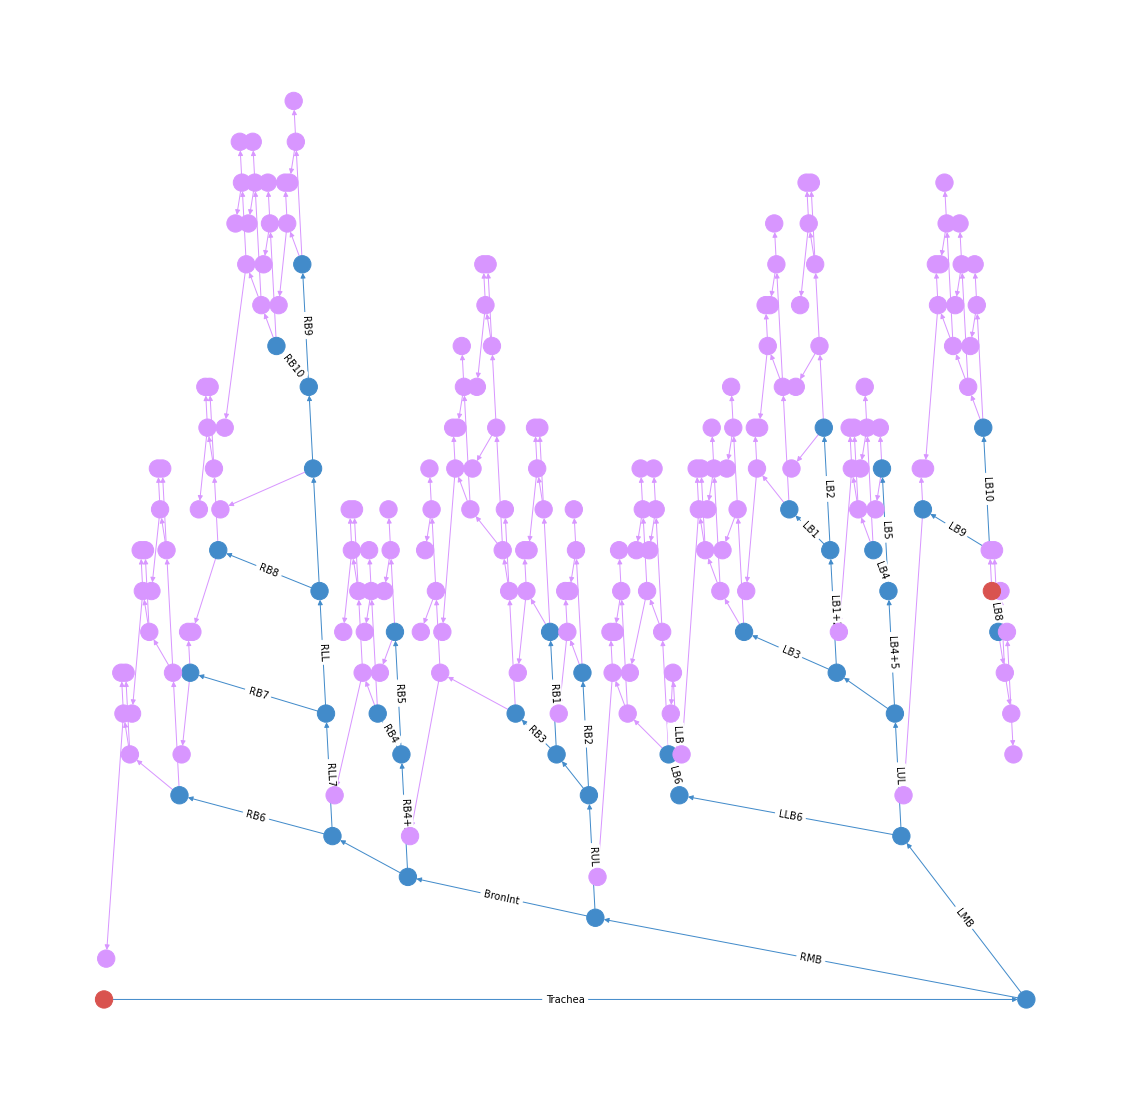

Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 18
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 18
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 

Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 18
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 

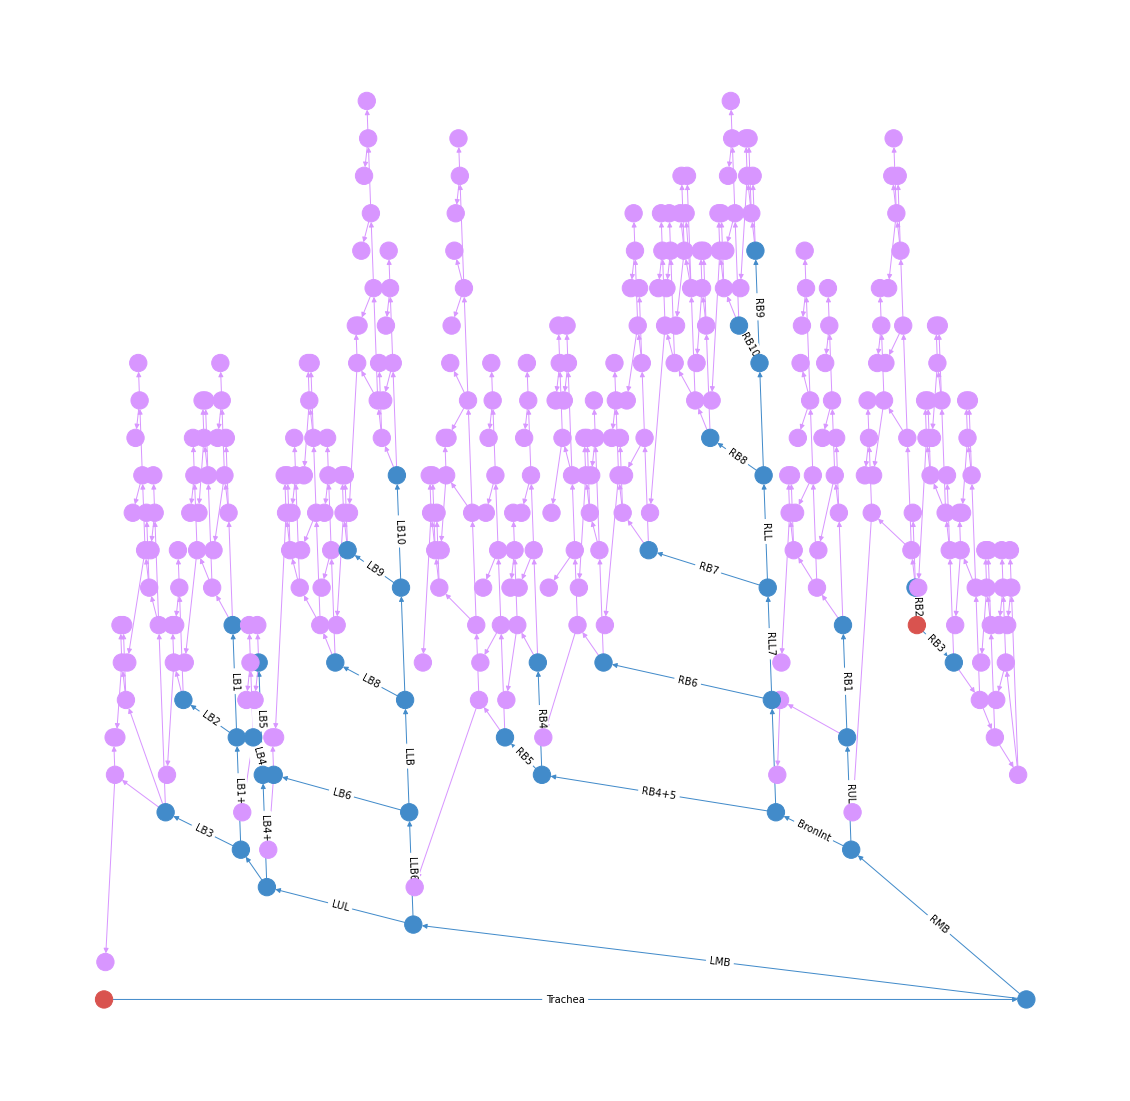

Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 18
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 18
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 18
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 

Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 

Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 

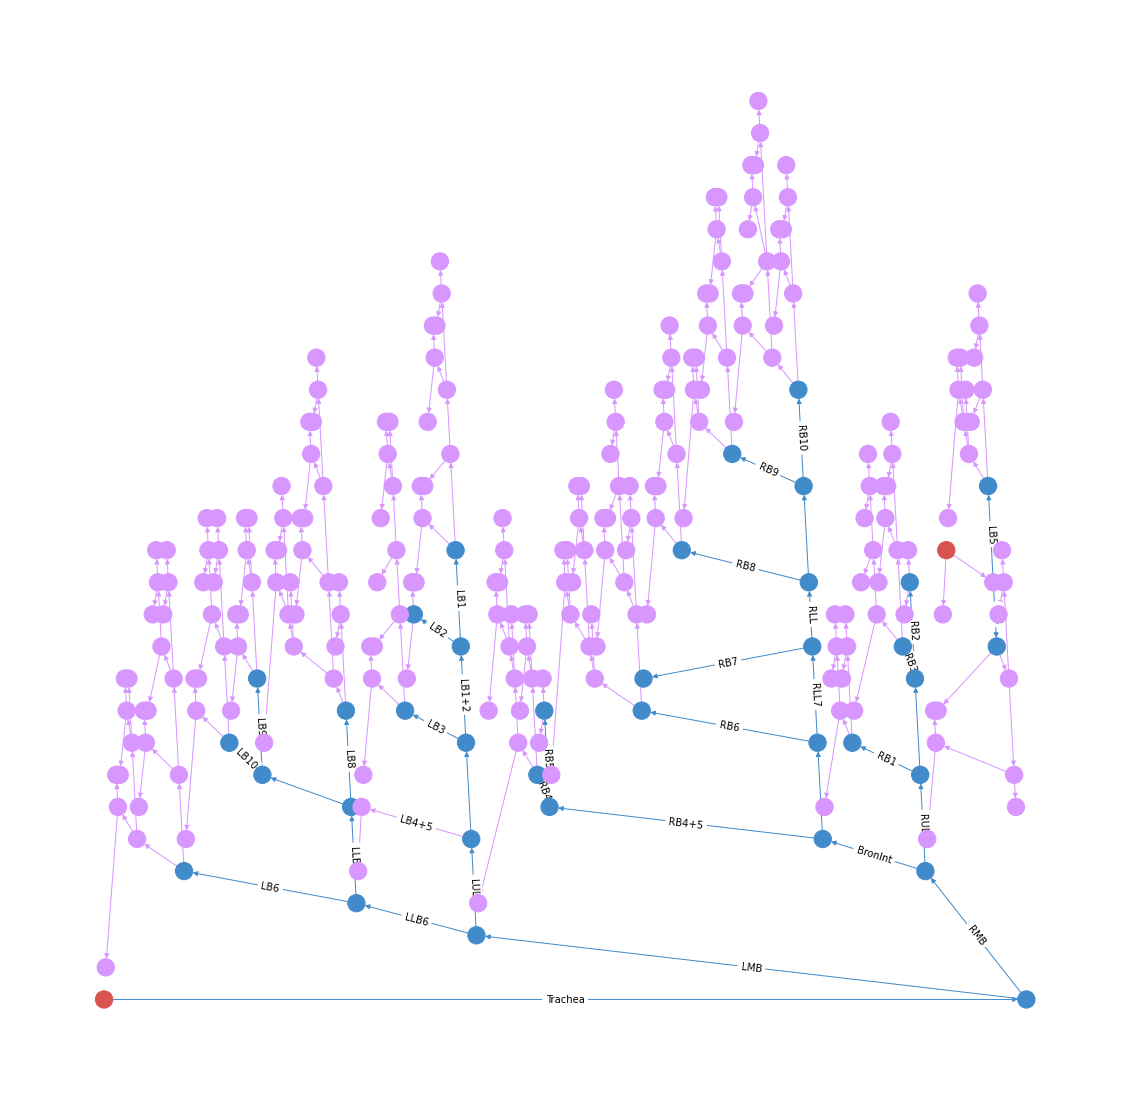

Len segmental 19
Len segmental 20
Len segmental 20
Len segmental 19
Len segmental 20


In [15]:
# IDNENTIFY QC PATHS (DONT REMOVE YET) 
orig_df['QC'] = False    
print(len(orig_df))
for i, participant_df in tqdm(list(orig_df.groupby('idno'))):
    nodes_on_path = get_nodes_leq_segmental(participant_df, visualise=False)
    qc_children = _travel_two(participant_df,extend_names=['LB1', 'LB10', 'RB1', 'RB4', 'RB10'], extend_gen=2)
    all_qc = nodes_on_path + qc_children
    orig_df.loc[(orig_df.idno==int(participant_df.idno.unique())) & (orig_df.endbpid.isin(all_qc)), 'QC']= True

In [16]:
# remove orphans
orig_df = remove_all_orphans(orig_df)



Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 1:There are 84 orphans, REMOVING THEM
Df length 964667


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 2:There are 61 orphans, REMOVING THEM
Df length 964606


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 3:There are 50 orphans, REMOVING THEM
Df length 964556


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 4:There are 48 orphans, REMOVING THEM
Df length 964508


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 5:There are 50 orphans, REMOVING THEM
Df length 964458


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 6:There are 41 orphans, REMOVING THEM
Df length 964417


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 7:There are 13 orphans, REMOVING THEM
Df length 964404


Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 8: THERE ARE NO ORPHANS. Final df length 964404


In [19]:
# SCALE --> ADD COORDS --> SHIFT CARINA TO 0

# groups = orig_df.groupby('idno')

# name, group = list(groups)[0]
# df_w_coords = _get_coords(group)

# for name, group in tqdm(list(groups)[1:]):
#     df_w_coords = pd.concat([df_w_coords, _get_coords(group)], axis=0,ignore_index=True)
#     print(len(df_w_coords))

    
groups = orig_df.groupby('idno')

name, group = list(groups)[0]
group = _scale_tree_rmb(group)
print('scaled')
display(group.head(5))
df_w_coords = _get_coords(group)

for name, group in tqdm(list(groups)[1:]):
    group = _scale_tree_rmb(group)
    df_w_coords = pd.concat([df_w_coords, _get_coords(group)], axis=0,ignore_index=True)
    print(len(df_w_coords))




scaled


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,QC
0,3010007,Trachea,4.125184,1.630629,0.0,0.0,1.0,-1.0,NaN,-0.024446,0.229788,0.972934,0,True
1,3010007,LMB,2.004944,0.689714,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,True
2,3010007,RMB,1.000000,1.000000,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,True
3,3010007,BronInt,1.172444,0.519476,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,True
4,3010007,RUL,0.654350,0.351148,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,True


  0%|          | 0/2910 [00:00<?, ?it/s]

844
1315
1496
2029
2699
3209
3562
3805
4368
4892
5424
6118
6306
6640
7050
7341
7711
8012
8522
9013
9396
9809
10357
10734
11199
11567
11755
12240
12579
12971
13464
13758
14258
14680
14931
15739
16303
16679
17180
17435
17955
18451
18942
19224
19765
20023
20369
21022
21429
21798
22150
22593
23159
23928
24541
25007
25392
25696
26122
26523
26855
27052
27601
28009
28366
28740
29199
29951
30351
30625
31119
31448
31772
32133
32492
32944
33310
33684
33782
33926
34211
34472
34951
35418
35822
35946
36627
36890
37244
37532
37798
38107
38293
38735
39126
39549
39938
40386
40908
41310
41545
42035
42369
42552
42669
42984
43278
43613
43932
44365
44821
45178
45415
45953
46546
47104
47231
47394
47819
48131
48486
48894
49447
49642
50001
50435
50610
51011
51185
51400
51669
52040
52205
52556
52832
53220
53697
54389
54831
55218
55587
55850
56182
56542
56762
57238
57628
57929
58134
58472
58795
59289
59695
60082
60472
60852
61380
61836
61973
62328
62645
62891
63126
63641
64034
64318
64721
64927
65137
65450
659

439337
439643
440036
440562
441039
441210
441496
441838
442245
442634
442781
442975
443048
443252
443561
443767
444025
444264
444699
445090
445396
445691
446073
446396
446878
447256
447545
448056
448433
448690
448921
449158
449568
449908
450044
450554
451033
451564
451918
452147
452558
452634
453177
453467
453691
453881
454464
454784
454880
455384
455542
455720
455926
456379
456613
456998
457227
457528
457760
458333
458565
458993
459146
459489
459813
460128
460343
460700
460758
461158
461412
461583
461793
462151
462306
462617
462966
463156
463347
463741
464116
464523
464739
464874
465156
465353
465529
465752
466311
466693
467142
467510
467694
468132
468654
469076
469529
469888
470201
470634
470979
471399
471789
472286
472470
472884
473094
473340
473809
474072
474313
474915
475313
475566
475884
476197
476476
476760
476832
477061
477538
477638
478113
478498
478846
479067
479274
479433
479760
479983
480300
480538
480934
481199
481576
481668
481782
481880
482237
482654
482929
483173
483512

797870
798143
798645
798916
799507
799754
800041
800284
800521
800861
801137
801243
801646
802070
802457
802718
803021
803233
803481
803724
803961
804312
804729
804974
805216
805471
805771
806030
806294
806373
806999
807305
807494
807806
808152
808462
808885
809287
809518
809816
810261
810563
810801
810918
811396
811575
811793
812147
812344
812615
812678
812930
813151
813466
813829
814107
814414
814593
815127
815631
815922
816441
816648
816766
817172
817416
817841
818271
818615
819182
819338
819749
820189
820586
820903
821155
821409
821789
822182
822485
822669
822733
823150
823372
823642
824022
824217
824510
824963
825093
825412
825667
825808
826206
826728
826947
827253
827577
828041
828154
828687
828880
829138
829343
829732
830128
830478
830631
831064
831522
831708
832118
832265
832622
833053
833322
833688
834042
834267
834473
834553
834756
835158
835441
835833
836250
836436
836799
837022
837253
837399
837715
838274
838554
838963
839104
839432
839812
840183
840458
840572
840895
841286

In [22]:

shifted_df = _shift_df(df_w_coords)
print('Checking carina now at 0')
display(shifted_df.loc[shifted_df.startbpid==-1, ['x','y','z']])
# get rotated trees
rotated_coords_df = _rotate_trees(shifted_df)
rotated_coords_df

Checking carina now at 0


,x,y,z
0,0.0,0.0,0.0
381,0.0,0.0,0.0
844,0.0,0.0,0.0
1315,0.0,0.0,0.0
1496,0.0,0.0,0.0
...,...,...,...
963035,0.0,0.0,0.0
963245,0.0,0.0,0.0
963404,0.0,0.0,0.0
963810,0.0,0.0,0.0


  0%|          | 0/2911 [00:00<?, ?it/s]

[0. 0. 0.] [1.22003258 0.09207806 1.58834483] [-0.694225  -0.0478776  0.718164 ]
[array([-0.7161818 , -0.05339288, -0.6958684 ]), array([-0.69422495, -0.0478776 ,  0.71816395]), array([-0.07166135,  0.99742515, -0.00277761])]
Rot mat [[-0.7161818  -0.05339288 -0.6958684 ]
 [-0.69422495 -0.0478776   0.71816395]
 [-0.07166135  0.99742515 -0.00277761]]
381
[0. 0. 0.] [0.95574625 0.23442739 1.40656947] [-0.716109  -0.0183618  0.697747 ]
[array([-0.68894887, -0.14176896, -0.71081011]), array([-0.71610895, -0.0183618 ,  0.69774695]), array([-0.11197061,  0.98972946, -0.08887168])]
Rot mat [[-0.68894887 -0.14176896 -0.71081011]
 [-0.71610895 -0.0183618   0.69774695]
 [-0.11197061  0.98972946 -0.08887168]]
844
[0. 0. 0.] [1.3044744  0.         1.68681939] [-0.374828  -0.0440974  0.926045 ]
[array([-0.9262151 , -0.02568104, -0.37611976]), array([-0.37482801, -0.0440974 ,  0.92604502]), array([-0.0403677 ,  0.9986971 ,  0.03121771])]
Rot mat [[-0.9262151  -0.02568104 -0.37611976]
 [-0.37482801 -

13464
[0. 0. 0.] [1.40020667 0.68899118 1.40020667] [-0.43468   0.130404  0.891094]
[array([-0.8734439 , -0.30212833, -0.38185629]), array([-0.43467991,  0.13040397,  0.89109381]), array([-0.2194291 ,  0.94430571, -0.24522967])]
Rot mat [[-0.8734439  -0.30212833 -0.38185629]
 [-0.43467991  0.13040397  0.89109381]
 [-0.2194291   0.94430571 -0.24522967]]
13758
[0. 0. 0.] [1.08722962 0.25089981 1.33812943] [-0.596576   0.0205716  0.802293 ]
[array([-0.79593001, -0.14336371, -0.58816857]), array([-0.59657595,  0.0205716 ,  0.80229293]), array([-0.10292012,  0.98945624, -0.10190089])]
Rot mat [[-0.79593001 -0.14336371 -0.58816857]
 [-0.59657595  0.0205716   0.80229293]
 [-0.10292012  0.98945624 -0.10190089]]
14258
[0. 0. 0.] [1.38010688 0.45284836 1.63887706] [-0.558656  0.236354  0.79501 ]
[array([-0.8292969 , -0.14409774, -0.5399097 ]), array([-0.55865582,  0.23635392,  0.79500975]), array([ 0.01305067,  0.96092282, -0.27650862])]
Rot mat [[-0.8292969  -0.14409774 -0.5399097 ]
 [-0.558655

Rot mat [[-0.84375101 -0.13479198 -0.51953379]
 [-0.51760718 -0.05176072  0.8540513 ]
 [-0.14201071  0.98952107 -0.02609614]]
27601
[0. 0. 0.] [ 1.32770726 -0.12070076  1.64957595] [-0.413999 -0.078857  0.906855]
[array([-0.91021213,  0.02394167, -0.41344972]), array([-0.41399908, -0.07885702,  0.90685519]), array([-0.01089179,  0.9965984 ,  0.08168844])]
Rot mat [[-0.91021213  0.02394167 -0.41344972]
 [-0.41399908 -0.07885702  0.90685519]
 [-0.01089179  0.9965984   0.08168844]]
28009
[0. 0. 0.] [1.30784829 0.39065632 1.23990862] [-0.587841   0.0671818  0.806182 ]
[array([-0.79896856, -0.20448098, -0.56554113]), array([-0.58784104,  0.0671818 ,  0.80618206]), array([-0.12685483,  0.97656241, -0.17387846])]
Rot mat [[-0.79896856 -0.20448098 -0.56554113]
 [-0.58784104  0.0671818   0.80618206]
 [-0.12685483  0.97656241 -0.17387846]]
28366
[0. 0. 0.] [ 1.8902344  -0.23264441  1.77391336] [-0.48702   0.24351   0.838757]
[array([-0.83811263,  0.139883  , -0.52725703]), array([-0.48702027,  0

39126
[0. 0. 0.] [1.25970196 0.25194001 1.44293263] [-0.559297   0.0447437  0.827759 ]
[array([-0.82536767, -0.12301235, -0.55103192]), array([-0.55929697,  0.0447437 ,  0.82775896]), array([-0.07716937,  0.99139597, -0.10573044])]
Rot mat [[-0.82536767 -0.12301235 -0.55103192]
 [-0.55929697  0.0447437   0.82775896]
 [-0.07716937  0.99139597 -0.10573044]]
39549
[0. 0. 0.] [1.42931315 0.         1.82360563] [-0.502571   0.0717958  0.86155  ]
[array([-0.86239732,  0.02842027, -0.50543363]), array([-0.50257084,  0.07179578,  0.86154972]), array([ 0.06077348,  0.99701437, -0.04763329])]
Rot mat [[-0.86239732  0.02842027 -0.50543363]
 [-0.50257084  0.07179578  0.86154972]
 [ 0.06077348  0.99701437 -0.04763329]]
39938
[0. 0. 0.] [0.93439671 0.08125179 1.23909133] [-0.706945   0.0214226  0.706945 ]
[array([-0.70698397, -0.04977918, -0.70547551]), array([-0.70694451,  0.02142259,  0.70694451]), array([-0.02007801,  0.99853047, -0.05033654])]
Rot mat [[-0.70698397 -0.04977918 -0.70547551]
 [-0.

Rot mat [[-0.70967267 -0.04397585 -0.70315776]
 [-0.70325859  0.10418594  0.70325859]
 [ 0.04233276  0.99358513 -0.10486431]]
50610
[0. 0. 0.] [1.49815061 0.01945651 1.30358673] [-0.696311 -0.174078  0.696311]
[array([-0.70740231,  0.00238077, -0.70680712]), array([-0.69631059, -0.1740779 ,  0.69631059]), array([-0.12138174,  0.98472901,  0.12480086])]
Rot mat [[-0.70740231  0.00238077 -0.70680712]
 [-0.69631059 -0.1740779   0.69631059]
 [-0.12138174  0.98472901  0.12480086]]
51011
[0. 0. 0.] [1.90837977 0.21204216 2.19110324] [-0.471672 -0.101073  0.875962]
[array([-0.86913415, -0.11430977, -0.48118511]), array([-0.47167208, -0.10107302,  0.87596215]), array([-0.14876586,  0.9882902 ,  0.03392929])]
Rot mat [[-0.86913415 -0.11430977 -0.48118511]
 [-0.47167208 -0.10107302  0.87596215]
 [-0.14876586  0.9882902   0.03392929]]
51185
[0. 0. 0.] [ 1.46460538 -0.08615328  1.46460538] [-0.621103  0.165628  0.766027]
[array([-0.76933101,  0.05764038, -0.63624475]), array([-0.62110333,  0.16562

Rot mat [[-0.73656747 -0.02573017 -0.67587449]
 [-0.67116305 -0.09588041  0.73508306]
 [-0.08371693  0.99506025  0.05335325]]
61973
[0. 0. 0.] [1.37041239 0.38191854 1.48274077] [-0.613941  0.        0.789352]
[array([-0.77523291, -0.18829179, -0.60295948]), array([-0.61394096,  0.        ,  0.78935195]), array([-0.14862849,  0.98211313, -0.11560004])]
Rot mat [[-0.77523291 -0.18829179 -0.60295948]
 [-0.61394096  0.          0.78935195]
 [-0.14862849  0.98211313 -0.11560004]]
62328
[0. 0. 0.] [1.43174367 0.31319454 1.61071136] [-0.620844  0.110865  0.776055]
[array([-0.78335548, -0.12576244, -0.60871832]), array([-0.6208441 ,  0.11086502,  0.77605512]), array([-0.03011302,  0.98584621, -0.16492559])]
Rot mat [[-0.78335548 -0.12576244 -0.60871832]
 [-0.6208441   0.11086502  0.77605512]
 [-0.03011302  0.98584621 -0.16492559]]
62645
[0. 0. 0.] [1.34624075 0.         1.25844256] [-0.699557 -0.145741  0.699557]
[array([-0.70760451,  0.0048601 , -0.70659199]), array([-0.69955685, -0.14574097

72255
[0. 0. 0.] [1.20271143 0.24761608 1.1319635 ] [-0.701754 -0.122807  0.701754]
[array([-0.68730259, -0.14254294, -0.71224761]), array([-0.70175438, -0.12280707,  0.70175438]), array([-0.18749917,  0.98214049, -0.01562451])]
Rot mat [[-0.68730259 -0.14254294 -0.71224761]
 [-0.70175438 -0.12280707  0.70175438]
 [-0.18749917  0.98214049 -0.01562451]]
72715
[0. 0. 0.] [0.92967371 0.20452779 1.18998125] [-0.525021   0.0181042  0.850897 ]
[array([-0.84437713, -0.13639548, -0.51809607]), array([-0.52502086,  0.0181042 ,  0.85089678]), array([-0.10667876,  0.99048903, -0.08689724])]
Rot mat [[-0.84437713 -0.13639548 -0.51809607]
 [-0.52502086  0.0181042   0.85089678]
 [-0.10667876  0.99048903 -0.08689724]]
72940
[0. 0. 0.] [ 1.41672677 -0.05592334  1.32352055] [-0.710384 -0.127505  0.692169]
[array([-0.70060768,  0.03433315, -0.71272022]), array([-0.71038369, -0.12750494,  0.6921687 ]), array([-0.06711102,  0.99124352,  0.11372066])]
Rot mat [[-0.70060768  0.03433315 -0.71272022]
 [-0.710

81588
[0. 0. 0.] [ 1.21488027 -0.04672615  1.44851196] [-0.595698   0.0458229  0.801901 ]
[array([-0.801224  ,  0.03624114, -0.59726601]), array([-0.59569768,  0.04582288,  0.80190058]), array([ 0.05643024,  0.99829196, -0.01512562])]
Rot mat [[-0.801224    0.03624114 -0.59726601]
 [-0.59569768  0.04582288  0.80190058]
 [ 0.05643024  0.99829196 -0.01512562]]
81794
[0. 0. 0.] [1.3118609  0.20011484 1.46750621] [-0.695095   0.0448449  0.717518 ]
[array([-0.71783622, -0.09802392, -0.68927678]), array([-0.69509493,  0.0448449 ,  0.71751793]), array([-0.03942338,  0.99417315, -0.10032722])]
Rot mat [[-0.71783622 -0.09802392 -0.68927678]
 [-0.69509493  0.0448449   0.71751793]
 [-0.03942338  0.99417315 -0.10032722]]
82020
[0. 0. 0.] [1.15707355 0.04366319 1.35355764] [-0.684008   0.0441296  0.728138 ]
[array([-0.72930357, -0.01977565, -0.6839044 ]), array([-0.68400824,  0.04412962,  0.72813825]), array([ 0.01578103,  0.99883007, -0.04571059])]
Rot mat [[-0.72930357 -0.01977565 -0.6839044 ]
 [

90368
[0. 0. 0.] [1.28168867 0.03610394 1.85934906] [-0.473976  -0.0702187  0.877733 ]
[array([-0.87684508, -0.05355475, -0.47778091]), array([-0.47397621, -0.07021873,  0.87773338]), array([-0.08055596,  0.99609298,  0.03618727])]
Rot mat [[-0.87684508 -0.05355475 -0.47778091]
 [-0.47397621 -0.07021873  0.87773338]
 [-0.08055596  0.99609298  0.03618727]]
90890
[0. 0. 0.] [1.23061077 0.29300326 1.67987949] [-0.414725  0.207363  0.886004]
[array([-0.90865144, -0.04244054, -0.41539301]), array([-0.41472514,  0.20736307,  0.8860043 ]), array([ 0.04853467,  0.97734301, -0.20602191])]
Rot mat [[-0.90865144 -0.04244054 -0.41539301]
 [-0.41472514  0.20736307  0.8860043 ]
 [ 0.04853467  0.97734301 -0.20602191]]
91369
[0. 0. 0.] [1.58053473 0.74188359 2.2901644 ] [-0.71718   0.130396  0.68458 ]
[array([-0.69295557, -0.23764611, -0.68068855]), array([-0.71717998,  0.130396  ,  0.68457998]), array([-0.07392871,  0.96255972, -0.26079367])]
Rot mat [[-0.69295557 -0.23764611 -0.68068855]
 [-0.717179

100481
[0. 0. 0.] [1.6707269  0.15663049 1.35746507] [-0.717242  0.204926  0.66601 ]
[array([-0.69208244, -0.09818366, -0.71510969]), array([-0.71724197,  0.20492599,  0.66600998]), array([ 0.08115327,  0.97384049, -0.21224712])]
Rot mat [[-0.69208244 -0.09818366 -0.71510969]
 [-0.71724197  0.20492599  0.66600998]
 [ 0.08115327  0.97384049 -0.21224712]]
100880
[0. 0. 0.] [ 1.20542518 -0.12054252  1.46660009] [-0.535303  -0.0764719  0.841191 ]
[array([-0.84463904,  0.0414415 , -0.5337298 ]), array([-0.53530312, -0.07647192,  0.84119119]), array([-0.00595511,  0.99621014,  0.08677493])]
Rot mat [[-0.84463904  0.0414415  -0.5337298 ]
 [-0.53530312 -0.07647192  0.84119119]
 [-0.00595511  0.99621014  0.08677493]]
101138
[0. 0. 0.] [0.92370871 0.12678352 1.06860392] [-0.514181  0.106382  0.851058]
[array([-0.85767078, -0.0588056 , -0.51082554]), array([-0.51418127,  0.10638206,  0.85105845]), array([ 0.00429567,  0.99258489, -0.12147752])]
Rot mat [[-0.85767078 -0.0588056  -0.51082554]
 [-0.

109546
[0. 0. 0.] [1.11607134 0.34049609 1.39981869] [-0.535752  0.147794  0.83134 ]
[array([-0.84320609, -0.14543959, -0.51754306]), array([-0.53575214,  0.14779404,  0.83134022]), array([-0.04442   ,  0.97826594, -0.2025404 ])]
Rot mat [[-0.84320609 -0.14543959 -0.51754306]
 [-0.53575214  0.14779404  0.83134022]
 [-0.04442     0.97826594 -0.2025404 ]]
110053
[0. 0. 0.] [1.12514898 0.61371817 1.53429443] [-0.632236  0.447834  0.632236]
[array([-0.75906407, -0.19452798, -0.62127337]), array([-0.632236,  0.447834,  0.632236]), array([ 0.15523975,  0.87269902, -0.46292229])]
Rot mat [[-0.75906407 -0.19452798 -0.62127337]
 [-0.632236    0.447834    0.632236  ]
 [ 0.15523975  0.87269902 -0.46292229]]
110579
[0. 0. 0.] [0.81125085 0.23178556 1.10098349] [-0.514443   0.0142901  0.857405 ]
[array([-0.84555727, -0.17491199, -0.50441916]), array([-0.51444322,  0.01429011,  0.85740537]), array([-0.14276228,  0.98448036, -0.10206539])]
Rot mat [[-0.84555727 -0.17491199 -0.50441916]
 [-0.51444322 

Rot mat [[-0.836708   -0.12812624 -0.53245036]
 [-0.53687536  0.          0.84366157]
 [-0.10809519  0.99175787 -0.06878782]]
123525
[0. 0. 0.] [1.53894199 0.12410821 1.98572932] [-0.320089 -0.137181  0.937403]
[array([-0.92949267, -0.14593162, -0.33874377]), array([-0.320089  , -0.137181  ,  0.93740301]), array([-0.18326595,  0.97973738,  0.08079763])]
Rot mat [[-0.92949267 -0.14593162 -0.33874377]
 [-0.320089   -0.137181    0.93740301]
 [-0.18326595  0.97973738  0.08079763]]
123713
[0. 0. 0.] [1.28329292 0.33660064 1.5988577 ] [-0.281718  -0.0563436  0.957841 ]
[array([-0.9293877 , -0.23209549, -0.28700206]), array([-0.28171814, -0.05634363,  0.95784147]), array([-0.23848142,  0.97105977, -0.01302043])]
Rot mat [[-0.9293877  -0.23209549 -0.28700206]
 [-0.28171814 -0.05634363  0.95784147]
 [-0.23848142  0.97105977 -0.01302043]]
124146
[0. 0. 0.] [ 1.51209543 -0.07200458  1.46409363] [-0.670286  0.        0.742103]
[array([-0.74166853,  0.03421094, -0.66989358]), array([-0.67028594,  0

131749
[0. 0. 0.] [1.69963255 0.20165123 1.87247538] [-0.661477  -0.0575197  0.747757 ]
[array([-0.74293483, -0.08594914, -0.6638227 ]), array([-0.66147671, -0.05751968,  0.74775668]), array([-0.10245191,  0.99463774, -0.01411999])]
Rot mat [[-0.74293483 -0.08594914 -0.6638227 ]
 [-0.66147671 -0.05751968  0.74775668]
 [-0.10245191  0.99463774 -0.01411999]]
132226
[0. 0. 0.] [1.23773852 0.51216815 1.15237658] [-0.59108    0.0844401  0.802181 ]
[array([-0.78648943, -0.281091  , -0.54992928]), array([-0.59107998,  0.0844401 ,  0.80218098]), array([-0.17904977,  0.95595906, -0.23255851])]
Rot mat [[-0.78648943 -0.281091   -0.54992928]
 [-0.59107998  0.0844401   0.80218098]
 [-0.17904977  0.95595906 -0.23255851]]
132450
[0. 0. 0.] [1.36940538 0.14414805 1.26129453] [-0.474855  -0.0351744  0.879361 ]
[array([-0.87497866, -0.08839268, -0.47602424]), array([-0.47485493, -0.0351744 ,  0.87936088]), array([-0.09447293,  0.99546446, -0.01119685])]
Rot mat [[-0.87497866 -0.08839268 -0.47602424]
 [

140751
[0. 0. 0.] [1.27024521 0.27522077 1.3549291 ] [-0.582701  -0.0416215  0.81162  ]
[array([-0.79841435, -0.15702462, -0.58127257]), array([-0.58270105, -0.0416215 ,  0.81162007]), array([-0.15163777,  0.98671724, -0.0582672 ])]
Rot mat [[-0.79841435 -0.15702462 -0.58127257]
 [-0.58270105 -0.0416215   0.81162007]
 [-0.15163777  0.98671724 -0.0582672 ]]
141032
[0. 0. 0.] [1.20645285 0.15934276 1.82105979] [-0.656872  -0.0703791  0.750711 ]
[array([-0.74485849, -0.09401806, -0.66056524]), array([-0.65687166, -0.07037906,  0.75071061]), array([-0.11707032,  0.99307975, -0.00933536])]
Rot mat [[-0.74485849 -0.09401806 -0.66056524]
 [-0.65687166 -0.07037906  0.75071061]
 [-0.11707032  0.99307975 -0.00933536]]
141463
[0. 0. 0.] [ 1.1130047  -0.01524663  1.20448391] [-0.548284 -0.103729  0.829835]
[array([-0.83331578, -0.01588208, -0.55256906]), array([-0.54828368, -0.10372894,  0.82983451]), array([-0.0704969 ,  0.99447879,  0.07773108])]
Rot mat [[-0.83331578 -0.01588208 -0.55256906]
 [

Rot mat [[-0.68419631  0.0084027  -0.72924948]
 [-0.72878015 -0.04554881  0.68323114]
 [-0.02747546  0.99892677  0.03728805]]
148678
[0. 0. 0.] [ 1.26567799 -0.02145213  1.33003456] [-0.685365  0.        0.7282  ]
[array([-0.72814999,  0.01170105, -0.68531794]), array([-0.68536485,  0.        ,  0.72819985]), array([0.0085207 , 0.99993154, 0.00801949])]
Rot mat [[-0.72814999  0.01170105 -0.68531794]
 [-0.68536485  0.          0.72819985]
 [ 0.0085207   0.99993154  0.00801949]]
148808
[0. 0. 0.] [1.20892492 0.50181816 1.23173336] [-0.586532  0.180472  0.789563]
[array([-0.80388955, -0.24851926, -0.54037003]), array([-0.5865321 ,  0.18047203,  0.78956313]), array([-0.09869997,  0.95166592, -0.2908441 ])]
Rot mat [[-0.80388955 -0.24851926 -0.54037003]
 [-0.5865321   0.18047203  0.78956313]
 [-0.09869997  0.95166592 -0.2908441 ]]
149206
[0. 0. 0.] [1.1417898  0.14021988 1.60251259] [-0.344754 -0.019153  0.938498]
[array([-0.93341322, -0.09889734, -0.34490444]), array([-0.34475389, -0.01915

157809
[0. 0. 0.] [1.94700661 0.07685548 1.56272922] [-0.55312    0.0754255  0.82968  ]
[array([-0.83281757, -0.02406036, -0.55302441]), array([-0.5531201 ,  0.07542551,  0.82968015]), array([ 0.02174975,  0.99686112, -0.07612396])]
Rot mat [[-0.83281757 -0.02406036 -0.55302441]
 [-0.5531201   0.07542551  0.82968015]
 [ 0.02174975  0.99686112 -0.07612396]]
158026
[0. 0. 0.] [1.42673641 0.20381863 1.40409012] [-0.396091   0.0416938  0.917264 ]
[array([-0.91565218, -0.09246572, -0.391192  ]), array([-0.39609106,  0.04169381,  0.91726414]), array([-0.06850521,  0.99484256, -0.07480187])]
Rot mat [[-0.91565218 -0.09246572 -0.391192  ]
 [-0.39609106  0.04169381  0.91726414]
 [-0.06850521  0.99484256 -0.07480187]]
158319
[0. 0. 0.] [1.40197367 0.28039473 1.8353114 ] [-0.465242  -0.0465242  0.88396  ]
[array([-0.8711217 , -0.15322687, -0.46654957]), array([-0.46524202, -0.0465242 ,  0.88396004]), array([-0.15715227,  0.98709525, -0.03075933])]
Rot mat [[-0.8711217  -0.15322687 -0.46654957]
 [

Rot mat [[-0.81763181 -0.235745   -0.52526425]
 [-0.56292103  0.13587801  0.81526504]
 [-0.12082279  0.96226891 -0.24380399]]
169499
[0. 0. 0.] [1.73138687 0.17313869 1.90452659] [-0.772429  0.118835  0.623885]
[array([-0.63343945, -0.07313016, -0.77032879]), array([-0.77242869,  0.11883495,  0.62388475]), array([ 0.04591719,  0.99021727, -0.13176258])]
Rot mat [[-0.63343945 -0.07313016 -0.77032879]
 [-0.77242869  0.11883495  0.62388475]
 [ 0.04591719  0.99021727 -0.13176258]]
169953
[0. 0. 0.] [1.68280771 0.21368991 2.13689907] [-0.553783 -0.158224  0.81749 ]
[array([-0.80922423, -0.12902635, -0.57315648]), array([-0.5537829 , -0.15822397,  0.81748986]), array([-0.19616483,  0.97893686,  0.05658609])]
Rot mat [[-0.80922423 -0.12902635 -0.57315648]
 [-0.5537829  -0.15822397  0.81748986]
 [-0.19616483  0.97893686  0.05658609]]
170193
[0. 0. 0.] [ 1.37857684 -0.09039854  1.49157375] [-0.514259 -0.192847  0.835672]
[array([-0.85075127, -0.00849882, -0.5254998 ]), array([-0.51425901, -0.19

181127
[0. 0. 0.] [2.00910144 0.14993299 1.70923599] [-0.707107  0.        0.707107]
[array([-0.70595988, -0.05693226, -0.70595988]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.04025719,  0.99837804, -0.04025719])]
Rot mat [[-0.70595988 -0.05693226 -0.70595988]
 [-0.70710678  0.          0.70710678]
 [-0.04025719  0.99837804 -0.04025719]]
181385
[0. 0. 0.] [1.4995159  0.14995159 1.82083922] [-0.480315  0.        0.877096]
[array([-0.87504683, -0.06831744, -0.47919283]), array([-0.48031503,  0.        ,  0.87709605]), array([-0.05992096,  0.99766363, -0.03281389])]
Rot mat [[-0.87504683 -0.06831744 -0.47919283]
 [-0.48031503  0.          0.87709605]
 [-0.05992096  0.99766363 -0.03281389]]
181896
[0. 0. 0.] [1.58145043 0.4217206  1.79231194] [-0.62962   0.157405  0.760791]
[array([-0.77673417, -0.14797545, -0.61219874]), array([-0.6296198 ,  0.15740495,  0.76079076]), array([-0.01621525,  0.97638463, -0.21543008])]
Rot mat [[-0.77673417 -0.14797545 -0.61219874]
 [-0.629619

192268
[0. 0. 0.] [1.25106853 0.21502668 1.54428837] [-0.555437 -0.114918  0.82358 ]
[array([-0.81082265, -0.14495109, -0.56705892]), array([-0.55543688, -0.11491798,  0.82357983]), array([-0.18454405,  0.98274261,  0.01266692])]
Rot mat [[-0.81082265 -0.14495109 -0.56705892]
 [-0.55543688 -0.11491798  0.82357983]
 [-0.18454405  0.98274261  0.01266692]]
192665
[0. 0. 0.] [1.30354252 0.14220478 1.44574886] [-0.491321  0.        0.870978]
[array([-0.86840471, -0.0768195 , -0.4898694 ]), array([-0.49132125,  0.        ,  0.87097843]), array([-0.06690813,  0.99704502, -0.03774305])]
Rot mat [[-0.86840471 -0.0768195  -0.4898694 ]
 [-0.49132125  0.          0.87097843]
 [-0.06690813  0.99704502 -0.03774305]]
193058
[0. 0. 0.] [0.72407433 0.12872429 1.46423924] [-0.628378   0.0330725  0.777205 ]
[array([-0.77713377, -0.0712592 , -0.62528811]), array([-0.6283779 ,  0.03307249,  0.77720488]), array([-0.03470316,  0.99690939, -0.07047946])]
Rot mat [[-0.77713377 -0.0712592  -0.62528811]
 [-0.628

Rot mat [[-0.82617934  0.07770419 -0.55802308]
 [-0.56311112 -0.14599203  0.81338318]
 [-0.01826364  0.98622938  0.16437169]]
202267
[0. 0. 0.] [2.09289492 0.32701501 1.89668478] [-0.375748  -0.0578073  0.924917 ]
[array([-0.91387825, -0.14247372, -0.38016811]), array([-0.37574806, -0.05780731,  0.92491714]), array([-1.53752877e-01,  9.88109081e-01, -7.05380175e-04])]
Rot mat [[-9.13878247e-01 -1.42473717e-01 -3.80168106e-01]
 [-3.75748056e-01 -5.78073087e-02  9.24917139e-01]
 [-1.53752877e-01  9.88109081e-01 -7.05380175e-04]]
202512
[0. 0. 0.] [1.29557633 0.4627052  1.13362907] [-0.638677  0.159669  0.752727]
[array([-0.76371318, -0.25102458, -0.59475108]), array([-0.63867686,  0.15966897,  0.75272684]), array([-0.09398965,  0.95472115, -0.28226488])]
Rot mat [[-0.76371318 -0.25102458 -0.59475108]
 [-0.63867686  0.15966897  0.75272684]
 [-0.09398965  0.95472115 -0.28226488]]
202882
[0. 0. 0.] [1.36185635 0.16724544 1.36185635] [-0.632542  0.046855  0.773107]
[array([-0.77377672, -0.08

212354
[0. 0. 0.] [1.11777469 0.07708785 1.21413429] [-0.604312 -0.075539  0.793159]
[array([-0.79119558, -0.06042466, -0.60857079]), array([-0.6043119 , -0.07553899,  0.79315887]), array([-0.09389718,  0.99531036,  0.02325077])]
Rot mat [[-0.79119558 -0.06042466 -0.60857079]
 [-0.6043119  -0.07553899  0.79315887]
 [-0.09389718  0.99531036  0.02325077]]
212987
[0. 0. 0.] [1.87708752 0.7244908  1.48191186] [-0.703842   0.0959785  0.703842 ]
[array([-0.69483999, -0.29898193, -0.65406971]), array([-0.70384235,  0.09597855,  0.70384235]), array([-0.14765948,  0.94941978, -0.27712588])]
Rot mat [[-0.69483999 -0.29898193 -0.65406971]
 [-0.70384235  0.09597855  0.70384235]
 [-0.14765948  0.94941978 -0.27712588]]
213039
[0. 0. 0.] [ 1.09960652 -0.01773555  1.31243381] [-0.574282 -0.034805  0.817917]
[array([-0.81844048,  0.00140924, -0.57458958]), array([-0.57428217, -0.03480501,  0.81791724]), array([-0.01884595,  0.99939313,  0.02929513])]
Rot mat [[-0.81844048  0.00140924 -0.57458958]
 [-0.

223033
[0. 0. 0.] [1.47267763 0.02887602 2.22345206] [-0.547798  -0.0288315  0.836113 ]
[array([-0.83583532, -0.02414962, -0.54844882]), array([-0.54779831, -0.02883152,  0.83611348]), array([-0.03600443,  0.99929252,  0.01086928])]
Rot mat [[-0.83583532 -0.02414962 -0.54844882]
 [-0.54779831 -0.02883152  0.83611348]
 [-0.03600443  0.99929252  0.01086928]]
223435
[0. 0. 0.] [1.98050309 0.32334697 2.1017582 ] [-0.686064  -0.0403567  0.726421 ]
[array([-0.7191505 , -0.11358572, -0.68550773]), array([-0.68606402, -0.0403567 ,  0.72642102]), array([-0.11017589,  0.99270823, -0.04890454])]
Rot mat [[-0.7191505  -0.11358572 -0.68550773]
 [-0.68606402 -0.0403567   0.72642102]
 [-0.11017589  0.99270823 -0.04890454]]
223863
[0. 0. 0.] [1.72815981 0.31202841 1.46413419] [-0.715707   0.0954276  0.69185  ]
[array([-0.69759988, -0.14509786, -0.70164166]), array([-0.71570723,  0.09542763,  0.69185022]), array([-0.03342999,  0.98480464, -0.17041789])]
Rot mat [[-0.69759988 -0.14509786 -0.70164166]
 [

232359
[0. 0. 0.] [1.11151    0.16777549 1.15345347] [-0.69263  -0.104944  0.713618]
[array([-0.70562347, -0.10651822, -0.70053507]), array([-0.69262993, -0.10494399,  0.71361793]), array([-1.49530255e-01,  9.88757113e-01,  2.73235959e-04])]
Rot mat [[-7.05623474e-01 -1.06518219e-01 -7.00535069e-01]
 [-6.92629927e-01 -1.04943989e-01  7.13617925e-01]
 [-1.49530255e-01  9.88757113e-01  2.73235959e-04]]
232734
[0. 0. 0.] [1.89907207 0.5978571  1.93424177] [-0.579441  0.128765  0.804778]
[array([-0.81054924, -0.19426294, -0.5525141 ]), array([-0.57944102,  0.128765  ,  0.80477803]), array([-0.08519407,  0.97246156, -0.2169343 ])]
Rot mat [[-0.81054924 -0.19426294 -0.5525141 ]
 [-0.57944102  0.128765    0.80477803]
 [-0.08519407  0.97246156 -0.2169343 ]]
233189
[0. 0. 0.] [1.35514016 0.34542868 1.1957131 ] [-0.5519    0.225777  0.802764]
[array([-0.83390033, -0.15408161, -0.52997084]), array([-0.5519003 ,  0.22577712,  0.80276444]), array([-0.00403595,  0.9619166 , -0.27331331])]
Rot mat [[

242285
[0. 0. 0.] [1.65996379 0.12387785 1.36265524] [-0.52741   0.239732  0.815088]
[array([-0.84300749, -0.02828002, -0.5371579 ]), array([-0.52740969,  0.23973186,  0.81508752]), array([ 0.10572317,  0.97042716, -0.21701091])]
Rot mat [[-0.84300749 -0.02828002 -0.5371579 ]
 [-0.52740969  0.23973186  0.81508752]
 [ 0.10572317  0.97042716 -0.21701091]]
242568
[0. 0. 0.] [1.20329564 0.22919861 1.14599641] [-0.743026   0.0571558  0.666818 ]
[array([-0.66722475, -0.1409593 , -0.73139702]), array([-0.74302575,  0.05715578,  0.66681778]), array([-0.0521906 ,  0.98836415, -0.14287215])]
Rot mat [[-0.66722475 -0.1409593  -0.73139702]
 [-0.74302575  0.05715578  0.66681778]
 [-0.0521906   0.98836415 -0.14287215]]
242949
[0. 0. 0.] [1.21908694 0.32202393 1.42610191] [-0.668657   0.0922286  0.737829 ]
[array([-0.74143824, -0.15779932, -0.65220296]), array([-0.66865702,  0.0922286 ,  0.73782903]), array([-0.05627715,  0.98315475, -0.17389544])]
Rot mat [[-0.74143824 -0.15779932 -0.65220296]
 [-0.

[0. 0. 0.] [ 0.98534956 -0.0179154   1.45115063] [-0.678928  -0.0183494  0.733976 ]
[array([-0.7341627 ,  0.00622708, -0.67894502]), array([-0.67892776, -0.01834939,  0.73397574]), array([-0.0078877 ,  0.99981224,  0.01769918])]
Rot mat [[-0.7341627   0.00622708 -0.67894502]
 [-0.67892776 -0.01834939  0.73397574]
 [-0.0078877   0.99981224  0.01769918]]
252513
[0. 0. 0.] [1.85006712 0.32457304 1.88252415] [-0.799556  -0.0333148  0.599667 ]
[array([-0.59259536, -0.11862568, -0.79671745]), array([-0.79955593, -0.0333148 ,  0.59966694]), array([-0.09767838,  0.99238   , -0.07510567])]
Rot mat [[-0.59259536 -0.11862568 -0.79671745]
 [-0.79955593 -0.0333148   0.59966694]
 [-0.09767838  0.99238    -0.07510567]]
252781
[0. 0. 0.] [0.98677127 0.41115535 1.66517701] [-0.510523   0.0612628  0.857679 ]
[array([-0.8476583 , -0.20332492, -0.49003509]), array([-0.51052297,  0.0612628 ,  0.85767894]), array([-0.14436658,  0.97719284, -0.15573196])]
Rot mat [[-0.8476583  -0.20332492 -0.49003509]
 [-0.5

261584
[0. 0. 0.] [1.07869968 0.25041208 1.38689807] [-0.49804   -0.0184459  0.866958 ]
[array([-0.85454803, -0.15941319, -0.49430263]), array([-0.49803993, -0.0184459 ,  0.86695788]), array([-0.14732238,  0.98703961, -0.06363123])]
Rot mat [[-0.85454803 -0.15941319 -0.49430263]
 [-0.49803993 -0.0184459   0.86695788]
 [-0.14732238  0.98703961 -0.06363123]]
261716
[0. 0. 0.] [1.8214378  1.06484002 1.31703845] [-0.598764  0.136083  0.78928 ]
[array([-0.75544842, -0.42329853, -0.50011603]), array([-0.59876405,  0.13608301,  0.78928007]), array([-0.26604379,  0.89571188, -0.35625964])]
Rot mat [[-0.75544842 -0.42329853 -0.50011603]
 [-0.59876405  0.13608301  0.78928007]
 [-0.26604379  0.89571188 -0.35625964]]
262045
[0. 0. 0.] [1.92402581 0.09309788 2.14125276] [-0.573132  -0.0904945  0.814451 ]
[array([-0.81382661, -0.05351338, -0.57863854]), array([-0.57313201, -0.0904945 ,  0.81445101]), array([-0.09594763,  0.99445818,  0.0429766 ])]
Rot mat [[-0.81382661 -0.05351338 -0.57863854]
 [-0.

Rot mat [[-0.60162336 -0.09475496 -0.79313986]
 [-0.79869695  0.0570498   0.59902296]
 [-0.01151193  0.99386459 -0.11000299]]
270403
[0. 0. 0.] [1.27946135 0.33266046 1.43299694] [-0.749403  0.160586  0.642345]
[array([-0.66206039, -0.16938913, -0.73005709]), array([-0.74940307,  0.16058601,  0.64234506]), array([ 0.00843069,  0.97237825, -0.23325837])]
Rot mat [[-0.66206039 -0.16938913 -0.73005709]
 [-0.74940307  0.16058601  0.64234506]
 [ 0.00843069  0.97237825 -0.23325837]]
270799
[0. 0. 0.] [1.47937686 0.26496286 1.0377721 ] [-0.682337  0.103384  0.723691]
[array([-0.72954997, -0.15943108, -0.66508539]), array([-0.68233676,  0.10338396,  0.72369075]), array([-0.04661963,  0.98178077, -0.18420945])]
Rot mat [[-0.72954997 -0.15943108 -0.66508539]
 [-0.68233676  0.10338396  0.72369075]
 [-0.04661963  0.98178077 -0.18420945]]
270916
[0. 0. 0.] [1.40391642 0.29335567 1.27819256] [-0.422686  0.326621  0.845373]
[array([-0.90153423, -0.05624046, -0.42903734]), array([-0.42268595,  0.32662

[0. 0. 0.] [1.84625869 0.25386119 1.2462254 ] [-0.5547   0.       0.83205]
[array([-0.82669867, -0.1132358 , -0.55113244]), array([-0.5547002 ,  0.        ,  0.83205029]), array([-0.09421788,  0.99356814, -0.06281192])]
Rot mat [[-0.82669867 -0.1132358  -0.55113244]
 [-0.5547002   0.          0.83205029]
 [-0.09421788  0.99356814 -0.06281192]]
278661
[0. 0. 0.] [1.29804218 0.31788712 1.72189313] [-0.487179  -0.0512821  0.871795 ]
[array([-0.85409114, -0.18025704, -0.48788904]), array([-0.48717906, -0.05128211,  0.87179511]), array([-0.18216718,  0.98228181, -0.04401786])]
Rot mat [[-0.85409114 -0.18025704 -0.48788904]
 [-0.48717906 -0.05128211  0.87179511]
 [-0.18216718  0.98228181 -0.04401786]]
279075
[0. 0. 0.] [1.42163365 0.11846935 2.06136742] [-0.491438   0.0936073  0.865867 ]
[array([-0.86998885, -0.00698894, -0.49302187]), array([-0.49143817,  0.09360733,  0.8658673 ]), array([ 0.04009897,  0.99558466, -0.08487197])]
Rot mat [[-0.86998885 -0.00698894 -0.49302187]
 [-0.49143817  

287612
[0. 0. 0.] [0.92105778 0.23026535 1.54905272] [-0.577086  -0.0854943  0.812196 ]
[array([-0.7940656 , -0.17369097, -0.58248714]), array([-0.57708604, -0.08549431,  0.81219605]), array([-0.19087046,  0.98108214, -0.03234655])]
Rot mat [[-0.7940656  -0.17369097 -0.58248714]
 [-0.57708604 -0.08549431  0.81219605]
 [-0.19087046  0.98108214 -0.03234655]]
287908
[0. 0. 0.] [1.63738666 0.43858542 1.57890799] [-0.508888  -0.0803507  0.857075 ]
[array([-0.83172859, -0.21080938, -0.51360194]), array([-0.5088878 , -0.08035067,  0.85707466]), array([-0.22194764,  0.97421926, -0.04044838])]
Rot mat [[-0.83172859 -0.21080938 -0.51360194]
 [-0.5088878  -0.08035067  0.85707466]
 [-0.22194764  0.97421926 -0.04044838]]
288198
[0. 0. 0.] [1.1912136  0.35736449 1.62799287] [-0.421398  0.128252  0.897761]
[array([-0.90470121, -0.12796602, -0.40637473]), array([-0.42139807,  0.12825202,  0.89776115]), array([-0.06276454,  0.98345113, -0.16995439])]
Rot mat [[-0.90470121 -0.12796602 -0.40637473]
 [-0.

295940
[0. 0. 0.] [1.16768715 0.25384435 1.26922524] [-0.694136  0.        0.719844]
[array([-0.71214407, -0.14587235, -0.68671106]), array([-0.69413594,  0.        ,  0.71984394]), array([-0.10500533,  0.98930342, -0.10125524])]
Rot mat [[-0.71214407 -0.14587235 -0.68671106]
 [-0.69413594  0.          0.71984394]
 [-0.10500533  0.98930342 -0.10125524]]
296170
[0. 0. 0.] [1.30171204 0.15186637 1.30171204] [-0.427446  0.136006  0.893752]
[array([-0.90372814, -0.03828018, -0.42639193]), array([-0.42744592,  0.13600598,  0.89375184]), array([ 0.02377887,  0.98996818, -0.13927513])]
Rot mat [[-0.90372814 -0.03828018 -0.42639193]
 [-0.42744592  0.13600598  0.89375184]
 [ 0.02377887  0.98996818 -0.13927513]]
296323
[0. 0. 0.] [1.83915081 0.35217674 2.30872079] [-0.624219  -0.0390137  0.780274 ]
[array([-0.77107295, -0.12991033, -0.62335368]), array([-0.62421933, -0.03901372,  0.78027441]), array([-0.12568506,  0.99075791, -0.05101012])]
Rot mat [[-0.77107295 -0.12991033 -0.62335368]
 [-0.624

[0. 0. 0.] [1.12626899 0.35456595 1.52254904] [-0.742499  0.127286  0.657642]
[array([-0.66953135, -0.17116002, -0.72279459]), array([-0.74249919,  0.12728603,  0.65764217]), array([-0.02056039,  0.97698644, -0.21230817])]
Rot mat [[-0.66953135 -0.17116002 -0.72279459]
 [-0.74249919  0.12728603  0.65764217]
 [-0.02056039  0.97698644 -0.21230817]]
303982
[0. 0. 0.] [1.32334835 0.06203191 1.34402635] [-0.653606   0.0408504  0.755732 ]
[array([-0.75682308, -0.02964935, -0.65294697]), array([-0.65360586,  0.04085039,  0.75573184]), array([ 0.00426618,  0.99872527, -0.05029551])]
Rot mat [[-0.75682308 -0.02964935 -0.65294697]
 [-0.65360586  0.04085039  0.75573184]
 [ 0.00426618  0.99872527 -0.05029551]]
304445
[0. 0. 0.] [1.63073864 0.08291895 1.74129772] [-0.59634   0.162638  0.786084]
[array([-0.79736061, -0.00691726, -0.60346352]), array([-0.59633983,  0.16263795,  0.78608378]), array([ 0.09270853,  0.98666157, -0.13380613])]
Rot mat [[-0.79736061 -0.00691726 -0.60346352]
 [-0.59633983  

312550
[0. 0. 0.] [1.5006271  0.09840176 1.57442689] [-0.6912    -0.0987429  0.715886 ]
[array([-0.71516589, -0.04886417, -0.69724461]), array([-0.69119987, -0.09874288,  0.71588587]), array([-0.10382911,  0.99391254,  0.03684263])]
Rot mat [[-0.71516589 -0.04886417 -0.69724461]
 [-0.69119987 -0.09874288  0.71588587]
 [-0.10382911  0.99391254  0.03684263]]
313021
[0. 0. 0.] [ 1.32672005 -0.04913775  1.62154696] [-0.576517   0.0240215  0.816732 ]
[array([-0.81614665,  0.03096534, -0.57701455]), array([-0.57651699,  0.0240215 ,  0.81673198]), array([ 0.03915114,  0.99923176, -0.00175302])]
Rot mat [[-0.81614665  0.03096534 -0.57701455]
 [-0.57651699  0.0240215   0.81673198]
 [ 0.03915114  0.99923176 -0.00175302]]
313523
[0. 0. 0.] [1.68908574 0.15081138 1.96054618] [-0.811107   0.0324443  0.583997 ]
[array([-0.58482092, -0.0611558 , -0.80885379]), array([-0.81110712,  0.0324443 ,  0.58399709]), array([-0.00947211,  0.99760079, -0.06857801])]
Rot mat [[-0.58482092 -0.0611558  -0.80885379]

320779
[0. 0. 0.] [1.72916031 0.11527735 1.79832722] [-0.584898  -0.0449921  0.809858 ]
[array([-0.80800335, -0.05494012, -0.58661075]), array([-0.58489802, -0.0449921 ,  0.80985802]), array([-0.07088654,  0.99747546,  0.0042194 ])]
Rot mat [[-0.80800335 -0.05494012 -0.58661075]
 [-0.58489802 -0.0449921   0.80985802]
 [-0.07088654  0.99747546  0.0042194 ]]
321100
[0. 0. 0.] [ 1.80034129 -0.05295116  1.66796279] [-0.745673   0.0266312  0.66578  ]
[array([-0.66551411,  0.01912509, -0.7461402 ]), array([-0.74567283,  0.02663119,  0.66577985]), array([ 0.03260371,  0.99946236, -0.00346237])]
Rot mat [[-0.66551411  0.01912509 -0.7461402 ]
 [-0.74567283  0.02663119  0.66577985]
 [ 0.03260371  0.99946236 -0.00346237]]
321660
[0. 0. 0.] [1.87922992 0.15155082 1.45488676] [-0.630634  -0.0573304  0.77396  ]
[array([-0.77148695, -0.06203242, -0.63321392]), array([-0.63063397, -0.0573304 ,  0.77395996]), array([-0.08431302,  0.99642622,  0.0051099 ])]
Rot mat [[-0.77148695 -0.06203242 -0.63321392]

330448
[0. 0. 0.] [1.34896617 0.0884567  1.70279122] [-0.488809   0.0425051  0.871355 ]
[array([-0.87238776, -0.02649262, -0.48809603]), array([-0.48880889,  0.04250509,  0.8713548 ]), array([-0.00233791,  0.99874494, -0.05003075])]
Rot mat [[-0.87238776 -0.02649262 -0.48809603]
 [-0.48880889  0.04250509  0.8713548 ]
 [-0.00233791  0.99874494 -0.05003075]]
331121
[0. 0. 0.] [1.02479597 0.1490613  1.11795937] [-0.667928   0.0556606  0.742142 ]
[array([-0.74354117, -0.09268095, -0.66223619]), array([-0.66792778,  0.05566058,  0.74214175]), array([-0.03192195,  0.99413889, -0.10329011])]
Rot mat [[-0.74354117 -0.09268095 -0.66223619]
 [-0.66792778  0.05566058  0.74214175]
 [-0.03192195  0.99413889 -0.10329011]]
331566
[0. 0. 0.] [1.45915839 0.08979429 2.02037392] [-0.481688  0.197054  0.853901]
[array([-0.86479131,  0.05080248, -0.4995549 ]), array([-0.48168787,  0.19705395,  0.85390078]), array([ 0.14181955,  0.97907551, -0.1459396 ])]
Rot mat [[-0.86479131  0.05080248 -0.4995549 ]
 [-0.

339009
[0. 0. 0.] [1.19657826 0.27613235 1.6107768 ] [-0.507985  0.        0.861366]
[array([-0.85191763, -0.14770796, -0.50241289]), array([-0.50798496,  0.        ,  0.86136594]), array([-0.1272306 ,  0.98903102, -0.07503342])]
Rot mat [[-0.85191763 -0.14770796 -0.50241289]
 [-0.50798496  0.          0.86136594]
 [-0.1272306   0.98903102 -0.07503342]]
339184
[0. 0. 0.] [1.17027401 0.71406562 1.13060271] [-0.567646  0.254462  0.78296 ]
[array([-0.80820226, -0.35337554, -0.47109959]), array([-0.56764621,  0.2544621 ,  0.78296029]), array([-0.15680203,  0.90020818, -0.40624913])]
Rot mat [[-0.80820226 -0.35337554 -0.47109959]
 [-0.56764621  0.2544621   0.78296029]
 [-0.15680203  0.90020818 -0.40624913]]
339413
[0. 0. 0.] [1.20198936 0.19317746 1.13759576] [-0.745187  0.19162   0.638732]
[array([-0.6644192 , -0.13154163, -0.73569282]), array([-0.74518683,  0.19161996,  0.63873185]), array([ 0.05695359,  0.97261431, -0.22533907])]
Rot mat [[-0.6644192  -0.13154163 -0.73569282]
 [-0.745186

Rot mat [[-0.81906591  0.20709625 -0.53501605]
 [-0.49215911  0.22557305  0.8407712 ]
 [ 0.29480576  0.95196005 -0.08283489]]
348299
[-0.26414309  1.48840795  4.30448068] [1.25691094 2.20890608 6.06570075] [-0.81261209  1.69734895  5.11412568]
[array([-0.83100361, -0.24368263, -0.50005178]), array([-0.54846911,  0.20894104,  0.80964516]), array([-0.09281513,  0.947081  , -0.30728315])]
Rot mat [[-0.83100361 -0.24368263 -0.50005178]
 [-0.54846911  0.20894104  0.80964516]
 [-0.09281513  0.947081   -0.30728315]]
349224
[0. 0. 0.] [1.01803335 0.38176273 1.45433439] [-0.667788   0.0190797  0.744107 ]
[array([-0.73011252, -0.21138684, -0.64980867]), array([-0.66778797,  0.0190797 ,  0.74410697]), array([-0.14489627,  0.97721623, -0.15509192])]
Rot mat [[-0.73011252 -0.21138684 -0.64980867]
 [-0.66778797  0.0190797   0.74410697]
 [-0.14489627  0.97721623 -0.15509192]]
349571
[0. 0. 0.] [1.03664638 0.50680371 1.70470638] [-0.586493  0.140758  0.79763 ]
[array([-0.80526044, -0.20720106, -0.5555

Rot mat [[-0.87666695 -0.24746565 -0.41257219]
 [-0.47387925  0.29617416  0.82928844]
 [-0.08302718  0.92251917 -0.37691493]]
357553
[0. 0. 0.] [2.20712966 0.18392738 1.80248846] [-0.681621  0.143499  0.717496]
[array([-0.7303534 , -0.0738494 , -0.67906567]), array([-0.68162112,  0.14349902,  0.71749612]), array([ 0.04445861,  0.98689123, -0.15514231])]
Rot mat [[-0.7303534  -0.0738494  -0.67906567]
 [-0.68162112  0.14349902  0.71749612]
 [ 0.04445861  0.98689123 -0.15514231]]
357787
[0. 0. 0.] [1.09320591 0.12861246 1.47904329] [-0.718059   0.0224394  0.69562  ]
[array([-0.69530014, -0.06736083, -0.71555589]), array([-0.7180592 ,  0.02243941,  0.6956202 ]), array([-0.0308009 ,  0.99747631, -0.06397119])]
Rot mat [[-0.69530014 -0.06736083 -0.71555589]
 [-0.7180592   0.02243941  0.6956202 ]
 [-0.0308009   0.99747631 -0.06397119]]
358338
[0. 0. 0.] [0.95787458 0.50950765 1.26357984] [-0.586847   0.0202361  0.809445 ]
[array([-0.7726371 , -0.31297914, -0.55233683]), array([-0.58684697,  0

367954
[0. 0. 0.] [1.98560448 0.61846748 2.31111269] [-0.573528  0.191176  0.796566]
[array([-0.81901066, -0.15393325, -0.55274415]), array([-0.57352799,  0.191176  ,  0.79656599]), array([-0.01694658,  0.96941028, -0.24486021])]
Rot mat [[-0.81901066 -0.15393325 -0.55274415]
 [-0.57352799  0.191176    0.79656599]
 [-0.01694658  0.96941028 -0.24486021]]
368431
[0. 0. 0.] [1.49736521 0.7355479  1.44482639] [-0.530838  0.25278   0.808896]
[array([-0.84061136, -0.27826948, -0.46469199]), array([-0.53083815,  0.25278007,  0.80889622]), array([-0.10762626,  0.92664358, -0.36020585])]
Rot mat [[-0.84061136 -0.27826948 -0.46469199]
 [-0.53083815  0.25278007  0.80889622]
 [-0.10762626  0.92664358 -0.36020585]]
368802
[0. 0. 0.] [1.84710377 0.1086531  1.30383715] [-0.517612  0.172537  0.838039]
[array([-0.85355833, -0.036247  , -0.51973486]), array([-0.51761185,  0.17253695,  0.83803876]), array([ 0.05929707,  0.9843359 , -0.16603223])]
Rot mat [[-0.85355833 -0.036247   -0.51973486]
 [-0.517611

379514
[0. 0. 0.] [1.18187487 0.5788773  1.32659467] [-0.649331  0.240493  0.721479]
[array([-0.75861398, -0.27169933, -0.59218604]), array([-0.64933114,  0.24049305,  0.72147915]), array([-0.05360878,  0.931849  , -0.35886423])]
Rot mat [[-0.75861398 -0.27169933 -0.59218604]
 [-0.64933114  0.24049305  0.72147915]
 [-0.05360878  0.931849   -0.35886423]]
379700
[0. 0. 0.] [1.54906018 0.45709873 1.67603179] [-0.620747  0.148979  0.769726]
[array([-0.78274485, -0.17353649, -0.59765842]), array([-0.62074709,  0.14897902,  0.76972612]), array([-0.044537  ,  0.97349388, -0.22433484])]
Rot mat [[-0.78274485 -0.17353649 -0.59765842]
 [-0.62074709  0.14897902  0.76972612]
 [-0.044537    0.97349388 -0.22433484]]
379996
[0. 0. 0.] [1.39557408 0.         1.41579792] [-0.729696 -0.141885  0.668888]
[array([-0.67625397,  0.00509451, -0.73665095]), array([-0.72969645, -0.14188509,  0.66888841]), array([-0.10111213,  0.98987003,  0.0996678 ])]
Rot mat [[-0.67625397  0.00509451 -0.73665095]
 [-0.729696

Rot mat [[-0.81536808 -0.04360613 -0.57729836]
 [-0.56918083 -0.12196696  0.81311576]
 [-0.10586816  0.9915758   0.07462819]]
390666
[0. 0. 0.] [1.74555443 0.19395046 1.69014147] [-0.598764 -0.136083  0.78928 ]
[array([-0.78516954, -0.09477328, -0.61198597]), array([-0.59876405, -0.13608301,  0.78928007]), array([-0.15808356,  0.98615386,  0.0501014 ])]
Rot mat [[-0.78516954 -0.09477328 -0.61198597]
 [-0.59876405 -0.13608301  0.78928007]
 [-0.15808356  0.98615386  0.0501014 ]]
390918
[0. 0. 0.] [1.4054145  0.35693015 1.27156449] [-0.645348  0.12907   0.752906]
[array([-0.76195566, -0.17884151, -0.62244621]), array([-0.64534782,  0.12906996,  0.75290579]), array([-0.0543117 ,  0.97537514, -0.21376057])]
Rot mat [[-0.76195566 -0.17884151 -0.62244621]
 [-0.64534782  0.12906996  0.75290579]
 [-0.0543117   0.97537514 -0.21376057]]
391200
[0. 0. 0.] [2.38411494 0.03405883 2.14570409] [-0.705509   0.0671913  0.705509 ]
[array([-0.70770805, -0.01411216, -0.70636404]), array([-0.7055088 ,  0.06

400998
[0. 0. 0.] [1.67437127 0.66397511 1.61663483] [-0.586281  -0.0279182  0.809626 ]
[array([-0.77288555, -0.28018366, -0.56933737]), array([-0.58628126, -0.02791821,  0.80962637]), array([-0.24273896,  0.95954035, -0.14268885])]
Rot mat [[-0.77288555 -0.28018366 -0.56933737]
 [-0.58628126 -0.02791821  0.80962637]
 [-0.24273896  0.95954035 -0.14268885]]
401481
[0. 0. 0.] [ 1.24811615 -0.09789146  1.49284286] [-0.668759  -0.0247689  0.743066 ]
[array([-0.74324769,  0.04720185, -0.66734913]), array([-0.66875927, -0.02476891,  0.74306631]), array([0.01854459, 0.99857823, 0.04997611])]
Rot mat [[-0.74324769  0.04720185 -0.66734913]
 [-0.66875927 -0.02476891  0.74306631]
 [ 0.01854459  0.99857823  0.04997611]]
401762
[0. 0. 0.] [1.5654296  0.59530453 1.477236  ] [-0.584476  0.129884  0.800948]
[array([-0.80106718, -0.24947726, -0.54410703]), array([-0.58447607,  0.12988402,  0.8009481 ]), array([-0.12914753,  0.95963078, -0.24985932])]
Rot mat [[-0.80106718 -0.24947726 -0.54410703]
 [-0.

411537
[0. 0. 0.] [1.03759596 0.48301906 1.41327825] [-0.501643  0.17298   0.847604]
[array([-0.85929193, -0.21274011, -0.4651441 ]), array([-0.50164292,  0.17297997,  0.84760386]), array([-0.09985872,  0.9616754 , -0.25535986])]
Rot mat [[-0.85929193 -0.21274011 -0.4651441 ]
 [-0.50164292  0.17297997  0.84760386]
 [-0.09985872  0.9616754  -0.25535986]]
412091
[0. 0. 0.] [ 1.8200667  -0.13382839  1.31152011] [-0.694136  0.        0.719844]
[array([-0.71854015,  0.06015932, -0.69287871]), array([-0.69413594,  0.        ,  0.71984394]), array([0.04330532, 0.99818879, 0.04175874])]
Rot mat [[-0.71854015  0.06015932 -0.69287871]
 [-0.69413594  0.          0.71984394]
 [ 0.04330532  0.99818879  0.04175874]]
412647
[0. 0. 0.] [2.07589344 0.1785716  1.27232171] [-0.393534  0.227836  0.89063 ]
[array([-0.91771236, -0.04026889, -0.39519925]), array([-0.39353399,  0.22783599,  0.89062998]), array([ 0.05417593,  0.97286647, -0.22493508])]
Rot mat [[-0.91771236 -0.04026889 -0.39519925]
 [-0.393533

420756
[0. 0. 0.] [1.95387952 0.18608387 1.51968407] [-0.613678   0.0292228  0.789015 ]
[array([-0.78847755, -0.07490107, -0.61048586]), array([-0.61367821,  0.02922281,  0.78901526]), array([-0.04125797,  0.99676269, -0.06900668])]
Rot mat [[-0.78847755 -0.07490107 -0.61048586]
 [-0.61367821  0.02922281  0.78901526]
 [-0.04125797  0.99676269 -0.06900668]]
421024
[0. 0. 0.] [ 1.45770011 -0.10053111  1.558231  ] [-0.606696  0.169875  0.776571]
[array([-0.77821734,  0.07236402, -0.62381184]), array([-0.60669598,  0.16987499,  0.77657097]), array([ 0.16216583,  0.98280514, -0.0882967 ])]
Rot mat [[-0.77821734  0.07236402 -0.62381184]
 [-0.60669598  0.16987499  0.77657097]
 [ 0.16216583  0.98280514 -0.0882967 ]]
421313
[0. 0. 0.] [1.66062729 0.02594729 1.76441695] [-0.706864   0.0261802  0.706864 ]
[array([-0.70725559, -0.00991283, -0.70688844]), array([-0.70686441,  0.02618022,  0.70686441]), array([ 0.01149946,  0.99960809, -0.02552313])]
Rot mat [[-0.70725559 -0.00991283 -0.70688844]
 [

428890
[0. 0. 0.] [0.84602656 0.21150736 1.14566151] [-0.543692  0.157846  0.824308]
[array([-0.83927092, -0.09659772, -0.53506374]), array([-0.54369199,  0.157846  ,  0.82430799]), array([ 0.0048314 ,  0.98272759, -0.18499496])]
Rot mat [[-0.83927092 -0.09659772 -0.53506374]
 [-0.54369199  0.157846    0.82430799]
 [ 0.0048314   0.98272759 -0.18499496]]
429109
[0. 0. 0.] [1.6325494  0.10532582 1.44822899] [-0.627555  -0.0251022  0.778168 ]
[array([-0.77668301, -0.04940506, -0.62795114]), array([-0.62755474, -0.02510219,  0.77816768]), array([-0.05420837,  0.99846333, -0.01150794])]
Rot mat [[-0.77668301 -0.04940506 -0.62795114]
 [-0.62755474 -0.02510219  0.77816768]
 [-0.05420837  0.99846333 -0.01150794]]
429320
[0. 0. 0.] [1.23713029 0.13967597 1.5563912 ] [-0.590396   0.0196799  0.806874 ]
[array([-0.80598324, -0.06727044, -0.58810348]), array([-0.59039589,  0.0196799 ,  0.80687384]), array([-0.04270494,  0.99754067, -0.05557786])]
Rot mat [[-0.80598324 -0.06727044 -0.58810348]
 [-0.

437285
[0. 0. 0.] [1.93186898 0.29160374 1.89542022] [-0.875113  -0.0795557  0.477334 ]
[array([-0.47088073, -0.08743061, -0.87785376]), array([-0.87511317, -0.07955572,  0.47733409]), array([-0.11157189,  0.99298881, -0.03905043])]
Rot mat [[-0.47088073 -0.08743061 -0.87785376]
 [-0.87511317 -0.07955572  0.47733409]
 [-0.11157189  0.99298881 -0.03905043]]
437549
[0. 0. 0.] [1.41825332 0.30831603 1.50046982] [-0.528094  0.117354  0.841038]
[array([-0.84818008, -0.12108515, -0.51568298]), array([-0.52809396,  0.11735399,  0.84103794]), array([-0.04131975,  0.98568069, -0.16348165])]
Rot mat [[-0.84818008 -0.12108515 -0.51568298]
 [-0.52809396  0.11735399  0.84103794]
 [-0.04131975  0.98568069 -0.16348165]]
438255
[0. 0. 0.] [1.47790227 0.46800283 1.62569205] [-0.554902  0.241262  0.796164]
[array([-0.83186669, -0.15051165, -0.53417606]), array([-0.55490181,  0.24126192,  0.79616372]), array([ 0.00904443,  0.95871734, -0.28421693])]
Rot mat [[-0.83186669 -0.15051165 -0.53417606]
 [-0.554

446396
[0. 0. 0.] [1.62957669 0.24857954 1.79529557] [-0.555914 -0.13236   0.820634]
[array([-0.81022864, -0.13428374, -0.57052382]), array([-0.55591408, -0.13236002,  0.82063412]), array([-0.18571236,  0.98206349,  0.03259165])]
Rot mat [[-0.81022864 -0.13428374 -0.57052382]
 [-0.55591408 -0.13236002  0.82063412]
 [-0.18571236  0.98206349  0.03259165]]
446878
[0. 0. 0.] [1.08682085 0.07495316 1.44284927] [-0.49018   -0.0181548  0.871432 ]
[array([-0.86986973, -0.05315964, -0.49040871]), array([-0.49018006, -0.0181548 ,  0.8714321 ]), array([-0.05522829,  0.99842098, -0.01026549])]
Rot mat [[-0.86986973 -0.05315964 -0.49040871]
 [-0.49018006 -0.0181548   0.8714321 ]
 [-0.05522829  0.99842098 -0.01026549]]
447256
[0. 0. 0.] [1.1420783  0.66207391 1.20828605] [-0.386444  0.257629  0.885601]
[array([-0.90617574, -0.28488686, -0.31254601]), array([-0.38644385,  0.2576289 ,  0.88560065]), array([-0.1717751 ,  0.9232913 , -0.34354983])]
Rot mat [[-0.90617574 -0.28488686 -0.31254601]
 [-0.386

455720
[0. 0. 0.] [1.64482973 0.07049274 1.69182332] [-0.586532 -0.180472  0.789563]
[array([-0.79501251, -0.05792735, -0.60382078]), array([-0.5865321 , -0.18047203,  0.78956313]), array([-0.15471006,  0.98187284,  0.10950127])]
Rot mat [[-0.79501251 -0.05792735 -0.60382078]
 [-0.5865321  -0.18047203  0.78956313]
 [-0.15471006  0.98187284  0.10950127]]
455926
[0. 0. 0.] [1.29885678 0.42618695 1.23797451] [-0.546088  0.175528  0.819132]
[array([-0.83453828, -0.19922837, -0.51366713]), array([-0.54608816,  0.17552805,  0.81913224]), array([-0.07303139,  0.96410474, -0.25528113])]
Rot mat [[-0.83453828 -0.19922837 -0.51366713]
 [-0.54608816  0.17552805  0.81913224]
 [-0.07303139  0.96410474 -0.25528113]]
456379
[0. 0. 0.] [1.27374247 0.19902202 1.41305865] [-0.612094   0.0394899  0.789799 ]
[array([-0.78894729, -0.0985502 , -0.60650642]), array([-0.6120937 ,  0.03948988,  0.78979861]), array([-0.05388395,  0.99434823, -0.09147739])]
Rot mat [[-0.78894729 -0.0985502  -0.60650642]
 [-0.612

463741
[0. 0. 0.] [0.90596167 0.09536442 1.11258534] [-0.507692  0.        0.861538]
[array([-0.85938222, -0.07070591, -0.50642163]), array([-0.50769228,  0.        ,  0.86153848]), array([-0.06091586,  0.99749721, -0.03589684])]
Rot mat [[-0.85938222 -0.07070591 -0.50642163]
 [-0.50769228  0.          0.86153848]
 [-0.06091586  0.99749721 -0.03589684]]
464116
[0. 0. 0.] [1.73703983 0.46946989 1.00936068] [-0.615867  0.296529  0.729917]
[array([-0.78756726, -0.25654446, -0.5602881 ]), array([-0.61586687,  0.29652894,  0.72991684]), array([-0.02111449,  0.91992148, -0.39153371])]
Rot mat [[-0.78756726 -0.25654446 -0.5602881 ]
 [-0.61586687  0.29652894  0.72991684]
 [-0.02111449  0.91992148 -0.39153371]]
464523
[0. 0. 0.] [1.33384859 0.29423043 1.35346421] [-0.497786  0.036873  0.866516]
[array([-0.860199  , -0.14857658, -0.48783468]), array([-0.49778588,  0.03687299,  0.86651578]), array([-0.11075603,  0.98821323, -0.10567744])]
Rot mat [[-0.860199   -0.14857658 -0.48783468]
 [-0.497785

473094
[0. 0. 0.] [ 1.89534909 -0.24857013  0.96321058] [-0.749363  -0.0599491  0.65944  ]
[array([-0.66002184,  0.1475814 , -0.73660769]), array([-0.74936303, -0.0599491 ,  0.65944003]), array([0.05316211, 0.9872314 , 0.15015976])]
Rot mat [[-0.66002184  0.1475814  -0.73660769]
 [-0.74936303 -0.0599491   0.65944003]
 [ 0.05316211  0.9872314   0.15015976]]
473340
[0. 0. 0.] [1.69926646 0.13966572 1.35010108] [-0.543222  0.152102  0.825697]
[array([-0.83855812, -0.04956543, -0.5425528 ]), array([-0.54322181,  0.15210195,  0.82569671]), array([ 0.04159732,  0.9871212 , -0.15447135])]
Rot mat [[-0.83855812 -0.04956543 -0.5425528 ]
 [-0.54322181  0.15210195  0.82569671]
 [ 0.04159732  0.9871212  -0.15447135]]
473809
[0. 0. 0.] [1.42302576 0.04446958 1.62313855] [-0.729348  -0.0227921  0.683763 ]
[array([-0.68342944, -0.02135718, -0.7297041 ]), array([-0.72934806, -0.0227921 ,  0.68376306]), array([-3.12347421e-02,  9.99512076e-01, -2.56080216e-08])]
Rot mat [[-6.83429435e-01 -2.13571815e-0

481199
[0. 0. 0.] [1.60696515 0.46748125 1.72383727] [-0.478852  0.        0.877896]
[array([-0.85931945, -0.20462713, -0.46871934]), array([-0.47885185,  0.        ,  0.87789573]), array([-0.17964129,  0.97884   , -0.09798608])]
Rot mat [[-0.85931945 -0.20462713 -0.46871934]
 [-0.47885185  0.          0.87789573]
 [-0.17964129  0.97884    -0.09798608]]
481576
[0. 0. 0.] [1.49580778 0.44320145 1.71740851] [-0.423678  0.124611  0.897201]
[array([-0.90162721, -0.15312591, -0.40450071]), array([-0.42367788,  0.12461096,  0.89720074]), array([-0.08697946,  0.9803186 , -0.1772287 ])]
Rot mat [[-0.90162721 -0.15312591 -0.40450071]
 [-0.42367788  0.12461096  0.89720074]
 [-0.08697946  0.9803186  -0.1772287 ]]
481668
[0. 0. 0.] [1.3391769  0.0799509  1.45910265] [-0.533358 -0.114291  0.838133]
[array([-0.83706385, -0.0714454 , -0.5424202 ]), array([-0.53335797, -0.11429099,  0.83813295]), array([-0.12187449,  0.99087493,  0.05756288])]
Rot mat [[-0.83706385 -0.0714454  -0.5424202 ]
 [-0.533357

489352
[0. 0. 0.] [1.21498459 0.13084448 1.3645213 ] [-0.524763   0.0361906  0.850479 ]
[array([-0.85051673, -0.06370758, -0.52207532]), array([-0.52476287,  0.03619059,  0.85047879]), array([-0.03528773,  0.99731218, -0.06421208])]
Rot mat [[-0.85051673 -0.06370758 -0.52207532]
 [-0.52476287  0.03619059  0.85047879]
 [-0.03528773  0.99731218 -0.06421208]]
489688
[0. 0. 0.] [1.95262632 0.14792634 1.68635886] [-0.458079  0.229039  0.858898]
[array([-0.88292467, -0.00528092, -0.46948498]), array([-0.45807877,  0.22903888,  0.85889757]), array([ 0.10299455,  0.97340295, -0.20464316])]
Rot mat [[-0.88292467 -0.00528092 -0.46948498]
 [-0.45807877  0.22903888  0.85889757]
 [ 0.10299455  0.97340295 -0.20464316]]
489873
[0. 0. 0.] [1.08982764 0.42063542 1.4148626 ] [-0.468411   0.0360316  0.882775 ]
[array([-0.86250802, -0.23521317, -0.44805657]), array([-0.46841127,  0.03603162,  0.88277551]), array([-0.19149622,  0.9712757 , -0.14125406])]
Rot mat [[-0.86250802 -0.23521317 -0.44805657]
 [-0.

497275
[0. 0. 0.] [1.26695893 0.28895628 1.62259759] [-0.648784   0.0223719  0.760644 ]
[array([-0.75561827, -0.1373079 , -0.64045888]), array([-0.64878385,  0.02237189,  0.76064382]), array([-0.09011413,  0.99027574, -0.10598776])]
Rot mat [[-0.75561827 -0.1373079  -0.64045888]
 [-0.64878385  0.02237189  0.76064382]
 [-0.09011413  0.99027574 -0.10598776]]
497543
[0. 0. 0.] [1.53640045 0.59092207 1.95004692] [-0.579042   0.0868562  0.810658 ]
[array([-0.80537213, -0.21561488, -0.55216479]), array([-0.57904199,  0.0868562 ,  0.81065799]), array([-0.12683099,  0.97260795, -0.19480163])]
Rot mat [[-0.80537213 -0.21561488 -0.55216479]
 [-0.57904199  0.0868562   0.81065799]
 [-0.12683099  0.97260795 -0.19480163]]
497979
[0. 0. 0.] [1.447096   0.37847114 1.15767566] [-0.601213   0.0858876  0.79446  ]
[array([-0.79195996, -0.19654926, -0.5780725 ]), array([-0.60121287,  0.08588758,  0.79445982]), array([-0.10650124,  0.97672499, -0.18618747])]
Rot mat [[-0.79195996 -0.19654926 -0.5780725 ]
 [

Rot mat [[-0.84583888 -0.10330084 -0.52334074]
 [-0.53189099  0.0886484   0.84215998]
 [-0.04060252  0.99069188 -0.12992705]]
505746
[0. 0. 0.] [1.40165799 0.5163997  1.25411494] [-0.442699  0.372799  0.815499]
[array([-0.89632215, -0.1586435 , -0.41405174]), array([-0.44269897,  0.37279898,  0.81549895]), array([ 0.02498446,  0.91425005, -0.4043793 ])]
Rot mat [[-0.89632215 -0.1586435  -0.41405174]
 [-0.44269897  0.37279898  0.81549895]
 [ 0.02498446  0.91425005 -0.4043793 ]]
506076
[0. 0. 0.] [1.55379545 0.2554191  1.57508075] [-0.613148  0.21143   0.761149]
[array([-0.78746756, -0.08698031, -0.6101879 ]), array([-0.61314772,  0.2114299 ,  0.76114865]), array([ 0.06280703,  0.97351519, -0.21982597])]
Rot mat [[-0.78746756 -0.08698031 -0.6101879 ]
 [-0.61314772  0.2114299   0.76114865]
 [ 0.06280703  0.97351519 -0.21982597]]
506544
[0. 0. 0.] [1.9097473  0.         2.07159049] [-0.533863 -0.314037  0.785093]
[array([-0.81184049, -0.06926317, -0.57975653]), array([-0.53386301, -0.31403

[0. 0. 0.] [1.38384739 0.0251608  1.66061643] [-0.693906   0.0257002  0.719607 ]
[array([-0.71997489, -0.00889351, -0.69394313]), array([-0.69390591,  0.0257002 ,  0.7196069 ]), array([ 0.01143465,  0.99963013, -0.02467475])]
Rot mat [[-0.71997489 -0.00889351 -0.69394313]
 [-0.69390591  0.0257002   0.7196069 ]
 [ 0.01143465  0.99963013 -0.02467475]]
513722
[0. 0. 0.] [0.79646827 0.25931556 1.40771068] [-0.498124  0.        0.867106]
[array([-0.85243713, -0.18315996, -0.48969722]), array([-0.49812392,  0.        ,  0.86710585]), array([-0.15881907,  0.98308312, -0.09123636])]
Rot mat [[-0.85243713 -0.18315996 -0.48969722]
 [-0.49812392  0.          0.86710585]
 [-0.15881907  0.98308312 -0.09123636]]
514065
[0. 0. 0.] [1.04269524 0.08836401 1.41382384] [-0.581458  -0.0704798  0.810518 ]
[array([-0.80713435, -0.0751492 , -0.58556531]), array([-0.58145793, -0.07047979,  0.8105179 ]), array([-0.1021803 ,  0.99467844,  0.01319056])]
Rot mat [[-0.80713435 -0.0751492  -0.58556531]
 [-0.5814579

521563
[0. 0. 0.] [1.53323018 0.15332302 1.63544597] [-0.586588   0.0733236  0.806559 ]
[array([-0.80988356, -0.05519662, -0.58398798]), array([-0.58658822,  0.07332363,  0.8065593 ]), array([-0.00169923,  0.99577958, -0.09176129])]
Rot mat [[-0.80988356 -0.05519662 -0.58398798]
 [-0.58658822  0.07332363  0.8065593 ]
 [-0.00169923  0.99577958 -0.09176129]]
521844
[0. 0. 0.] [1.17952425 0.39983838 1.39943527] [-0.544743   0.0583653  0.83657  ]
[array([-0.82662896, -0.20534895, -0.52394311]), array([-0.54474278,  0.05836528,  0.83656966]), array([-0.14120862,  0.97694693, -0.16010879])]
Rot mat [[-0.82662896 -0.20534895 -0.52394311]
 [-0.54474278  0.05836528  0.83656966]
 [-0.14120862  0.97694693 -0.16010879]]
522134
[0. 0. 0.] [ 1.48978191 -0.13301609  1.59619303] [-0.612173  0.        0.790724]
[array([-0.78922212,  0.06160282, -0.61101026]), array([-0.61217293,  0.        ,  0.79072391]), array([0.04871082, 0.99810074, 0.03771158])]
Rot mat [[-0.78922212  0.06160282 -0.61101026]
 [-0.

[0. 0. 0.] [1.98845992 0.54754622 1.58500482] [-0.52197   0.219777  0.824163]
[array([-0.85202454, -0.17967458, -0.49170238]), array([-0.52197019,  0.21977708,  0.8241633 ]), array([-0.04001628,  0.95886135, -0.28104024])]
Rot mat [[-0.85202454 -0.17967458 -0.49170238]
 [-0.52197019  0.21977708  0.8241633 ]
 [-0.04001628  0.95886135 -0.28104024]]
528879
[0. 0. 0.] [ 1.23229663 -0.07865731  1.80911716] [-0.628782  0.136692  0.765473]
[array([-0.76376029,  0.07621429, -0.64098487]), array([-0.62878187,  0.13669197,  0.76547284]), array([ 0.14595746,  0.98767742, -0.05647773])]
Rot mat [[-0.76376029  0.07621429 -0.64098487]
 [-0.62878187  0.13669197  0.76547284]
 [ 0.14595746  0.98767742 -0.05647773]]
529034
[0. 0. 0.] [1.81434612 0.50563704 1.93332065] [-0.720685   0.0600571  0.690656 ]
[array([-0.68785924, -0.18608533, -0.70158529]), array([-0.7206852 ,  0.06005712,  0.6906562 ]), array([-0.08638579,  0.98069638, -0.17541978])]
Rot mat [[-0.68785924 -0.18608533 -0.70158529]
 [-0.7206852

536407
[0. 0. 0.] [1.23938849 0.151145   1.66259457] [-0.525338   0.0875563  0.846377 ]
[array([-0.85084463, -0.0433754 , -0.5236239 ]), array([-0.52533796,  0.08755629,  0.84637694]), array([ 0.00913463,  0.99521479, -0.09728355])]
Rot mat [[-0.85084463 -0.0433754  -0.5236239 ]
 [-0.52533796  0.08755629  0.84637694]
 [ 0.00913463  0.99521479 -0.09728355]]
536640
[0. 0. 0.] [0.90513186 0.33450494 1.29866689] [-0.649286  0.121741  0.750737]
[array([-0.7582037 , -0.18099211, -0.62639365]), array([-0.64928625,  0.12174105,  0.75073729]), array([-0.05961971,  0.97592058, -0.2098202 ])]
Rot mat [[-0.7582037  -0.18099211 -0.62639365]
 [-0.64928625  0.12174105  0.75073729]
 [-0.05961971  0.97592058 -0.2098202 ]]
536935
[0. 0. 0.] [1.12305203 0.67383089 0.98828553] [-0.708145  0.376202  0.597497]
[array([-0.70581693, -0.39969653, -0.58486335]), array([-0.70814502,  0.37620201,  0.59749701]), array([-0.01879072,  0.83589158, -0.54857286])]
Rot mat [[-0.70581693 -0.39969653 -0.58486335]
 [-0.708

Rot mat [[-0.74935679 -0.18631639 -0.63541372]
 [-0.65477092  0.06547709  0.75298591]
 [-0.09868858  0.98030554 -0.17106026]]
543791
[0. 0. 0.] [1.74355448 0.49345826 1.34878606] [-0.561501  0.        0.827476]
[array([-0.80741635, -0.21885236, -0.54788911]), array([-0.56150103,  0.        ,  0.82747604]), array([-0.18109509,  0.97575798, -0.12288583])]
Rot mat [[-0.80741635 -0.21885236 -0.54788911]
 [-0.56150103  0.          0.82747604]
 [-0.18109509  0.97575798 -0.12288583]]
544171
[0. 0. 0.] [1.39905069 0.12491531 1.17420342] [-0.628928  0.116468  0.76869 ]
[array([-0.77714483, -0.06587543, -0.62586448]), array([-0.62892814,  0.11646803,  0.76869018]), array([ 0.0222554 ,  0.99100738, -0.13194344])]
Rot mat [[-0.77714483 -0.06587543 -0.62586448]
 [-0.62892814  0.11646803  0.76869018]
 [ 0.0222554   0.99100738 -0.13194344]]
544520
[0. 0. 0.] [1.17199617 0.29874357 1.12603499] [-0.535196  0.128447  0.834905]
[array([-0.84223154, -0.15706869, -0.51572808]), array([-0.53519607,  0.12844

550695
[0. 0. 0.] [0.92184548 0.19882948 1.3918047 ] [-0.585703   0.0915162  0.805342 ]
[array([-0.81025729, -0.09167044, -0.57886065]), array([-0.58570331,  0.09151625,  0.80534242]), array([-0.02085094,  0.99157516, -0.12784339])]
Rot mat [[-0.81025729 -0.09167044 -0.57886065]
 [-0.58570331  0.09151625  0.80534242]
 [-0.02085094  0.99157516 -0.12784339]]
551002
[0. 0. 0.] [1.58730406 0.41050896 0.90312121] [-0.704934  0.078326  0.704934]
[array([-0.69898902, -0.2453481 , -0.67172812]), array([-0.7049344 ,  0.07832604,  0.7049344 ]), array([-0.12034051,  0.96626567, -0.22770336])]
Rot mat [[-0.69898902 -0.2453481  -0.67172812]
 [-0.7049344   0.07832604  0.7049344 ]
 [-0.12034051  0.96626567 -0.22770336]]
551196
[0. 0. 0.] [1.50858677 0.32914559 1.86516156] [-0.644129  0.308062  0.70014 ]
[array([-0.75114773, -0.08185598, -0.65503945]), array([-0.64412888,  0.30806194,  0.70013987]), array([ 0.14448209,  0.9478383 , -0.28412583])]
Rot mat [[-0.75114773 -0.08185598 -0.65503945]
 [-0.644

558111
[0. 0. 0.] [1.98346232 0.13006327 1.65830672] [-0.492805  -0.0289886  0.869657 ]
[array([-0.86783604, -0.05630542, -0.49364998]), array([-0.4928049 , -0.02898859,  0.86965682]), array([-0.06327661,  0.99799267, -0.00259024])]
Rot mat [[-0.86783604 -0.05630542 -0.49364998]
 [-0.4928049  -0.02898859  0.86965682]
 [-0.06327661  0.99799267 -0.00259024]]
558450
[0. 0. 0.] [1.24026468 0.65660975 1.16730804] [-0.752591  0.426469  0.501728]
[array([-0.65198619, -0.37579155, -0.65855502]), array([-0.752591,  0.426469,  0.501728]), array([ 0.09230816,  0.82274231, -0.56086923])]
Rot mat [[-0.65198619 -0.37579155 -0.65855502]
 [-0.752591    0.426469    0.501728  ]
 [ 0.09230816  0.82274231 -0.56086923]]
558694
[0. 0. 0.] [1.64681917 0.86262038 1.04560052] [-0.653894  0.276648  0.704194]
[array([-0.74169918, -0.41812279, -0.52445748]), array([-0.65389378,  0.27664791,  0.70419376]), array([-0.1493494 ,  0.86523943, -0.47859742])]
Rot mat [[-0.74169918 -0.41812279 -0.52445748]
 [-0.65389378 

565411
[0. 0. 0.] [1.30750226 0.12653243 1.6238349 ] [-0.586782  0.146695  0.796347]
[array([-0.80687118, -0.02314009, -0.59027403]), array([-0.58678168,  0.14669492,  0.79634657]), array([ 0.06816267,  0.98891109, -0.13194209])]
Rot mat [[-0.80687118 -0.02314009 -0.59027403]
 [-0.58678168  0.14669492  0.79634657]
 [ 0.06816267  0.98891109 -0.13194209]]
565553
[0. 0. 0.] [1.27627046 0.5255224  1.10109515] [-0.706267   0.0487081  0.706267 ]
[array([-0.68464911, -0.3008119 , -0.66390345]), array([-0.70626748,  0.04870813,  0.70626748]), array([-0.18011617,  0.95243883, -0.24580164])]
Rot mat [[-0.68464911 -0.3008119  -0.66390345]
 [-0.70626748  0.04870813  0.70626748]
 [-0.18011617  0.95243883 -0.24580164]]
565653
[0. 0. 0.] [1.16986434 0.52270534 1.86680479] [-0.591105  0.411204  0.693906]
[array([-0.78345398, -0.08811286, -0.61517151]), array([-0.59110518,  0.41120413,  0.69390621]), array([ 0.191819  ,  0.90727465, -0.37424348])]
Rot mat [[-0.78345398 -0.08811286 -0.61517151]
 [-0.591

571679
[0. 0. 0.] [1.50158339 0.24571362 2.18412226] [-0.648209 -0.028183  0.760941]
[array([-0.7553119 , -0.10296066, -0.6472272 ]), array([-0.64820887, -0.02818299,  0.76094085]), array([-0.09658777,  0.99428609, -0.04545306])]
Rot mat [[-0.7553119  -0.10296066 -0.6472272 ]
 [-0.64820887 -0.02818299  0.76094085]
 [-0.09658777  0.99428609 -0.04545306]]
572146
[0. 0. 0.] [1.7378159  0.34756414 1.61142981] [-0.595228  0.        0.803557]
[array([-0.79495031, -0.14596757, -0.58885267]), array([-0.59522793,  0.        ,  0.80355691]), array([-0.11729325,  0.98928938, -0.08688398])]
Rot mat [[-0.79495031 -0.14596757 -0.58885267]
 [-0.59522793  0.          0.80355691]
 [-0.11729325  0.98928938 -0.08688398]]
572466
[0. 0. 0.] [1.13916902 0.12205383 1.01711503] [-0.524334  -0.0542415  0.849783 ]
[array([-0.84498383, -0.09019987, -0.52713025]), array([-0.52433415, -0.05424152,  0.84978324]), array([-0.10524268,  0.99444549, -0.00146167])]
Rot mat [[-0.84498383 -0.09019987 -0.52713025]
 [-0.524

578702
[0. 0. 0.] [1.54158432 0.49446952 1.51249866] [-0.576914  0.274721  0.769219]
[array([-0.8166451 , -0.17538083, -0.54984757]), array([-0.57691421,  0.2747211 ,  0.76921928]), array([ 0.01614841,  0.94539404, -0.32552933])]
Rot mat [[-0.8166451  -0.17538083 -0.54984757]
 [-0.57691421  0.2747211   0.76921928]
 [ 0.01614841  0.94539404 -0.32552933]]
578771
[0. 0. 0.] [1.12993472 0.36243176 1.23653331] [-0.608139  0.167762  0.775901]
[array([-0.79261675, -0.18235084, -0.58181342]), array([-0.60813915,  0.16776204,  0.7759012 ]), array([-0.04388003,  0.96881581, -0.24386569])]
Rot mat [[-0.79261675 -0.18235084 -0.58181342]
 [-0.60813915  0.16776204  0.7759012 ]
 [-0.04388003  0.96881581 -0.24386569]]
578971
[0. 0. 0.] [1.60692538 0.06789835 1.29006723] [-0.540324  0.040024  0.840504]
[array([-0.84145269, -0.02884749, -0.53956018]), array([-0.54032429,  0.04002402,  0.84050445]), array([-0.00265108,  0.99878221, -0.04926532])]
Rot mat [[-0.84145269 -0.02884749 -0.53956018]
 [-0.540324

585869
[0. 0. 0.] [1.14241397 0.10021174 1.4029643 ] [-0.558726   0.0385329  0.828456 ]
[array([-0.8291838 , -0.04607694, -0.55707373]), array([-0.55872632,  0.03853292,  0.82845647]), array([-0.01670706,  0.99819443, -0.05769528])]
Rot mat [[-0.8291838  -0.04607694 -0.55707373]
 [-0.55872632  0.03853292  0.82845647]
 [-0.01670706  0.99819443 -0.05769528]]
586179
[0. 0. 0.] [1.84525024 0.33549963 1.25812588] [-0.762346 -0.16336   0.626213]
[array([-0.6177805 , -0.10458808, -0.77936422]), array([-0.76234576, -0.16335995,  0.6262128 ]), array([-0.19281129,  0.98100707,  0.02118832])]
Rot mat [[-0.6177805  -0.10458808 -0.77936422]
 [-0.76234576 -0.16335995  0.6262128 ]
 [-0.19281129  0.98100707  0.02118832]]
586350
[0. 0. 0.] [1.07539117 0.30469422 1.34423809] [-0.431934  0.310993  0.846591]
[array([-0.89612461, -0.04187872, -0.4418222 ]), array([-0.43193401,  0.31099301,  0.84659102]), array([ 0.10194947,  0.94948908, -0.29677733])]
Rot mat [[-0.89612461 -0.04187872 -0.4418222 ]
 [-0.431

592605
[0. 0. 0.] [0.8909923  0.279527   1.38016455] [-0.560628   0.0875981  0.823422 ]
[array([-0.82498045, -0.14487558, -0.54627678]), array([-0.56062773,  0.08759806,  0.8234216 ]), array([-0.0714409 ,  0.98556463, -0.15348795])]
Rot mat [[-0.82498045 -0.14487558 -0.54627678]
 [-0.56062773  0.08759806  0.8234216 ]
 [-0.0714409   0.98556463 -0.15348795]]
592838
[0. 0. 0.] [1.62665695 0.12758097 1.65855237] [-0.657213   0.0625918  0.751101 ]
[array([-0.75369685, -0.05002553, -0.65531557]), array([-0.65721321,  0.06259182,  0.75110124]), array([ 0.00344316,  0.99678469, -0.0800527 ])]
Rot mat [[-0.75369685 -0.05002553 -0.65531557]
 [-0.65721321  0.06259182  0.75110124]
 [ 0.00344316  0.99678469 -0.0800527 ]]
593029
[0. 0. 0.] [2.48642699 1.12290129 2.0853886 ] [-0.712627  0.197952  0.673036]
[array([-0.69438512, -0.33572338, -0.63648968]), array([-0.71262711,  0.19795203,  0.6730361 ]), array([-0.09995953,  0.92092606, -0.37670053])]
Rot mat [[-0.69438512 -0.33572338 -0.63648968]
 [-0.

599685
[0. 0. 0.] [1.54860462 0.28156361 1.77385694] [-0.603476  -0.0548615  0.795491 ]
[array([-0.78532768, -0.13191217, -0.6048633 ]), array([-0.6034763 , -0.05486153,  0.7954914 ]), array([-0.13811872,  0.98974208, -0.03652159])]
Rot mat [[-0.78532768 -0.13191217 -0.6048633 ]
 [-0.6034763  -0.05486153  0.7954914 ]
 [-0.13811872  0.98974208 -0.03652159]]
600164
[0. 0. 0.] [1.35306922 0.56971346 1.49549811] [-0.785269  0.023796  0.618697]
[array([-0.60033926, -0.27373304, -0.75144062]), array([-0.78526915,  0.023796  ,  0.61869711]), array([-0.15147656,  0.9615113 , -0.22923979])]
Rot mat [[-0.60033926 -0.27373304 -0.75144062]
 [-0.78526915  0.023796    0.61869711]
 [-0.15147656  0.9615113  -0.22923979]]
600385
[0. 0. 0.] [1.61123546 0.34526508 1.72632303] [-0.396424   0.0495529  0.916729 ]
[array([-0.9119588 , -0.13625395, -0.38699613]), array([-0.39642409,  0.04955291,  0.91672921]), array([-0.10573119,  0.98943386, -0.09920456])]
Rot mat [[-0.9119588  -0.13625395 -0.38699613]
 [-0.

608097
[0. 0. 0.] [3.06517155 0.79961085 2.48767371] [-0.831163   0.0461757  0.554109 ]
[array([-0.54950824, -0.22039159, -0.80589592]), array([-0.83116262,  0.04617568,  0.55410875]), array([-0.08490812,  0.97431789, -0.20855517])]
Rot mat [[-0.54950824 -0.22039159 -0.80589592]
 [-0.83116262  0.04617568  0.55410875]
 [-0.08490812  0.97431789 -0.20855517]]
608488
[0. 0. 0.] [1.78362328 0.21403485 2.21169298] [-0.549442 -0.137361  0.824163]
[array([-0.81681743, -0.11929396, -0.56442735]), array([-0.54944222, -0.13736105,  0.82416333]), array([-0.17584804,  0.98331119,  0.04665376])]
Rot mat [[-0.81681743 -0.11929396 -0.56442735]
 [-0.54944222 -0.13736105  0.82416333]
 [-0.17584804  0.98331119  0.04665376]]
608730
[0. 0. 0.] [1.71987808 0.19109741 1.55608016] [-0.70763   0.190516  0.680414]
[array([-0.70294455, -0.09221638, -0.70524116]), array([-0.70763008,  0.19051602,  0.68041408]), array([ 0.07161442,  0.97734323, -0.19917728])]
Rot mat [[-0.70294455 -0.09221638 -0.70524116]
 [-0.707

613247
[0. 0. 0.] [1.31613355 0.02580656 1.44516633] [-0.636852  0.101896  0.764223]
[array([-0.76816739,  0.00082164, -0.64024854]), array([-0.63685198,  0.101896  ,  0.76422298]), array([ 0.06586668,  0.99479472, -0.07774992])]
Rot mat [[-7.68167387e-01  8.21636361e-04 -6.40248538e-01]
 [-6.36851981e-01  1.01895997e-01  7.64222978e-01]
 [ 6.58666765e-02  9.94794718e-01 -7.77499211e-02]]
613534
[0. 0. 0.] [2.2074094  0.64923823 1.68801711] [-0.497321  0.138145  0.856497]
[array([-0.85997768, -0.20879063, -0.46566605]), array([-0.49732117,  0.13814505,  0.85649729]), array([-0.11449915,  0.96815413, -0.22263766])]
Rot mat [[-0.85997768 -0.20879063 -0.46566605]
 [-0.49732117  0.13814505  0.85649729]
 [-0.11449915  0.96815413 -0.22263766]]
613602
[0. 0. 0.] [1.97030571 0.41990144 1.80880453] [-0.668776  0.127386  0.732469]
[array([-0.74291722, -0.15227485, -0.65183308]), array([-0.66877621,  0.12738604,  0.73246923]), array([-0.02850221,  0.98009447, -0.19647508])]
Rot mat [[-0.74291722 

619925
[0. 0. 0.] [0.87389536 0.29129908 1.65676081] [-0.404256   0.0351527  0.91397  ]
[array([-0.90393804, -0.16781052, -0.39336453]), array([-0.40425604,  0.0351527 ,  0.9139701 ]), array([-0.13954597,  0.98519232, -0.09961428])]
Rot mat [[-0.90393804 -0.16781052 -0.39336453]
 [-0.40425604  0.0351527   0.9139701 ]
 [-0.13954597  0.98519232 -0.09961428]]
620228
[0. 0. 0.] [1.01819515 0.49911485 1.15794672] [-0.740337  0.274982  0.613422]
[array([-0.67219352, -0.29254542, -0.68012723]), array([-0.74033681,  0.27498193,  0.61342184]), array([ 0.00756894,  0.91586141, -0.40142321])]
Rot mat [[-0.67219352 -0.29254542 -0.68012723]
 [-0.74033681  0.27498193  0.61342184]
 [ 0.00756894  0.91586141 -0.40142321]]
620467
[0. 0. 0.] [1.60656798 0.23927599 1.77747957] [-0.64416   0.169516  0.74587 ]
[array([-0.76315449, -0.07676999, -0.64163977]), array([-0.64416005,  0.16951601,  0.74587006]), array([ 0.05150778,  0.98253279, -0.17881907])]
Rot mat [[-0.76315449 -0.07676999 -0.64163977]
 [-0.644

627896
[0. 0. 0.] [1.35592742 0.27118503 1.78982573] [-0.630907 -0.109723  0.768061]
[array([-0.75390425, -0.14713236, -0.64029716]), array([-0.63090685, -0.10972297,  0.76806082]), array([-0.18326191,  0.98301218, -0.0101062 ])]
Rot mat [[-0.75390425 -0.14713236 -0.64029716]
 [-0.63090685 -0.10972297  0.76806082]
 [-0.18326191  0.98301218 -0.0101062 ]]
628034
[0. 0. 0.] [1.06592592 0.50873732 2.08339817] [-0.460007  0.169476  0.871592]
[array([-0.88668698, -0.13929742, -0.44088822]), array([-0.46000673,  0.1694759 ,  0.87159149]), array([-0.04669052,  0.97564038, -0.21434983])]
Rot mat [[-0.88668698 -0.13929742 -0.44088822]
 [-0.46000673  0.1694759   0.87159149]
 [-0.04669052  0.97564038 -0.21434983]]
628375
[0. 0. 0.] [1.38041648 0.18717512 1.47400414] [-0.533861  -0.0222442  0.84528  ]
[array([-0.83996272, -0.10100605, -0.53316077]), array([-0.53386083, -0.02224419,  0.84527973]), array([-0.09723809,  0.99463711, -0.03523888])]
Rot mat [[-0.83996272 -0.10100605 -0.53316077]
 [-0.533

634280
[0. 0. 0.] [2.13210236 0.44112422 1.94830109] [-0.647415  0.251773  0.71935 ]
[array([-0.75982383, -0.13973149, -0.63493532]), array([-0.64741492,  0.25177297,  0.71934991]), array([ 0.05934372,  0.9576458 , -0.28176735])]
Rot mat [[-0.75982383 -0.13973149 -0.63493532]
 [-0.64741492  0.25177297  0.71934991]
 [ 0.05934372  0.9576458  -0.28176735]]
634550
[0. 0. 0.] [1.08291774 0.30940452 1.54702643] [-0.581456  0.174437  0.794657]
[array([-0.81346832, -0.10863857, -0.57137287]), array([-0.58145626,  0.17443708,  0.79465736]), array([ 0.01333817,  0.97865692, -0.20506761])]
Rot mat [[-0.81346832 -0.10863857 -0.57137287]
 [-0.58145626  0.17443708  0.79465736]
 [ 0.01333817  0.97865692 -0.20506761]]
634814
[0. 0. 0.] [1.33225422 0.12810144 1.46035684] [-0.782356  -0.0539556  0.62049  ]
[array([-0.61765772, -0.06093054, -0.78408317]), array([-0.78235602, -0.0539556 ,  0.62049001]), array([-0.08011247,  0.99668263, -0.01434328])]
Rot mat [[-0.61765772 -0.06093054 -0.78408317]
 [-0.782

641211
[0. 0. 0.] [1.0123774  0.21575248 1.26132157] [-0.51095   -0.0659291  0.857078 ]
[array([-0.8417149 , -0.16401437, -0.51440773]), array([-0.51095019, -0.06592912,  0.85707832]), array([-0.17448761,  0.98425232, -0.02830965])]
Rot mat [[-0.8417149  -0.16401437 -0.51440773]
 [-0.51095019 -0.06592912  0.85707832]
 [-0.17448761  0.98425232 -0.02830965]]
641605
[0. 0. 0.] [1.05749457 0.26437323 1.24633377] [-0.75153  0.07708  0.65518]
[array([-0.65805028, -0.15775516, -0.73626295]), array([-0.75153019,  0.07708002,  0.65518016]), array([-0.04660689,  0.98446533, -0.16928029])]
Rot mat [[-0.65805028 -0.15775516 -0.73626295]
 [-0.75153019  0.07708002  0.65518016]
 [-0.04660689  0.98446533 -0.16928029]]
641841
[0. 0. 0.] [1.66317494 0.08047629 1.60952347] [-0.622799  -0.0778499  0.778499 ]
[array([-0.77812565, -0.04201515, -0.62670184]), array([-0.62279903, -0.0778499 ,  0.77849904]), array([-0.08149743,  0.99607937,  0.03441001])]
Rot mat [[-0.77812565 -0.04201515 -0.62670184]
 [-0.622

[0. 0. 0.] [1.2795057  0.33946157 1.54062873] [-0.716253  0.106112  0.689726]
[array([-0.69696619, -0.15824147, -0.69942674]), array([-0.71625297,  0.106112  ,  0.68972598]), array([-0.03492569,  0.98168217, -0.1872974 ])]
Rot mat [[-0.69696619 -0.15824147 -0.69942674]
 [-0.71625297  0.106112    0.68972598]
 [-0.03492569  0.98168217 -0.1872974 ]]
649550
[0. 0. 0.] [1.58238485 0.40187635 0.92933672] [-0.427001   0.0711668  0.901446 ]
[array([-0.89025987, -0.20777395, -0.40529909]), array([-0.42700112,  0.07116682,  0.90144624]), array([-0.1584532 ,  0.97558458, -0.15207667])]
Rot mat [[-0.89025987 -0.20777395 -0.40529909]
 [-0.42700112  0.07116682  0.90144624]
 [-0.1584532   0.97558458 -0.15207667]]
649923
[0. 0. 0.] [1.49807043 0.48243018 1.26954981] [-0.677973  0.10044   0.728193]
[array([-0.72670403, -0.24075965, -0.64337862]), array([-0.67797279,  0.10043997,  0.72819277]), array([-0.11069851,  0.96537382, -0.23621862])]
Rot mat [[-0.72670403 -0.24075965 -0.64337862]
 [-0.67797279  

656756
[0. 0. 0.] [1.28091237 0.46032818 1.38098261] [-0.536777   0.0191706  0.843506 ]
[array([-0.82141101, -0.24027143, -0.51725582]), array([-0.53677715,  0.01917061,  0.84350624]), array([-0.19275434,  0.97051642, -0.14471916])]
Rot mat [[-0.82141101 -0.24027143 -0.51725582]
 [-0.53677715  0.01917061  0.84350624]
 [-0.19275434  0.97051642 -0.14471916]]
657110
[0. 0. 0.] [1.80227699 0.51109348 0.94148798] [-0.742371  0.076797  0.665574]
[array([-0.65627259, -0.2833392 , -0.69930336]), array([-0.74237054,  0.07679695,  0.66557359]), array([-0.13487872,  0.95593992, -0.26074241])]
Rot mat [[-0.65627259 -0.2833392  -0.69930336]
 [-0.74237054  0.07679695  0.66557359]
 [-0.13487872  0.95593992 -0.26074241]]
657276
[0. 0. 0.] [1.5385944  0.29507341 1.15921459] [-0.618458   0.0618458  0.78338  ]
[array([-0.78154554, -0.1522194 , -0.60499242]), array([-0.61845818,  0.06184582,  0.78338023]), array([-0.08182942,  0.98640983, -0.14247666])]
Rot mat [[-0.78154554 -0.1522194  -0.60499242]
 [-0.

664826
[0. 0. 0.] [1.54366245 0.0812453  2.00405257] [-0.59115   -0.0268705  0.806114 ]
[array([-0.8050675 , -0.04114942, -0.59175421]), array([-0.59114996, -0.0268705 ,  0.80611395]), array([-0.04907185,  0.99879162, -0.00269292])]
Rot mat [[-0.8050675  -0.04114942 -0.59175421]
 [-0.59114996 -0.0268705   0.80611395]
 [-0.04907185  0.99879162 -0.00269292]]
665190
[0. 0. 0.] [1.43991689 0.         1.50637578] [-0.782281  -0.0460165  0.621223 ]
[array([-0.62202898,  0.00422713, -0.78298281]), array([-0.78228135, -0.04601652,  0.62122328]), array([-0.03340415,  0.99893173,  0.03193041])]
Rot mat [[-0.62202898  0.00422713 -0.78298281]
 [-0.78228135 -0.04601652  0.62122328]
 [-0.03340415  0.99893173  0.03193041]]
665550
[0. 0. 0.] [1.30627727 0.41365544 1.67638992] [-0.585988  0.108516  0.803021]
[array([-0.80707071, -0.16681427, -0.5664008 ]), array([-0.58598789,  0.10851598,  0.80302085]), array([-0.0724918 ,  0.97999861, -0.18533121])]
Rot mat [[-0.80707071 -0.16681427 -0.5664008 ]
 [-0.

Rot mat [[-0.92013859 -0.10988082 -0.37586059]
 [-0.38624382  0.09656086  0.91732857]
 [-0.0645034   0.98924325 -0.13129016]]
672331
[0. 0. 0.] [1.93995986 0.59910427 1.56908676] [-0.582884  0.111025  0.804935]
[array([-0.80358516, -0.22555497, -0.55079564]), array([-0.58288381,  0.11102496,  0.80493473]), array([-0.12040497,  0.96788347, -0.22069036])]
Rot mat [[-0.80358516 -0.22555497 -0.55079564]
 [-0.58288381  0.11102496  0.80493473]
 [-0.12040497  0.96788347 -0.22069036]]
672449
[0. 0. 0.] [1.24279177 0.14744977 1.32704862] [-0.759257  0.        0.650791]
[array([-0.64865717, -0.08091217, -0.75676753]), array([-0.75925696,  0.        ,  0.65079096]), array([-0.05265691,  0.99672124, -0.06143312])]
Rot mat [[-0.64865717 -0.08091217 -0.75676753]
 [-0.75925696  0.          0.65079096]
 [-0.05265691  0.99672124 -0.06143312]]
672888
[0. 0. 0.] [ 2.10298099 -0.15693885  1.82048889] [-0.675406   0.0307003  0.736807 ]
[array([-0.73486927,  0.05543416, -0.6759395 ]), array([-0.67540589,  0

679232
[0. 0. 0.] [1.73454193 0.57817969 2.19708739] [-0.587775   0.0367359  0.80819  ]
[array([-0.7967241 , -0.19981895, -0.57035348]), array([-0.58777498,  0.0367359 ,  0.80818998]), array([-0.14053922,  0.97914394, -0.14671695])]
Rot mat [[-0.7967241  -0.19981895 -0.57035348]
 [-0.58777498  0.0367359   0.80818998]
 [-0.14053922  0.97914394 -0.14671695]]
679560
[0. 0. 0.] [1.31266629 0.94347853 1.08705025] [-0.597209  0.391275  0.700176]
[array([-0.79264148, -0.42146703, -0.44055082]), array([-0.59720866,  0.39127478,  0.7001756 ]), array([-0.12272451,  0.81808899, -0.56184438])]
Rot mat [[-0.79264148 -0.42146703 -0.44055082]
 [-0.59720866  0.39127478  0.7001756 ]
 [-0.12272451  0.81808899 -0.56184438]]
679789
[0. 0. 0.] [1.19949436 0.23519559 1.24653243] [-0.59383    0.0913585  0.799387 ]
[array([-0.80343384, -0.12058577, -0.583055  ]), array([-0.59382999,  0.0913585 ,  0.79938699]), array([-0.04312767,  0.98849011, -0.14500796])]
Rot mat [[-0.80343384 -0.12058577 -0.583055  ]
 [-0.

687272
[0. 0. 0.] [1.31041887 0.1228519  1.28994435] [-0.594205  0.138648  0.792273]
[array([-0.80307149, -0.04755134, -0.59398237]), array([-0.59420519,  0.13864804,  0.79227325]), array([ 0.04468084,  0.98919947, -0.13959954])]
Rot mat [[-0.80307149 -0.04755134 -0.59398237]
 [-0.59420519  0.13864804  0.79227325]
 [ 0.04468084  0.98919947 -0.13959954]]
687551
[0. 0. 0.] [1.36629825 0.29702068 1.36629825] [-0.736182   0.0198968  0.676491 ]
[array([-0.6709137 , -0.1528183 , -0.72561793]), array([-0.73618204,  0.0198968 ,  0.67649104]), array([-0.08894273,  0.98805399, -0.12585112])]
Rot mat [[-0.6709137  -0.1528183  -0.72561793]
 [-0.73618204  0.0198968   0.67649104]
 [-0.08894273  0.98805399 -0.12585112]]
687841
[0. 0. 0.] [1.55188214 0.18810705 1.88107052] [-0.494788  0.157433  0.854634]
[array([-0.86699361, -0.02241209, -0.49781501]), array([-0.4947881 ,  0.15743303,  0.85463418]), array([ 0.05921839,  0.98727531, -0.14758267])]
Rot mat [[-0.86699361 -0.02241209 -0.49781501]
 [-0.494

695972
[0. 0. 0.] [1.63408338 0.02918004 1.40064351] [-0.639382  0.166795  0.750579]
[array([-0.762571  , -0.01267698, -0.64678031]), array([-0.6393824 ,  0.1667951 ,  0.75057947]), array([ 0.09836471,  0.98591008, -0.13529855])]
Rot mat [[-0.762571   -0.01267698 -0.64678031]
 [-0.6393824   0.1667951   0.75057947]
 [ 0.09836471  0.98591008 -0.13529855]]
696237
[0. 0. 0.] [1.09508053 0.04132384 1.57030351] [-0.640039  -0.0213346  0.768046 ]
[array([-0.76753025, -0.02819419, -0.64039238]), array([-0.64003908, -0.0213346 ,  0.7680461 ]), array([-0.03531696,  0.99937477, -0.00167043])]
Rot mat [[-0.76753025 -0.02819419 -0.64039238]
 [-0.64003908 -0.0213346   0.7680461 ]
 [-0.03531696  0.99937477 -0.00167043]]
696360
[0. 0. 0.] [2.19395425 0.29748526 2.23113869] [-0.707107  0.        0.707107]
[array([-0.70393255, -0.0946464 , -0.70393255]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.06692511,  0.99551095, -0.06692511])]
Rot mat [[-0.70393255 -0.0946464  -0.70393255]
 [-0.707

703524
[0. 0. 0.] [1.53150273 0.45676523 1.47776705] [-0.691431   0.0797805  0.718024 ]
[array([-0.71596519, -0.20846357, -0.66628581]), array([-0.69143092,  0.07978049,  0.71802392]), array([-0.09652522,  0.97477075, -0.20125821])]
Rot mat [[-0.71596519 -0.20846357 -0.66628581]
 [-0.69143092  0.07978049  0.71802392]
 [-0.09652522  0.97477075 -0.20125821]]
703746
[0. 0. 0.] [1.31267679 0.22214438 0.98955663] [-0.735745  0.03977   0.67609 ]
[array([-0.67385186, -0.14299057, -0.72489817]), array([-0.73574498,  0.03977   ,  0.67608998]), array([-0.0678453 ,  0.98892469, -0.13200369])]
Rot mat [[-0.67385186 -0.14299057 -0.72489817]
 [-0.73574498  0.03977     0.67608998]
 [-0.0678453   0.98892469 -0.13200369]]
704004
[0. 0. 0.] [1.58517197 0.50058133 1.50174175] [-0.478959  0.333189  0.812148]
[array([-0.87675282, -0.13559186, -0.46143183]), array([-0.47895876,  0.33318883,  0.81214759]), array([ 0.04362333,  0.93305951, -0.35706716])]
Rot mat [[-0.87675282 -0.13559186 -0.46143183]
 [-0.478

711333
[0. 0. 0.] [1.70367433 0.19196344 1.43972582] [-0.740196  -0.0716319  0.668564 ]
[array([-0.66423461, -0.07650129, -0.74359931]), array([-0.74019634, -0.07163193,  0.66856431]), array([-0.10441149,  0.99449305, -0.00904557])]
Rot mat [[-0.66423461 -0.07650129 -0.74359931]
 [-0.74019634 -0.07163193  0.66856431]
 [-0.10441149  0.99449305 -0.00904557]]
711649
[0. 0. 0.] [1.21039241 0.08493974 1.74126475] [-0.501198 -0.125299  0.856213]
[array([-0.85216188, -0.10050808, -0.51353506]), array([-0.50119801, -0.125299  ,  0.85621301]), array([-0.15040175,  0.98701484,  0.05640059])]
Rot mat [[-0.85216188 -0.10050808 -0.51353506]
 [-0.50119801 -0.125299    0.85621301]
 [-0.15040175  0.98701484  0.05640059]]
711922
[0. 0. 0.] [1.14736513 0.40838357 1.26404615] [-0.658737  0.154997  0.736235]
[array([-0.74995878, -0.21360688, -0.62604627]), array([-0.65873684,  0.15499696,  0.73623482]), array([-0.06022955,  0.96454551, -0.25695205])]
Rot mat [[-0.74995878 -0.21360688 -0.62604627]
 [-0.658

718895
[0. 0. 0.] [1.31078632 0.62917639 1.38943261] [-0.616195  0.256748  0.744569]
[array([-0.78555529, -0.2683205 , -0.55759035]), array([-0.61619537,  0.25674815,  0.74456944]), array([-0.05662295,  0.92848505, -0.36702772])]
Rot mat [[-0.78555529 -0.2683205  -0.55759035]
 [-0.61619537  0.25674815  0.74456944]
 [-0.05662295  0.92848505 -0.36702772]]
719305
[0. 0. 0.] [1.42548073 0.22878091 1.39028321] [-0.621336  0.103556  0.776671]
[array([-0.78336152, -0.1035057 , -0.61288767]), array([-0.62133597,  0.10355599,  0.77667096]), array([-0.01692168,  0.98922329, -0.14543359])]
Rot mat [[-0.78336152 -0.1035057  -0.61288767]
 [-0.62133597  0.10355599  0.77667096]
 [-0.01692168  0.98922329 -0.14543359]]
719625
[0. 0. 0.] [1.46978075 0.07473455 1.81854324] [-0.588172  0.        0.808736]
[array([-0.80829342, -0.03307546, -0.58785012]), array([-0.58817194,  0.        ,  0.80873591]), array([-0.02674931,  0.99945286, -0.01945406])]
Rot mat [[-0.80829342 -0.03307546 -0.58785012]
 [-0.588171

726095
[0. 0. 0.] [1.2668171  0.40795892 1.2668171 ] [-0.450767  0.143426  0.881044]
[array([-0.88674707, -0.18519088, -0.42353745]), array([-0.4507669 ,  0.14342597,  0.88104381]), array([-0.10241501,  0.97217968, -0.21066048])]
Rot mat [[-0.88674707 -0.18519088 -0.42353745]
 [-0.4507669   0.14342597  0.88104381]
 [-0.10241501  0.97217968 -0.21066048]]
726401
[0. 0. 0.] [1.56942494 0.18009805 1.92962254] [-0.680218  -0.0261622  0.732543 ]
[array([-0.72928116, -0.07651881, -0.67992196]), array([-0.68021792, -0.0261622 ,  0.73254291]), array([-0.07384157,  0.99672484, -0.03296987])]
Rot mat [[-0.72928116 -0.07651881 -0.67992196]
 [-0.68021792 -0.0261622   0.73254291]
 [-0.07384157  0.99672484 -0.03296987]]
726776
[0. 0. 0.] [1.57872198 0.63148966 1.32612742] [-0.43825   0.199205  0.876501]
[array([-0.88794299, -0.24741676, -0.38773984]), array([-0.43825007,  0.19920503,  0.87650113]), array([-0.13962134,  0.94821005, -0.28531312])]
Rot mat [[-0.88794299 -0.24741676 -0.38773984]
 [-0.438

733980
[0. 0. 0.] [1.39118997 0.15964486 1.45961017] [-0.683231   0.0455488  0.72878  ]
[array([-0.72978446, -0.07634825, -0.67940091]), array([-0.68323114,  0.04554881,  0.72878015]), array([-0.02469519,  0.99604029, -0.08540432])]
Rot mat [[-0.72978446 -0.07634825 -0.67940091]
 [-0.68323114  0.04554881  0.72878015]
 [-0.02469519  0.99604029 -0.08540432]]
734220
[0. 0. 0.] [1.33747298 0.23059928 1.52195363] [-0.708794  0.171088  0.684353]
[array([-0.70361172, -0.10214075, -0.70320538]), array([-0.70879433,  0.17108808,  0.68435332]), array([ 0.0504097 ,  0.97994701, -0.19277636])]
Rot mat [[-0.70361172 -0.10214075 -0.70320538]
 [-0.70879433  0.17108808  0.68435332]
 [ 0.0504097   0.97994701 -0.19277636]]
734629
[0. 0. 0.] [2.11564892 0.39058176 1.72506716] [-0.620174 -0.248069  0.744208]
[array([-0.73982135, -0.13051403, -0.66002307]), array([-0.62017413, -0.24806905,  0.74420816]), array([-0.26086091,  0.95991033,  0.10258536])]
Rot mat [[-0.73982135 -0.13051403 -0.66002307]
 [-0.620

741392
[0. 0. 0.] [5.11028984 0.22218687 5.48060754] [-0.41804   -0.0696733  0.905753 ]
[array([-0.90454525, -0.06016858, -0.42211093]), array([-0.41803994, -0.06967329,  0.90575286]), array([-0.08390772,  0.99575367,  0.03786977])]
Rot mat [[-0.90454525 -0.06016858 -0.42211093]
 [-0.41803994 -0.06967329  0.90575286]
 [-0.08390772  0.99575367  0.03786977]]
741784
[0. 0. 0.] [1.47209348 0.37351626 1.71378047] [-0.589469  0.        0.807791]
[array([-0.79638794, -0.16743182, -0.58114785]), array([-0.589469,  0.      ,  0.807791]), array([-0.13524992,  0.98588366, -0.09869587])]
Rot mat [[-0.79638794 -0.16743182 -0.58114785]
 [-0.589469    0.          0.807791  ]
 [-0.13524992  0.98588366 -0.09869587]]
742194
[0. 0. 0.] [1.57719412 0.16985173 1.96542585] [-0.602279  -0.0722734  0.795008 ]
[array([-0.79025621, -0.08691843, -0.60658083]), array([-0.60227865, -0.07227336,  0.79500754]), array([-0.11294044,  0.99359033,  0.00476536])]
Rot mat [[-0.79025621 -0.08691843 -0.60658083]
 [-0.602278

750077
[0. 0. 0.] [ 1.45613383 -0.12340127  1.20933281] [-0.764094   0.0739446  0.640853 ]
[array([-0.63874563,  0.05242216, -0.76763008]), array([-0.764094 ,  0.0739446,  0.640853 ]), array([ 0.090357  ,  0.99588358, -0.00717633])]
Rot mat [[-0.63874563  0.05242216 -0.76763008]
 [-0.764094    0.0739446   0.640853  ]
 [ 0.090357    0.99588358 -0.00717633]]
750519
[0. 0. 0.] [2.09113756 0.32860662 2.00151784] [-0.585959 -0.175788  0.791044]
[array([-0.78235398, -0.13161328, -0.60876941]), array([-0.58595901, -0.175788  ,  0.79104401]), array([-0.21112626,  0.97559035,  0.06040845])]
Rot mat [[-0.78235398 -0.13161328 -0.60876941]
 [-0.58595901 -0.175788    0.79104401]
 [-0.21112626  0.97559035  0.06040845]]
750983
[0. 0. 0.] [1.43496113 0.47047948 1.05857791] [-0.771626  0.187061  0.607948]
[array([-0.63420573, -0.29950078, -0.71279898]), array([-0.77162628,  0.18706107,  0.60794822]), array([-0.04874403,  0.93557867, -0.34973787])]
Rot mat [[-0.63420573 -0.29950078 -0.71279898]
 [-0.771

758683
[0. 0. 0.] [1.22744214 0.40914792 0.97172631] [-0.565696  0.291419  0.771403]
[array([-0.8243672 , -0.22273319, -0.52039277]), array([-0.56569612,  0.29141906,  0.77140316]), array([-0.02016471,  0.93030364, -0.36623561])]
Rot mat [[-0.8243672  -0.22273319 -0.52039277]
 [-0.56569612  0.29141906  0.77140316]
 [-0.02016471  0.93030364 -0.36623561]]
758937
[0. 0. 0.] [1.92431665 0.37337364 1.92431665] [-0.747757   0.0575197  0.661477 ]
[array([-0.66211124, -0.13914577, -0.73637434]), array([-0.74775668,  0.05751968,  0.66147671]), array([-0.04968567,  0.98859999, -0.1421316 ])]
Rot mat [[-0.66211124 -0.13914577 -0.73637434]
 [-0.74775668  0.05751968  0.66147671]
 [-0.04968567  0.98859999 -0.1421316 ]]
759137
[0. 0. 0.] [1.03496178 0.3268302  1.1257476 ] [-0.602738  -0.0177276  0.797742 ]
[array([-0.77685901, -0.21524483, -0.59174297]), array([-0.6027381 , -0.0177276 ,  0.79774213]), array([-0.18220005,  0.9763992 , -0.11596441])]
Rot mat [[-0.77685901 -0.21524483 -0.59174297]
 [-0.

767214
[0. 0. 0.] [ 1.30577499 -0.11065883  1.28364293] [-0.673118  0.043427  0.738259]
[array([-0.7357254 ,  0.06187484, -0.67444765]), array([-0.67311797,  0.043427  ,  0.73825896]), array([0.07496889, 0.99713871, 0.00969872])]
Rot mat [[-0.7357254   0.06187484 -0.67444765]
 [-0.67311797  0.043427    0.73825896]
 [ 0.07496889  0.99713871  0.00969872]]
767366
[0. 0. 0.] [1.11101687 0.15554252 1.1776787 ] [-0.612617  -0.0656375  0.78765  ]
[array([-0.78056517, -0.10631761, -0.61596638]), array([-0.61261688, -0.06563749,  0.78764985]), array([-0.12417153,  0.99216344, -0.01389763])]
Rot mat [[-0.78056517 -0.10631761 -0.61596638]
 [-0.61261688 -0.06563749  0.78764985]
 [-0.12417153  0.99216344 -0.01389763]]
767548
[0. 0. 0.] [1.2271949  0.31281431 1.39563323] [-0.677309  0.120948  0.725688]
[array([-0.73504082, -0.15294327, -0.66054776]), array([-0.67730935,  0.12094806,  0.72568837]), array([-0.03109718,  0.98080575, -0.19249167])]
Rot mat [[-0.73504082 -0.15294327 -0.66054776]
 [-0.677

775922
[0. 0. 0.] [1.07697437 0.33137648 1.1598193 ] [-0.484183   0.0774694  0.87153  ]
[array([-0.86528612, -0.19015465, -0.46381153]), array([-0.48418319,  0.07746943,  0.87153034]), array([-0.12979433,  0.97869285, -0.15910291])]
Rot mat [[-0.86528612 -0.19015465 -0.46381153]
 [-0.48418319  0.07746943  0.87153034]
 [-0.12979433  0.97869285 -0.15910291]]
776260
[0. 0. 0.] [1.78291426 0.27622615 0.92912433] [-0.583805  0.121626  0.802732]
[array([-0.8100942 , -0.1530583 , -0.56596868]), array([-0.58380505,  0.12162601,  0.80273207]), array([-0.05402829,  0.98070397, -0.18788473])]
Rot mat [[-0.8100942  -0.1530583  -0.56596868]
 [-0.58380505  0.12162601  0.80273207]
 [-0.05402829  0.98070397 -0.18788473]]
776349
[0. 0. 0.] [1.35281047 0.56960418 1.66134662] [-0.544084  0.307525  0.780642]
[array([-0.8384326 , -0.16414651, -0.51969867]), array([-0.54408374,  0.30752485,  0.78064163]), array([ 0.03168066,  0.93727498, -0.34714831])]
Rot mat [[-0.8384326  -0.16414651 -0.51969867]
 [-0.544

783243
[0. 0. 0.] [1.71114049 0.60904893 1.47912085] [-0.725629  0.319277  0.609528]
[array([-0.68672797, -0.28040577, -0.67065438]), array([-0.72562913,  0.31927706,  0.60952811]), array([ 0.04320936,  0.90522636, -0.42272708])]
Rot mat [[-0.68672797 -0.28040577 -0.67065438]
 [-0.72562913  0.31927706  0.60952811]
 [ 0.04320936  0.90522636 -0.42272708]]
783519
[0. 0. 0.] [ 1.09370835 -0.04206566  1.17784062] [-0.696475  0.        0.717581]
[array([-0.71733475,  0.02619751, -0.69623599]), array([-0.69647503,  0.        ,  0.71758103]), array([0.01879884, 0.99965679, 0.01824591])]
Rot mat [[-0.71733475  0.02619751 -0.69623599]
 [-0.69647503  0.          0.71758103]
 [ 0.01879884  0.99965679  0.01824591]]
783905
[0. 0. 0.] [1.13024401 0.13296998 1.19672983] [-0.589329 -0.021827  0.807599]
[array([-0.80370211, -0.08585332, -0.58880568]), array([-0.58932864, -0.02182699,  0.8075985 ]), array([-0.08218687,  0.99606867, -0.03305342])]
Rot mat [[-0.80370211 -0.08585332 -0.58880568]
 [-0.589328

791267
[0. 0. 0.] [0.93689769 0.39868033 1.03656886] [-0.777207  0.11957   0.61778 ]
[array([-0.62358059, -0.27779258, -0.73073835]), array([-0.77720706,  0.11957001,  0.61778005]), array([-0.08424032,  0.95317065, -0.29046389])]
Rot mat [[-0.62358059 -0.27779258 -0.73073835]
 [-0.77720706  0.11957001  0.61778005]
 [-0.08424032  0.95317065 -0.29046389]]
791619
[0. 0. 0.] [1.63804888 0.28600749 2.02805815] [-0.287019   0.0478365  0.95673  ]
[array([-0.95443677, -0.09943558, -0.28135925]), array([-0.28701892,  0.04783649,  0.95672975]), array([-0.08167373,  0.99389347, -0.07419679])]
Rot mat [[-0.95443677 -0.09943558 -0.28135925]
 [-0.28701892  0.04783649  0.95672975]
 [-0.08167373  0.99389347 -0.07419679]]
792076
[0. 0. 0.] [1.64122221 0.07460109 1.36768482] [-0.72911  -0.072911  0.680502]
[array([-0.68070701, -0.02585174, -0.73209948]), array([-0.72910986, -0.07291099,  0.68050187]), array([-0.07097026,  0.99700335,  0.03078226])]
Rot mat [[-0.68070701 -0.02585174 -0.73209948]
 [-0.729

799507
[0. 0. 0.] [1.43246103 0.29558695 1.68257203] [-0.499783  0.14577   0.853796]
[array([-0.86614395, -0.08797017, -0.49199178]), array([-0.49978311,  0.14577003,  0.85379619]), array([-0.00339094,  0.98539959, -0.17022384])]
Rot mat [[-0.86614395 -0.08797017 -0.49199178]
 [-0.49978311  0.14577003  0.85379619]
 [-0.00339094  0.98539959 -0.17022384]]
799754
[0. 0. 0.] [1.41063613 0.10851049 0.99829536] [-0.417837  -0.0181668  0.908341 ]
[array([-0.90593282, -0.06709836, -0.4180712 ]), array([-0.41783676, -0.01816679,  0.90834047]), array([-0.06854316,  0.99758096, -0.01157827])]
Rot mat [[-0.90593282 -0.06709836 -0.4180712 ]
 [-0.41783676 -0.01816679  0.90834047]
 [-0.06854316  0.99758096 -0.01157827]]
800041
[0. 0. 0.] [0.91338445 0.33070791 1.07086447] [-0.560859  0.28043   0.778971]
[array([-0.82733735, -0.15481496, -0.53994929]), array([-0.56085911,  0.28043005,  0.77897115]), array([ 0.03082162,  0.9473074 , -0.31883964])]
Rot mat [[-0.82733735 -0.15481496 -0.53994929]
 [-0.560

806373
[0. 0. 0.] [ 1.12556725 -0.04019887  1.32656159] [-0.727432   0.0207838  0.685865 ]
[array([-0.6854458 ,  0.02421045, -0.72772104]), array([-0.72743197,  0.0207838 ,  0.68586497]), array([0.0317299 , 0.99949081, 0.00336528])]
Rot mat [[-0.6854458   0.02421045 -0.72772104]
 [-0.72743197  0.0207838   0.68586497]
 [ 0.0317299   0.99949081  0.00336528]]
806999
[0. 0. 0.] [0.81166426 0.34175401 1.23885678] [-0.632531  0.130868  0.763399]
[array([-0.77150553, -0.19354582, -0.60606866]), array([-0.63253102,  0.130868  ,  0.76339903]), array([-0.06843769,  0.9723238 , -0.22338913])]
Rot mat [[-0.77150553 -0.19354582 -0.60606866]
 [-0.63253102  0.130868    0.76339903]
 [-0.06843769  0.9723238  -0.22338913]]
807305
[0. 0. 0.] [1.7097876  0.20247515 0.8548938 ] [-0.73994   0.403604  0.538138]
[array([-0.65948318, -0.27761423, -0.69857875]), array([-0.73994004,  0.40360402,  0.53813803]), array([ 0.13255442,  0.87179937, -0.47158795])]
Rot mat [[-0.65948318 -0.27761423 -0.69857875]
 [-0.739

813829
[0. 0. 0.] [2.01248756 0.27033381 1.56193122] [-0.817806  0.        0.575493]
[array([-0.57198069, -0.11031837, -0.81281483]), array([-0.81780647,  0.        ,  0.57549333]), array([-0.06348749,  0.9938963 , -0.09021908])]
Rot mat [[-0.57198069 -0.11031837 -0.81281483]
 [-0.81780647  0.          0.57549333]
 [-0.06348749  0.9938963  -0.09021908]]
814107
[0. 0. 0.] [1.35532802 0.72606755 1.16170808] [-0.764074  -0.0238773  0.644687 ]
[array([-0.59017169, -0.37773238, -0.71345331]), array([-0.7640738 , -0.02387729,  0.64468683]), array([-0.26055443,  0.92560689, -0.27452371])]
Rot mat [[-0.59017169 -0.37773238 -0.71345331]
 [-0.7640738  -0.02387729  0.64468683]
 [-0.26055443  0.92560689 -0.27452371]]
814414
[0. 0. 0.] [2.40258349 0.52659412 2.0076387 ] [-0.62197    0.0932956  0.777463 ]
[array([-0.77990571, -0.16256819, -0.60441597]), array([-0.62197017,  0.09329562,  0.77746321]), array([-0.07000142,  0.9822767 , -0.17387435])]
Rot mat [[-0.77990571 -0.16256819 -0.60441597]
 [-0.

822485
[0. 0. 0.] [1.46581376 0.377558   1.24372059] [-0.768767   0.0904431  0.633102 ]
[array([-0.63617718, -0.2093757 , -0.74259034]), array([-0.76876669,  0.09044306,  0.63310175]), array([-0.06539397,  0.97364361, -0.21849887])]
Rot mat [[-0.63617718 -0.2093757  -0.74259034]
 [-0.76876669  0.09044306  0.63310175]
 [-0.06539397  0.97364361 -0.21849887]]
822669
[0. 0. 0.] [1.50892229 0.48011225 1.09739751] [-0.648298  -0.0447102  0.760073 ]
[array([-0.73019957, -0.24627536, -0.6373045 ]), array([-0.64829791, -0.04471019,  0.7600729 ]), array([-0.21568124,  0.96816809, -0.12701244])]
Rot mat [[-0.73019957 -0.24627536 -0.6373045 ]
 [-0.64829791 -0.04471019  0.7600729 ]
 [-0.21568124  0.96816809 -0.12701244]]
822733
[0. 0. 0.] [1.63526365 0.10901765 1.66251906] [-0.677161   0.0812593  0.731334 ]
[array([-0.73545146, -0.04266655, -0.67623274]), array([-0.67716116,  0.08125932,  0.73133418]), array([ 0.02374671,  0.99577934, -0.08865442])]
Rot mat [[-0.73545146 -0.04266655 -0.67623274]
 [

829138
[0. 0. 0.] [1.09328117 0.35814365 1.33832701] [-0.617713   0.0187186  0.786181 ]
[array([-0.77217729, -0.20373427, -0.60185928]), array([-0.61771291,  0.0187186 ,  0.78618088]), array([-0.14890602,  0.97884726, -0.14030336])]
Rot mat [[-0.77217729 -0.20373427 -0.60185928]
 [-0.61771291  0.0187186   0.78618088]
 [-0.14890602  0.97884726 -0.14030336]]
829343
[0. 0. 0.] [1.21010516 0.06453891 1.04875748] [-0.483077  0.        0.875578]
[array([-0.87483544, -0.04117312, -0.48266731]), array([-0.48307695,  0.        ,  0.8755779 ]), array([-0.03605027,  0.99915203, -0.01988978])]
Rot mat [[-0.87483544 -0.04117312 -0.48266731]
 [-0.48307695  0.          0.8755779 ]
 [-0.03605027  0.99915203 -0.01988978]]
829732
[0. 0. 0.] [1.08840997 0.38295967 1.41090243] [-0.588416  0.243482  0.771027]
[array([-0.80808278, -0.14438884, -0.57109901]), array([-0.58841614,  0.24348206,  0.77102719]), array([ 0.02772464,  0.95909767, -0.28171438])]
Rot mat [[-0.80808278 -0.14438884 -0.57109901]
 [-0.588

Rot mat [[-0.78397345 -0.09607409 -0.6133151 ]
 [-0.61367821 -0.02922281  0.78901526]
 [-0.09372671  0.99494512 -0.03604867]]
837253
[0. 0. 0.] [0.91447835 0.27647011 1.59502245] [-0.603303  -0.0215465  0.797221 ]
[array([-0.78358187, -0.17000616, -0.59757624]), array([-0.60330297, -0.0215465 ,  0.79722097]), array([-0.14840815,  0.98520742, -0.08568178])]
Rot mat [[-0.78358187 -0.17000616 -0.59757624]
 [-0.60330297 -0.0215465   0.79722097]
 [-0.14840815  0.98520742 -0.08568178]]
837399
[0. 0. 0.] [1.39107422 0.40572908 1.59393876] [-0.738818  0.177316  0.65016 ]
[array([-0.67384858, -0.18184823, -0.71614196]), array([-0.73881762,  0.17731591,  0.65015967]), array([ 0.00875298,  0.96720747, -0.25383675])]
Rot mat [[-0.67384858 -0.18184823 -0.71614196]
 [-0.73881762  0.17731591  0.65015967]
 [ 0.00875298  0.96720747 -0.25383675]]
837715
[0. 0. 0.] [1.45762874 0.20823268 1.52703963] [-0.694675   0.0463117  0.717831 ]
[array([-0.71836297, -0.09622076, -0.68898201]), array([-0.69467518,  0

845165
[0. 0. 0.] [1.52327047 0.02820875 1.60789673] [-0.553637  0.3045    0.775091]
[array([-0.80455076,  0.04461214, -0.5922059 ]), array([-0.55363693,  0.30449996,  0.77509091]), array([ 0.21490514,  0.95146704, -0.22028675])]
Rot mat [[-0.80455076  0.04461214 -0.5922059 ]
 [-0.55363693  0.30449996  0.77509091]
 [ 0.21490514  0.95146704 -0.22028675]]
845688
[0. 0. 0.] [1.03531152 0.16065174 1.57081605] [-0.599109  -0.0544645  0.798813 ]
[array([-0.79161451, -0.10931245, -0.60116326]), array([-0.59910894, -0.05446449,  0.79881293]), array([-0.12006225,  0.99251418, -0.02237518])]
Rot mat [[-0.79161451 -0.10931245 -0.60116326]
 [-0.59910894 -0.05446449  0.79881293]
 [-0.12006225  0.99251418 -0.02237518]]
845994
[0. 0. 0.] [1.42373849 0.46545352 1.42373849] [-0.7974    0.19935   0.569572]
[array([-0.60338201, -0.24913837, -0.75753562]), array([-0.79740022,  0.19935006,  0.56957216]), array([ 0.00911249,  0.94772867, -0.31894723])]
Rot mat [[-0.60338201 -0.24913837 -0.75753562]
 [-0.797

853670
[0. 0. 0.] [1.38085806 0.12007461 1.24077039] [-0.706562   0.0392534  0.706562 ]
[array([-0.707384  , -0.06662069, -0.70368285]), array([-0.70656181,  0.03925339,  0.70656181]), array([-0.0194497 ,  0.99700595, -0.07483885])]
Rot mat [[-0.707384   -0.06662069 -0.70368285]
 [-0.70656181  0.03925339  0.70656181]
 [-0.0194497   0.99700595 -0.07483885]]
854285
[0. 0. 0.] [1.93225859 0.         2.05692162] [-0.595228  0.        0.803557]
[array([-0.80355691,  0.        , -0.59522793]), array([-0.59522793,  0.        ,  0.80355691]), array([ 0.,  1., -0.])]
Rot mat [[-0.80355691  0.         -0.59522793]
 [-0.59522793  0.          0.80355691]
 [ 0.          1.          0.        ]]
854803
[0. 0. 0.] [1.16667428 0.46296574 1.18519416] [-0.520188  0.086698  0.84964 ]
[array([-0.83611991, -0.25448681, -0.48594234]), array([-0.52018794,  0.08669799,  0.8496399 ]), array([-0.17409193,  0.96318218, -0.20487089])]
Rot mat [[-0.83611991 -0.25448681 -0.48594234]
 [-0.52018794  0.08669799  0.849

861067
[0. 0. 0.] [1.77654261 0.08882713 1.42123363] [-0.696311 -0.174078  0.696311]
[array([-0.70459417, -0.01904303, -0.70935493]), array([-0.69631059, -0.1740779 ,  0.69631059]), array([-0.13674288,  0.98454774,  0.10939441])]
Rot mat [[-0.70459417 -0.01904303 -0.70935493]
 [-0.69631059 -0.1740779   0.69631059]
 [-0.13674288  0.98454774  0.10939441]]
861332
[0. 0. 0.] [1.65051091 0.20921975 1.74349794] [-0.635543  0.022698  0.771731]
[array([-0.77038039, -0.08464221, -0.63194125]), array([-0.63554337,  0.02269801,  0.77173145]), array([-0.05097724,  0.99615285, -0.0712799 ])]
Rot mat [[-0.77038039 -0.08464221 -0.63194125]
 [-0.63554337  0.02269801  0.77173145]
 [-0.05097724  0.99615285 -0.0712799 ]]
861630
[0. 0. 0.] [1.50733398 0.1422014  2.13301974] [-0.830474   0.0615166  0.55365  ]
[array([-0.55669548, -0.0558403 , -0.82883774]), array([-0.83047413,  0.06151661,  0.55365009]), array([ 0.0200713 ,  0.99654281, -0.08061995])]
Rot mat [[-0.55669548 -0.0558403  -0.82883774]
 [-0.830

868675
[0. 0. 0.] [1.58595555 0.31719063 1.78780479] [-0.735612  -0.0294245  0.676763 ]
[array([-0.66826771, -0.13199626, -0.73211696]), array([-0.73561238, -0.02942452,  0.67676335]), array([-0.11087242,  0.9908134 , -0.07743463])]
Rot mat [[-0.66826771 -0.13199626 -0.73211696]
 [-0.73561238 -0.02942452  0.67676335]
 [-0.11087242  0.9908134  -0.07743463]]
868965
[0. 0. 0.] [1.40410297 0.2765665  1.65939461] [-0.518811  -0.0830097  0.85085  ]
[array([-0.8360345 , -0.15861063, -0.52525135]), array([-0.51881069, -0.08300965,  0.8508495 ]), array([-0.17855471,  0.98384555, -0.01288996])]
Rot mat [[-0.8360345  -0.15861063 -0.52525135]
 [-0.51881069 -0.08300965  0.8508495 ]
 [-0.17855471  0.98384555 -0.01288996]]
869347
[0. 0. 0.] [3.00611875 0.4435253  3.00611875] [-0.682318  0.        0.731055]
[array([-0.72710434, -0.10382498, -0.67863072]), array([-0.68231825,  0.        ,  0.73105527]), array([-0.0759018 ,  0.99459558, -0.07084168])]
Rot mat [[-0.72710434 -0.10382498 -0.67863072]
 [-0.

876975
[0. 0. 0.] [3.15631327 0.35070127 3.35671293] [-0.847998  0.        0.529999]
[array([-0.52841052, -0.07736769, -0.84545643]), array([-0.84799819,  0.        ,  0.52999912]), array([-0.04100481,  0.99700263, -0.06560766])]
Rot mat [[-0.52841052 -0.07736769 -0.84545643]
 [-0.84799819  0.          0.52999912]
 [-0.04100481  0.99700263 -0.06560766]]
877413
[0. 0. 0.] [1.56786349 0.51311851 1.85293071] [-0.534205   0.0562322  0.843482 ]
[array([-0.83384245, -0.19915925, -0.51482265]), array([-0.53420529,  0.05623223,  0.84348245]), array([-0.13903771,  0.97835246, -0.15328075])]
Rot mat [[-0.83384245 -0.19915925 -0.51482265]
 [-0.53420529  0.05623223  0.84348245]
 [-0.13903771  0.97835246 -0.15328075]]
877651
[0. 0. 0.] [2.26244055 0.62299228 2.06570713] [-0.55365    0.0615166  0.830474 ]
[array([-0.82308825, -0.19189259, -0.53451189]), array([-0.55365009,  0.06151661,  0.83047413]), array([-0.12648047,  0.97948606, -0.15687495])]
Rot mat [[-0.82308825 -0.19189259 -0.53451189]
 [-0.

885239
[0. 0. 0.] [1.02925552 0.37427458 1.27253358] [-0.519683  0.143361  0.842245]
[array([-0.85017033, -0.1842744 , -0.49320721]), array([-0.51968315,  0.14336104,  0.84224524]), array([-0.08449754,  0.97236339, -0.21764561])]
Rot mat [[-0.85017033 -0.1842744  -0.49320721]
 [-0.51968315  0.14336104  0.84224524]
 [-0.08449754  0.97236339 -0.21764561]]
885450
[-0.21110739  0.97008029  2.53965691] [1.44504662 1.44685154 3.51829409] [-0.70704739  1.30070729  3.34260691]
[array([-0.8678398 , -0.22061744, -0.4451764 ]), array([-0.49594015,  0.3306271 ,  0.80295024]), array([-0.02995744,  0.91761303, -0.3963444 ])]
Rot mat [[-0.8678398  -0.22061744 -0.4451764 ]
 [-0.49594015  0.3306271   0.80295024]
 [-0.02995744  0.91761303 -0.3963444 ]]
885831
[0. 0. 0.] [1.57169112 0.50699692 1.57169112] [-0.644981  0.173649  0.744208]
[array([-0.7628097 , -0.20497957, -0.61327379]), array([-0.644981,  0.173649,  0.744208]), array([-0.04605306,  0.96323901, -0.26466907])]
Rot mat [[-0.7628097  -0.204979

892951
[0. 0. 0.] [1.20917679 0.66386202 1.65965505] [-0.426778  0.22462   0.876017]
[array([-0.89739723, -0.22512407, -0.37946984]), array([-0.42677813,  0.22462007,  0.87601727]), array([-0.11197603,  0.9480849 , -0.29765146])]
Rot mat [[-0.89739723 -0.22512407 -0.37946984]
 [-0.42677813  0.22462007  0.87601727]
 [-0.11197603  0.9480849  -0.29765146]]
893087
[0. 0. 0.] [1.33800023 0.06803381 1.22460995] [-0.603303  -0.0215465  0.797221 ]
[array([-0.79626348, -0.03964127, -0.60364977]), array([-0.60330297, -0.0215465 ,  0.79722097]), array([-0.04460939,  0.99898164, -0.00675901])]
Rot mat [[-0.79626348 -0.03964127 -0.60364977]
 [-0.60330297 -0.0215465   0.79722097]
 [-0.04460939  0.99898164 -0.00675901]]
893492
[0. 0. 0.] [1.39727902 0.60227469 1.54182408] [-0.649331  0.240493  0.721479]
[array([-0.75992125, -0.2423677 , -0.60313978]), array([-0.64933114,  0.24049305,  0.72147915]), array([-0.02981231,  0.93990478, -0.34013267])]
Rot mat [[-0.75992125 -0.2423677  -0.60313978]
 [-0.649

899716
[0. 0. 0.] [1.13975238 0.48122802 1.59565293] [-0.645067  0.154816  0.748278]
[array([-0.76191712, -0.20471889, -0.61446926]), array([-0.6450672 ,  0.15481605,  0.74827823]), array([-0.05805699,  0.96649996, -0.25001444])]
Rot mat [[-0.76191712 -0.20471889 -0.61446926]
 [-0.6450672   0.15481605  0.74827823]
 [-0.05805699  0.96649996 -0.25001444]]
900072
[0. 0. 0.] [1.65114732 0.2798556  1.67913359] [-0.573462  0.        0.819232]
[array([-0.81331384, -0.11998393, -0.56931929]), array([-0.57346208,  0.        ,  0.81923211]), array([-0.09829469,  0.99277583, -0.06880624])]
Rot mat [[-0.81331384 -0.11998393 -0.56931929]
 [-0.57346208  0.          0.81923211]
 [-0.09829469  0.99277583 -0.06880624]]
900532
[0. 0. 0.] [1.37583608 0.07643541 1.7006869 ] [-0.636146  0.173494  0.751809]
[array([-0.76360484, -0.00193323, -0.64568097]), array([-0.63614642,  0.17349412,  0.7518095 ]), array([ 0.11056843,  0.98483301, -0.13371076])]
Rot mat [[-0.76360484 -0.00193323 -0.64568097]
 [-0.636146

906196
[0. 0. 0.] [1.02798976 0.4069135  1.47773471] [-0.558656  0.236354  0.79501 ]
[array([-0.82926252, -0.14174815, -0.54058407]), array([-0.55865582,  0.23635392,  0.79500975]), array([ 0.01507801,  0.96127222, -0.27518788])]
Rot mat [[-0.82926252 -0.14174815 -0.54058407]
 [-0.55865582  0.23635392  0.79500975]
 [ 0.01507801  0.96127222 -0.27518788]]
906743
[0. 0. 0.] [1.74764554 0.77299855 1.84847109] [-0.680414  0.272166  0.680414]
[array([-0.73277714, -0.26364011, -0.62732094]), array([-0.68041374,  0.2721659 ,  0.68041374]), array([-0.00864899,  0.92542942, -0.3788213 ])]
Rot mat [[-0.73277714 -0.26364011 -0.62732094]
 [-0.68041374  0.2721659   0.68041374]
 [-0.00864899  0.92542942 -0.3788213 ]]
907329
[0. 0. 0.] [1.44391424 0.23019002 1.29743021] [-0.559888  0.119976  0.819836]
[array([-0.82839199, -0.10146379, -0.55088276]), array([-0.55988803,  0.11997601,  0.81983605]), array([-0.01709096,  0.98757828, -0.15619552])]
Rot mat [[-0.82839199 -0.10146379 -0.55088276]
 [-0.559888

914185
[0. 0. 0.] [1.45851583 0.2962612  1.59525244] [-0.683941  0.        0.729537]
[array([-0.72273999, -0.13618897, -0.6775688 ]), array([-0.68394116,  0.        ,  0.72953717]), array([-0.09935492,  0.99068288, -0.09314524])]
Rot mat [[-0.72273999 -0.13618897 -0.6775688 ]
 [-0.68394116  0.          0.72953717]
 [-0.09935492  0.99068288 -0.09314524]]
914438
[0. 0. 0.] [1.98689799 0.65194987 2.17317024] [-0.614006  0.184202  0.767507]
[array([-0.78857805, -0.18478558, -0.58651423]), array([-0.61400577,  0.18420193,  0.76750672]), array([-0.03378712,  0.96536208, -0.25871701])]
Rot mat [[-0.78857805 -0.18478558 -0.58651423]
 [-0.61400577  0.18420193  0.76750672]
 [-0.03378712  0.96536208 -0.25871701]]
914702
[0. 0. 0.] [1.96346124 0.3428273  1.37130676] [-0.613678   0.0292228  0.789015 ]
[array([-0.78377816, -0.1432232 , -0.60430034]), array([-0.61367821,  0.02922281,  0.78901526]), array([-0.09534594,  0.98925889, -0.11079716])]
Rot mat [[-0.78377816 -0.1432232  -0.60430034]
 [-0.613

922116
[0. 0. 0.] [0.97987288 0.58792475 1.25423709] [-0.6733    0.257438  0.693103]
[array([-0.73760593, -0.29857529, -0.60563213]), array([-0.67330034,  0.25743813,  0.69310335]), array([-0.05103073,  0.91900947, -0.39091874])]
Rot mat [[-0.73760593 -0.29857529 -0.60563213]
 [-0.67330034  0.25743813  0.69310335]
 [-0.05103073  0.91900947 -0.39091874]]
922428
[0. 0. 0.] [1.25991454 0.52496456 1.49089951] [-0.685865   0.0207838  0.727432 ]
[array([-0.70643795, -0.25903639, -0.65866955]), array([-0.68586497,  0.0207838 ,  0.72743197]), array([-0.1747417 ,  0.96564392, -0.19234645])]
Rot mat [[-0.70643795 -0.25903639 -0.65866955]
 [-0.68586497  0.0207838   0.72743197]
 [-0.1747417   0.96564392 -0.19234645]]
922688
[0. 0. 0.] [1.34960262 0.31144589 1.76486531] [-0.707107  0.        0.707107]
[array([-0.70014008, -0.14002761, -0.70014008]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.09901447,  0.9901476 , -0.09901447])]
Rot mat [[-0.70014008 -0.14002761 -0.70014008]
 [-0.707

931049
[0. 0. 0.] [1.31690331 0.07183101 1.77183407] [-0.705086  -0.0755449  0.705086 ]
[array([-0.70408178, -0.04375375, -0.70876968]), array([-0.70508615, -0.07554492,  0.70508615]), array([-0.08439411,  0.996182  ,  0.02233963])]
Rot mat [[-0.70408178 -0.04375375 -0.70876968]
 [-0.70508615 -0.07554492  0.70508615]
 [-0.08439411  0.996182    0.02233963]]
931373
[0. 0. 0.] [1.89470544 0.49697214 1.9257674 ] [-0.675725  0.        0.737154]
[array([-0.72495749, -0.18115401, -0.66454486]), array([-0.6757249 ,  0.        ,  0.73715389]), array([-0.13353838,  0.98345474, -0.12241027])]
Rot mat [[-0.72495749 -0.18115401 -0.66454486]
 [-0.6757249   0.          0.73715389]
 [-0.13353838  0.98345474 -0.12241027]]
931643
[0. 0. 0.] [1.26120007 0.38286431 1.35128579] [-0.62989   0.134976  0.764866]
[array([-0.77442348, -0.18423188, -0.60524945]), array([-0.62989002,  0.134976  ,  0.76486603]), array([-0.05921855,  0.9735708 , -0.22057441])]
Rot mat [[-0.77442348 -0.18423188 -0.60524945]
 [-0.629

938324
[0. 0. 0.] [1.34632496 0.1597334  1.48323844] [-0.690797  0.115133  0.713824]
[array([-0.72249436, -0.07125085, -0.68769558]), array([-0.69079672,  0.11513295,  0.71382371]), array([ 0.02831588,  0.99079146, -0.13240276])]
Rot mat [[-0.72249436 -0.07125085 -0.68769558]
 [-0.69079672  0.11513295  0.71382371]
 [ 0.02831588  0.99079146 -0.13240276]]
938475
[-0.23943634  1.00349475  3.4734471 ] [1.09395243 1.22208331 5.02542238] [-0.79401034  0.98216495  4.3053081 ]
[array([-0.82505026, -0.11607049, -0.55300968]), array([-0.554574 , -0.0213298,  0.831861 ]), array([-0.1083501 ,  0.99301192, -0.04677152])]
Rot mat [[-0.82505026 -0.11607049 -0.55300968]
 [-0.554574   -0.0213298   0.831861  ]
 [-0.1083501   0.99301192 -0.04677152]]
938766
[0. 0. 0.] [1.46665563 0.02666649 1.51998902] [-0.594055   0.0774855  0.800683 ]
[array([-8.03091755e-01,  1.36630857e-04, -5.95855363e-01]), array([-0.59405541,  0.07748555,  0.80068356]), array([ 0.04627958,  0.99699347, -0.06214684])]
Rot mat [[-8.

945886
[0. 0. 0.] [1.90872584 0.71577296 2.29643491] [-0.491157   0.0866748  0.866748 ]
[array([-0.85853177, -0.2163952 , -0.46486162]), array([-0.49115705,  0.08667481,  0.86674808]), array([-0.14726833,  0.97245082, -0.1806971 ])]
Rot mat [[-0.85853177 -0.2163952  -0.46486162]
 [-0.49115705  0.08667481  0.86674808]
 [-0.14726833  0.97245082 -0.1806971 ]]
946144
[0. 0. 0.] [1.42105231 0.40945586 1.61373703] [-0.797759   0.0747899  0.59832  ]
[array([-0.60028591, -0.19213961, -0.7763628 ]), array([-0.79775909,  0.07478991,  0.59832007]), array([-0.05689688,  0.97851359, -0.19817645])]
Rot mat [[-0.60028591 -0.19213961 -0.7763628 ]
 [-0.79775909  0.07478991  0.59832007]
 [-0.05689688  0.97851359 -0.19817645]]
946418
[0. 0. 0.] [1.24056591 0.15037154 0.93982252] [-0.638372  0.182392  0.747807]
[array([-0.76880242, -0.1034483 , -0.63106362]), array([-0.63837169,  0.18239191,  0.74780664]), array([ 0.03774157,  0.9777687 , -0.20626181])]
Rot mat [[-0.76880242 -0.1034483  -0.63106362]
 [-0.

953824
[0. 0. 0.] [1.27044412 0.48507891 1.38593974] [-0.581814  0.111887  0.805589]
[array([-0.8037353 , -0.23072458, -0.54843024]), array([-0.58181404,  0.11188701,  0.80558905]), array([-0.12450698,  0.96656478, -0.22416634])]
Rot mat [[-0.8037353  -0.23072458 -0.54843024]
 [-0.58181404  0.11188701  0.80558905]
 [-0.12450698  0.96656478 -0.22416634]]
954198
[0. 0. 0.] [1.23379098 0.4762005  1.40695375] [-0.554574  -0.0213298  0.831861 ]
[array([-0.8003696 , -0.25989469, -0.54024371]), array([-0.554574 , -0.0213298,  0.831861 ]), array([-0.22771954,  0.96540136, -0.12705911])]
Rot mat [[-0.8003696  -0.25989469 -0.54024371]
 [-0.554574   -0.0213298   0.831861  ]
 [-0.22771954  0.96540136 -0.12705911]]
954647
[0. 0. 0.] [1.20776625 0.33317764 1.52012017] [-0.624864  0.124973  0.770666]
[array([-0.77995458, -0.14400418, -0.60904322]), array([-0.6248642 ,  0.12497304,  0.77066625]), array([-0.03486517,  0.98165398, -0.18745635])]
Rot mat [[-0.77995458 -0.14400418 -0.60904322]
 [-0.624864

961881
[0. 0. 0.] [1.51743229 0.07848798 1.38662002] [-0.694136  0.        0.719844]
[array([-0.71931938, -0.03816923, -0.69363012]), array([-0.69413594,  0.        ,  0.71984394]), array([-0.02747589,  0.99927129, -0.02649463])]
Rot mat [[-0.71931938 -0.03816923 -0.69363012]
 [-0.69413594  0.          0.71984394]
 [-0.02747589  0.99927129 -0.02649463]]
962238
[0. 0. 0.] [1.69287935 0.48368016 1.6626504 ] [-0.613678   0.0292228  0.789015 ]
[array([-0.77731263, -0.19766447, -0.59725525]), array([-0.61367821,  0.02922281,  0.78901526]), array([-0.13850681,  0.97983406, -0.14401764])]
Rot mat [[-0.77731263 -0.19766447 -0.59725525]
 [-0.61367821  0.02922281  0.78901526]
 [-0.13850681  0.97983406 -0.14401764]]
962439
[0. 0. 0.] [1.04480162 0.03942647 1.20250879] [-0.555437 -0.114918  0.82358 ]
[array([-0.82415133, -0.05582448, -0.56361176]), array([-0.55543688, -0.11491798,  0.82357983]), array([-0.11074503,  0.99180517,  0.06370283])]
Rot mat [[-0.82415133 -0.05582448 -0.56361176]
 [-0.555

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
0,3010007,Trachea,4.125184,1.630629,0.0,0.0,1.0,-1.0,NaN,-0.024446,...,-4.013532,-0.100843,0.947918,4.013532,0.000000e+00,0.000000,0.000000e+00,2.771280e+00,-2.906997,-9.415555e-01
1,3010007,LMB,2.004944,0.689714,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.000000,-0.100843,0.947918,4.013532,-1.983960e+00,0.289306,4.336809e-18,0.000000e+00,0.000000,0.000000e+00
2,3010007,RMB,1.000000,1.000000,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.000000,-0.100843,0.947918,4.013532,5.551115e-17,1.000000,-5.204170e-18,0.000000e+00,0.000000,0.000000e+00
3,3010007,BronInt,1.172444,0.519476,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.718164,-0.100843,0.947918,4.013532,-3.913718e-01,2.103904,5.339283e-02,5.551115e-17,1.000000,-5.204170e-18
4,3010007,RUL,0.654350,0.351148,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.718164,-0.100843,0.947918,4.013532,6.468723e-01,1.097651,1.391293e-02,5.551115e-17,1.000000,-5.204170e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964399,8024995,-,0.221467,0.039680,5.0,16.0,334.0,314.0,165.1320,0.164399,...,3.659509,-0.018627,1.005850,3.203824,-1.622428e+00,3.711076,2.898425e-01,-1.474577e+00,3.550769,3.284349e-01
964400,8024995,-,0.563682,0.042083,5.0,19.0,335.0,317.0,156.6690,0.074125,...,5.157490,-0.018627,1.005850,3.203824,-2.225448e+00,5.534831,1.011443e+00,-1.935084e+00,5.152613,7.159156e-01
964401,8024995,-,0.271938,0.042741,5.0,19.0,336.0,317.0,161.6230,0.205076,...,5.157490,-0.018627,1.005850,3.203824,-2.126221e+00,5.345834,7.250183e-01,-1.935084e+00,5.152613,7.159156e-01
964402,8024995,-,0.119905,0.034135,2.0,9.0,337.0,327.0,143.1220,-0.742781,...,5.236697,-0.018627,1.005850,3.203824,-3.737401e+00,4.018302,8.495426e-02,-3.779987e+00,3.922057,1.424048e-01


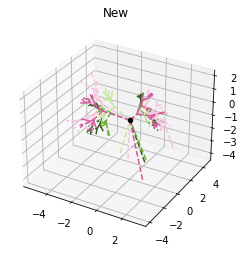

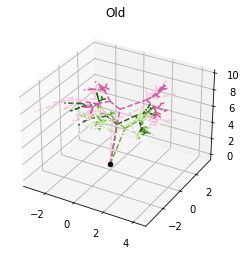

In [26]:
# Visualise scaled data

val_min = 0
val_max=6
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['PiYG'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)
# quick visualisation of tree

fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (name, participant_df) in list(enumerate(rotated_coords_df.groupby('idno')))[val_min:val_max]:
    test = participant_df.loc[participant_df.weibel_generation <=5]
    for j in range(len(test)):
        row = test.iloc[j]
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color='k')
        ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color=cmap(norm(i)))

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')
# plt.legend()
plt.title('New')
plt.show()


fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (name, participant_df) in list(enumerate(df_w_coords.groupby('idno')))[val_min:val_max]:
    test = participant_df.loc[participant_df.weibel_generation <=5]
    for j in range(len(test)):
        row = test.iloc[j]
        ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color=cmap(norm(i)))
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color=cmap(norm(i)))
plt.title('Old')
ax.scatter(0, 0, 0, marker='o', color='k', label='carina')
# plt.legend()
plt.show()

In [30]:
rotated_coords_df.to_csv('/home/sneha/e5_cleaned_w_coords_1407.csv',index=False)

In [31]:
# DONT REMOVE QC
df_w_coords = rotated_coords_df.copy()
QC_only = False
if QC_only:
    df_w_coords_qc = df_w_coords[df_w_coords.QC]
    print("Keeping only QC paths", len(df_w_coords), len(df_w_coords_qc), 100* len(df_w_coords_qc)/len(df_w_coords))
    df_w_coords = df_w_coords_qc.copy()
else:
    # REMOVE WEIBEL GENERATION > 10
    print('keeping only weibel less than 10')
    df_w_coords_w = df_w_coords.loc[df_w_coords.weibel_generation <= 10]
    print("Keeping only weibel < 10 ", len(df_w_coords), len(df_w_coords_w), 100* len(df_w_coords_w)/len(df_w_coords))
    df_w_coords = df_w_coords_w.copy()

keeping only weibel less than 10
Keeping only weibel < 10  964404 884133 91.67662100115719


In [16]:
# weird = df_w_coords.loc[~(df_w_coords.idno.isin(df_w_coords_qc.idno.unique()))]
# weird.anatomicalname.unique() 


# LOST TWO PARTICIPATNS BECAUSE THEY DONT HAVE LABELLED SEGMENTAL BRONCHI SO I DONT KNOW WHATS QC'd - ASK BEN

In [32]:
df_no_orphans = remove_all_orphans(df_w_coords)

Iterating ids:   0%|          | 0/2911 [00:00<?, ?it/s]

Iter 1: THERE ARE NO ORPHANS. Final df length 884133


## Save file

In [35]:
df_inter = df_no_orphans.copy()
df_inter.describe()
df_inter.to_csv('/home/sneha/e5_cleaned_1407.csv',index=False)

## FEATURE ENGINEERING

**Features we want:**

DF:
-  x,y,z (normalised into 0-1 coord frame)
- r (x,y,z dirn) 
- weibel generation (df)
- angle to parent (normalised - do radians / minmax scale)
- distance to 3 closest neighbours, only restricution is same lobe

GRAPH:
- number of descendents (graph)
- betweenness_centrality? (graph)
- distance to furthest child (graph)

DF again post GRAPH:
- calc distances from furthest descendent etc usiong points gathered in graph steps

### Distance to neighbor

In [36]:

def get_nearest_node(df_w_coords):
    '''
    In: DF with 'x', 'y', 'z'
    Iterates through LOBES in each aprtiicpant and for each branch point finds the closest (euclidean distance) neighboring branch point in the same lobe
    as a proxy for space 
    Doesnt take into account sequential nature of tree and that the futre nodes would not be there at growth but also the paper on mesenchyme dynamics (fig 4)
    'The mesenchyme growth dynamics (white crosses and white dashed arrows) also induces absolute orientation changes of the previously formed branches (black and white dashed lines), rotation at the branching site (rounded black dashed arrow) and differential rate of bud growth (black dashed arrows)'
    ASK BEN?
    
    returns 0 dist and neihbor nbpid = itself if its the only thing in the lobe
    
    returns feature_df: df with 'idno', 'endbpid', 'endbpid_nn_in_lobe', 'dist_nn_in_lobe' cols
    
    '''
    # distance to closest neighbours (using ALL paths not just Qcd ones)
    groups = list(df_w_coords.groupby([pd.Grouper('idno'), pd.Grouper('lobe')]))
    j=0
    for name, group in tqdm(groups):
        j+=1
        X = group[['x','y','z']].values
        tree = spatial.KDTree(X, leafsize=2)
        if X.shape[0] > 1:
            d, i = tree.query(list(X),  p=2, k=2)
            endbpid_nn = group.endbpid.values[i[:,1]]
            dist_df = pd.DataFrame({'idno':group.idno.to_list(), 'endbpid':group.endbpid.to_list(), 'endbpid_nn_in_lobe':endbpid_nn, 'dist_nn_in_lobe':d[:,1]})
        else:
            print('Only one item i ngroup')
            display(group)
            dist_df = pd.DataFrame({'idno':group.idno.to_list(), 'endbpid':group.endbpid.to_list(), 'endbpid_nn_in_lobe':group.endbpid.to_list(), 'dist_nn_in_lobe':0})
        if j == 1:
            feature_df = dist_df.copy()
        else:
            feature_df= pd.concat([feature_df, dist_df], axis=0)
    return feature_df




### Descendents

In [85]:
def get_num_descendents(df):
    
    i = 0
    groups = df.groupby('idno')
    for name, group in tqdm(groups):
        i+=1
        nodes = group.endbpid.to_list() + [-1]
        edges = list(zip(group.startbpid, group.endbpid))
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        
        group['desc_list'] = group['endbpid'].apply(lambda x:nx.descendants(g, x))
        group['num_desc'] = group['desc_list'].apply(lambda x:len(x))
        if i==1:
            return_df = group.copy()
        else:
            return_df = pd.concat([return_df, group], axis=0)
    print(len(return_df))
    return return_df
        

In [39]:
def get_dist_furthest_child(df):
    i = 0
    groups = df.groupby('idno')
    for name, group in tqdm(groups):
        i+=1
        nodes = group.endbpid.to_list() + [-1]
        edges = list(zip(group.startbpid, group.endbpid))
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)

        def _get_longest_path(node):
            desc_nodes = nx.descendants(g, node)
            mini_g = g.subgraph(nodes=list(desc_nodes)+[node])
            path_nodes =nx.dag_longest_path(mini_g, weight='centerlinelength')
            dist = group.loc[group.endbpid.isin(path_nodes)].centerlinelength.sum()
            return dist
        
        group['max_path_length'] = group['endbpid'].apply(_get_longest_path)
        
        if i==1:
            return_df = group.copy()
        else:
            return_df = pd.concat([return_df, group], axis=0)
    print(len(return_df))
    return return_df
        

In [71]:

def get_num_children(df):
    
    groups = df.groupby('idno')
    for i, (name, group) in tqdm(list(enumerate(groups))):
        unique_nodes = np.unique(list(zip(group.startbpid.to_list(), group.endbpid.to_list())))
        num_children =dict(Counter(group.startbpid.to_list()))
        frequ_dict = pd.DataFrame.from_dict({k:num_children.get(k, 0) for k in unique_nodes}, orient='index')
        frequ_dict = frequ_dict.reset_index().rename(columns={'index':'startbpid', 0:'num_children'})
        group_w_children = group.merge(frequ_dict, on=['startbpid'], how='left')
        if i == 0:
            output_df = group_w_children.copy()
        else:
            output_df = pd.concat([output_df, group_w_children], axis=0)
        print(len(output_df))
    return output_df
            



### Appply Feature engineering


In [66]:

# ADD NEEAREST NEIGHBOR INFO
feature_df = get_nearest_node(df_inter)
print('len', len(feature_df))
# MERGE FEATURE ONTO INTERMEDIATE DF    
df_w_nn = df_inter.merge(feature_df, how='left',on=['idno', 'endbpid'])
print(len(df_inter), len(df_w_nn))
display(df_w_nn)
# GET NUM DESCENDENTS
df_w_descendents = get_num_descendents(df_w_nn)
df_w_num_children = get_num_children(df_w_descendents)
# GET DIST TO FURTHEST CHILD
df_w_dist_furthest_child = get_dist_furthest_child(df_w_num_children)


df_unnormalised = df_w_dist_furthest_child.copy()

  0%|          | 0/17443 [00:00<?, ?it/s]

Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
118727,3017613,RUL,0.069447,-0.009017,3.0,0.0,32.0,18.0,107.346,0.0,...,0.172456,-0.467623,0.642981,4.939273,0.135587,1.457419,-0.034829,0.074846,1.46993,-0.066084


Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
163558,3021203,RB4+5,0.695325,0.217794,4.0,0.0,77.0,63.0,86.8639,-0.697518,...,2.715206,-0.611868,2.104831,4.992863,0.053242,3.151896,-0.896217,-0.367304,2.779262,-0.486629


Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
270927,4015118,RB4+5,1.134401,0.149106,4.0,0.0,30.0,24.0,135.403,-0.58232,...,1.763374,-0.116215,1.27837,3.777004,0.137463,2.569166,-1.111297,-0.189933,1.890358,-0.263418


Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
341295,4019679,RB4+5,0.510963,0.120405,4.0,0.0,22.0,17.0,136.282,-0.473118,...,1.594281,-0.050759,1.556599,3.350067,-0.642351,2.087382,-0.48317,-0.602502,1.699852,-0.152539


Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
479440,5017530,RUL,0.13376,0.708005,3.0,0.0,9.0,4.0,54.6099,0.816497,...,0.539376,-0.166605,2.103383,5.289703,0.607416,0.920004,0.026604,0.680297,1.02252,-0.0189


Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
721655,7015666,RB4+5,0.699202,0.190305,4.0,0.0,14.0,8.0,141.164,-0.404647,...,1.485348,-0.16181,0.691368,3.398008,-0.392437,2.239833,-0.425435,-0.285344,1.695206,-0.000235


Only one item i ngroup


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_z,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
726819,7016077,LLB6,0.043352,-0.008022,2.0,0.0,69.0,55.0,55.6987,0.447214,...,1.727147,0.019438,1.496719,3.265568,-2.525034,0.817423,0.025084,-2.522854,0.859906,0.016728


len 884133
884133 884133


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz,endbpid_nn_in_lobe,dist_nn_in_lobe
0,3010007,Trachea,4.125184,1.630629,0.0,0.0,1.0,-1.0,NaN,-0.024446,...,0.947918,4.013532,0.000000e+00,0.000000,0.000000e+00,2.771280e+00,-2.906997,-9.415555e-01,2.0,1.000000
1,3010007,LMB,2.004944,0.689714,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.947918,4.013532,-1.983960e+00,0.289306,4.336809e-18,0.000000e+00,0.000000,0.000000e+00,1.0,2.004943
2,3010007,RMB,1.000000,1.000000,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.947918,4.013532,5.551115e-17,1.000000,-5.204170e-18,0.000000e+00,0.000000,0.000000e+00,1.0,1.000000
3,3010007,BronInt,1.172444,0.519476,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.947918,4.013532,-3.913718e-01,2.103904,5.339283e-02,5.551115e-17,1.000000,-5.204170e-18,8.0,0.349856
4,3010007,RUL,0.654350,0.351148,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.947918,4.013532,6.468723e-01,1.097651,1.391293e-02,5.551115e-17,1.000000,-5.204170e-18,11.0,0.141689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884128,8024995,-,0.279705,0.052625,2.0,9.0,308.0,284.0,165.5500,-0.145479,...,1.005850,3.203824,-3.498696e+00,3.425860,3.012041e-01,-3.399310e+00,3.193114,1.820972e-01,284.0,0.279705
884129,8024995,-,0.657754,0.021746,2.0,9.0,309.0,285.0,172.0070,0.515058,...,1.005850,3.203824,-4.798101e+00,3.684682,6.065946e-01,-4.237410e+00,3.433520,3.716823e-01,310.0,0.643758
884130,8024995,-,0.038343,-0.006121,2.0,9.0,310.0,285.0,120.9650,-0.577350,...,1.005850,3.203824,-4.232530e+00,3.467346,3.890672e-01,-4.237410e+00,3.433520,3.716823e-01,285.0,0.038343
884131,8024995,-,0.334305,0.047232,2.0,9.0,311.0,286.0,152.5930,0.285831,...,1.005850,3.203824,-4.138012e+00,3.551184,1.402882e-01,-3.885752e+00,3.335635,9.950102e-02,285.0,0.277971


  0%|          | 0/2911 [00:00<?, ?it/s]

884133


  0%|          | 0/2911 [00:00<?, ?it/s]

351
779
1198
1371
1839
2351
2820
3155
3398
3876
4342
4809
5415
5597
5921
6283
6544
6888
7167
7651
8079
8426
8790
9284
9649
10050
10390
10578
11007
11318
11679
12128
12389
12823
13209
13448
14134
14640
14985
15419
15660
16124
16578
17014
17286
17779
18025
18341
18892
19251
19583
19927
20278
20792
21452
21957
22387
22711
23003
23393
23770
24088
24285
24776
25158
25494
25829
26248
26912
27298
27554
27945
28241
28539
28886
29181
29576
29918
30276
30374
30510
30787
31048
31479
31906
32267
32389
32994
33247
33579
33843
34082
34383
34567
34957
35328
35705
36064
36482
36940
37312
37531
37938
38244
38423
38540
38834
39110
39414
39708
40074
40488
40823
41050
41544
42067
42603
42730
42885
43274
43540
43875
44251
44750
44937
45284
45682
45857
46224
46396
46611
46853
47200
47361
47698
47950
48314
48751
49354
49772
50119
50472
50717
51023
51343
51559
51999
52341
52593
52798
53102
53421
53846
54238
54585
54915
55275
55721
56165
56298
56633
56938
57174
57393
57855
58220
58488
58837
59035
59233
59528
5

399978
400315
400671
400816
401004
401077
401259
401548
401750
402002
402231
402607
402966
403266
403555
403919
404234
404679
405023
405300
405749
406094
406327
406550
406759
407132
407464
407600
408046
408449
408940
409280
409500
409876
409952
410427
410697
410893
411073
411626
411912
412008
412467
412625
412785
412991
413380
413602
413966
414179
414464
414686
415199
415419
415807
415958
416287
416597
416882
417091
417390
417448
417806
418048
418211
418415
418741
418892
419191
419526
419712
419891
420265
420618
420957
421165
421292
421548
421743
421907
422114
422590
422960
423367
423712
423892
424290
424770
425138
425534
425866
426157
426564
426901
427301
427649
428090
428270
428617
428821
429055
429456
429711
429926
430433
430759
431002
431290
431573
431839
432117
432189
432416
432850
432947
433360
433735
434057
434266
434452
434609
434920
435143
435450
435682
436050
436303
436648
436740
436854
436950
437276
437675
437934
438178
438467
438700
438998
439393
439860
440149
440425
440730

732673
732910
733130
733444
733704
733804
734157
734537
734888
735139
735433
735635
735874
736103
736332
736657
737028
737245
737483
737718
737994
738243
738487
738566
739119
739411
739598
739888
740213
740501
740899
741277
741493
741787
742200
742460
742694
742811
743251
743416
743619
743934
744123
744388
744451
744695
744910
745205
745538
745782
746071
746250
746722
747166
747443
747875
748072
748190
748564
748792
749185
749560
749886
750382
750536
750915
751311
751680
751977
752199
752441
752805
753158
753451
753631
753695
754050
754266
754532
754880
755065
755346
755769
755899
756208
756451
756590
756962
757429
757638
757910
758220
758632
758739
759173
759358
759606
759811
760146
760528
760858
761003
761375
761804
761982
762374
762521
762834
763194
763455
763817
764152
764373
764569
764645
764836
765201
765480
765821
766192
766372
766715
766928
767159
767303
767590
768077
768343
768712
768851
769133
769461
769813
770078
770188
770491
770860
771106
771338
771595
771987
772405
772600

  0%|          | 0/2911 [00:00<?, ?it/s]

884133


In [68]:
# check nans
display(df_unnormalised.isnull().sum())
df_unnormalised.fillna(0, inplace=True)
display(df_unnormalised.isnull().sum())

idno                     0
anatomicalname           0
centerlinelength         0
avginnerarea             0
lobe                     0
sublobe                  0
endbpid                  0
startbpid                0
angle                 2943
dircosx                  0
dircosy                  0
dircosz                  0
weibel_generation        0
QC                       0
x                        0
y                        0
z                        0
parent_loc_x             0
parent_loc_y             0
parent_loc_z             0
shift_x                  0
shift_y                  0
shift_z                  0
nx                       0
ny                       0
nz                       0
parent_loc_nx            0
parent_loc_ny            0
parent_loc_nz            0
endbpid_nn_in_lobe       0
dist_nn_in_lobe          0
num_desc                 0
num_children             0
max_path_length          0
dtype: int64

idno                  0
anatomicalname        0
centerlinelength      0
avginnerarea          0
lobe                  0
sublobe               0
endbpid               0
startbpid             0
angle                 0
dircosx               0
dircosy               0
dircosz               0
weibel_generation     0
QC                    0
x                     0
y                     0
z                     0
parent_loc_x          0
parent_loc_y          0
parent_loc_z          0
shift_x               0
shift_y               0
shift_z               0
nx                    0
ny                    0
nz                    0
parent_loc_nx         0
parent_loc_ny         0
parent_loc_nz         0
endbpid_nn_in_lobe    0
dist_nn_in_lobe       0
num_desc              0
num_children          0
max_path_length       0
dtype: int64

In [69]:

df_unnormalised.to_csv('/home/sneha/e5_cleaned_unnormalised_140722.csv',index=False)

### NORMALISATION

In [81]:
df_unnormalised = df_unnormalised.reset_index()

In [82]:



all_features = ['centerlinelength', 'avginnerarea', 'lobe',
       'sublobe', 'endbpid', 'startbpid', 'angle', 'dircosx', 'dircosy',
       'dircosz', 'weibel_generation', 'QC', 'x', 'y', 'z', 'parent_loc_x',
       'parent_loc_y', 'parent_loc_z', 'endbpid_nn_in_lobe', 'dist_nn_in_lobe',
       'num_desc', 'max_path_length']

measurements = ['centerlinelength', 'avginnerarea',    'dist_nn_in_lobe','max_path_length'] # apply mean / std scaling to maintain distribution

fixed_scale = ['angle', 'weibel_generation', 'num_desc','lobe','sublobe','nx', 'ny', 'nz', 'parent_loc_nx',
       'parent_loc_ny', 'parent_loc_nz','dircosx', 'dircosy','dircosz' , 'num_children'] # apply minmax scaling to get all in range0-1





no_scaling = [] # already a vector of norm 1

normaliser_minmax = MinMaxScaler(feature_range=(0,1))
Xminmax = df_unnormalised[fixed_scale].values
Xminmax_norm = normaliser_minmax.fit_transform(Xminmax) # per-feature normalisation

normaliser_standard = StandardScaler()
Xstandard = df_unnormalised[measurements]
Xstandard_norm = normaliser_standard.fit_transform(Xstandard)





In [83]:
normed_feature_names = measurements + fixed_scale
normed_feature_names = [col+'_norm' for col in normed_feature_names]
df_normalised_features = pd.DataFrame(np.concatenate([Xstandard_norm, Xminmax_norm], axis=1), columns=normed_feature_names)
display(df_normalised_features.index)
display(df_unnormalised.index)
final_df = pd.concat([df_unnormalised, df_normalised_features], axis=1)

final_df

RangeIndex(start=0, stop=884133, step=1)

RangeIndex(start=0, stop=884133, step=1)

,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,nx_norm,ny_norm,nz_norm,parent_loc_nx_norm,parent_loc_ny_norm,parent_loc_nz_norm,dircosx_norm,dircosy_norm,dircosz_norm,num_children_norm
0,0,3010007,Trachea,4.125184,1.630629,0.0,0.0,1.0,-1.0,0.0000,...,0.709887,0.315693,0.738915,0.662233,0.517282,0.605279,0.487777,0.614894,0.986467,0.0
1,1,3010007,LMB,2.004944,0.689714,0.0,0.0,3.0,1.0,140.0360,...,0.679010,0.320980,0.738915,0.621680,0.555791,0.629323,0.804256,0.522963,0.896107,0.1
2,2,3010007,RMB,1.000000,1.000000,0.0,0.0,2.0,1.0,134.8050,...,0.709887,0.333968,0.738915,0.621680,0.555791,0.629323,0.152888,0.476061,0.859082,0.1
3,3,3010007,BronInt,1.172444,0.519476,0.0,0.0,4.0,2.0,160.3120,...,0.703796,0.354143,0.740412,0.621680,0.569038,0.629323,0.291081,0.509083,0.954171,0.1
4,4,3010007,RUL,0.654350,0.351148,3.0,0.0,5.0,2.0,98.5825,...,0.719955,0.335753,0.739305,0.621680,0.569038,0.629323,0.093438,0.480640,0.209599,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884128,307,8024995,-,0.279705,0.052625,2.0,9.0,308.0,284.0,165.5500,...,0.655435,0.378302,0.747362,0.571938,0.598091,0.633973,0.427260,0.790957,0.900066,0.1
884129,308,8024995,-,0.657754,0.021746,2.0,9.0,309.0,285.0,172.0070,...,0.635211,0.383032,0.755926,0.559673,0.601275,0.638814,0.757529,0.741433,0.854102,0.1
884130,309,8024995,-,0.038343,-0.006121,2.0,9.0,310.0,285.0,120.9650,...,0.644014,0.379060,0.749826,0.559673,0.601275,0.638814,0.211325,0.788675,0.788675,0.1
884131,310,8024995,-,0.334305,0.047232,2.0,9.0,311.0,286.0,152.5930,...,0.645485,0.380592,0.742849,0.564819,0.599979,0.631864,0.642915,0.642915,0.957329,0.1


In [84]:
final_df.to_csv('/home/sneha/e5_cleaned_normalised_1407.csv',index=False)